<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Brachistocrone_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drive Permissions

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#Imports and Global Values

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

In [9]:
import sys
import math
import numpy as np 
import gym
import os
import stable_baselines3
from datetime import datetime, date

# Reinforcement Learning Algorithms
from gym import spaces

# Reinforcement Learning. Stable Baseline
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback

# Math Algorithms
from scipy.optimize import newton
from scipy.integrate import quad

# Render Functions 
from matplotlib.animation import FuncAnimation
from IPython import display

date_string = date.today()
sys.path.append('..')
base_path = "/content/gdrive/My Drive/Brachistochrone_RL/"
models_path = os.path.join(base_path, "models/" + f'{date_string}')

best_model_path = os.path.join(models_path, "best")
log_path = os.path.join(models_path, "logs")
tensorboard_log = os.path.join(models_path, "tensorboard")

try:
  os.makedirs(best_model_path)
except OSError:
  for f in os.listdir(best_model_path):
    os.remove(os.path.join(best_model_path, f))

try:
  os.makedirs(log_path)
except OSError:
  for f in os.listdir(log_path):
    os.remove(os.path.join(log_path, f))

print("Done")

Done


# Common functions

# Genetic Algorithm

In [8]:
class Brachistochrone_Env(gym.Env):
    
    dt = 0.01 #HYP
    renderOnReset = True #set to false to speed up training
    
    def __init__(self):

        super(Brachistochrone_Env, self).__init__()
        self.states = np.array([0.0, 0.0, 0.0 ,-45.0]) #pos_x, pos_y, vel, #theta from +ve x axis
        self.target_pos = np.array([+8.0, -6.0])
        self.g = -10.0
        self.reward = 0.0
        self.time_steps = 0
        self.target_steps = 200
        self.action_seq = []
        
        #for rendering purpose
        self.x_ep = [0]
        self.y_ep = [0]
        self.video = [(0,0)]


        act_val_high = np.array([0.0])
        act_val_low = np.array([-90.0])
        self.action_space = spaces.Box(low = act_val_low, high = act_val_high, shape = (1,), dtype=np.float32)

        obs_val_high = np.array([100.0, 100.0, 1000.0, 0.0])
        obs_val_low = np.array([-100.0, -100.0, -1000.0,-90.0])
        self.observation_space = spaces.Box(low= obs_val_low, high = obs_val_high, shape=(4,), dtype=np.float32)

    def step(self, action):
        dt = Brachistochrone_Env.dt
        # action corresponds to theta
        final_theta = action
        original_theta = self.states[3]

        original_vel = self.states[2]
        initial_vel_x = original_vel*math.cos(math.radians(original_theta))
        initial_vel_y = original_vel*math.sin(math.radians(original_theta))

        acceleration = self.g*math.sin(math.radians(final_theta)) # always positive
        acceleration_x = acceleration*math.cos(math.radians(final_theta)) #always positive
        acceleration_y = acceleration*math.sin(math.radians(final_theta)) # always negative

        displacement_x = (initial_vel_x*dt) + (0.5*acceleration_x*(dt**2))
        displacement_y = (initial_vel_y*dt) + (0.5*acceleration_y*(dt**2))
        displacement = math.sqrt(displacement_x**2 + displacement_y**2)

        final_vel_x = initial_vel_x + acceleration_x*dt
        final_vel_y = initial_vel_y + acceleration_y*dt

        final_x = self.states[0] + displacement_x
        final_y = self.states[1] + displacement_y
        final_vel = math.sqrt(final_vel_x**2 + final_vel_y**2)

        self.states[0] = final_x
        self.states[1] = final_y
        self.states[2] = final_vel
        self.states[3] = final_theta
        
        #updating path
        self.x_ep.append(final_x)
        self.y_ep.append(final_y)
        self.video.append((final_x,final_y))

        """APPLY POLICY"""
        err_position = math.sqrt((self.states[0] - self.target_pos[0])**2 + (self.states[1] - self.target_pos[1])**2)
        self.reward = -0.1*err_position

        done=False	
        self.time_steps+=1
        if self.time_steps>=self.target_steps or err_position<=0.05:
            done = True
        if err_position<=0.05:
            self.reward  = 0.1*(self.target_steps  - self.time_steps)
        if self.states[0]>8.0 or self.states[0]<0.0 or self.states[1]>0.0 or self.states[1]<-6.0:
            self.reward = -2*(self.target_steps - self.time_steps)
            done = True

        info = {'g_component':acceleration}
        return self.states, self.reward, done, info

    def reset(self):
                #render and reset trace
        if (Brachistochrone_Env.renderOnReset== True):
            print("EP_REWARD:"+str(self.reward))
            self.render(mode="auto")
        self.x_ep.clear()
        self.y_ep.clear()
        self.render()
        self.time_steps = 0
        self.reward = 0.0
        self.states = np.array([0.0, 0.0, 0.0 ,-45.0])

        return self.states
    
    def animate(self,frame_num):
        """
        x,y = zip(*self.video)
        x = list(x)
        y = list(y)
        """
        x = (x[0] for x in self.video[0])
        y = (x[1] for x in self.video[0])
        line.set_data((x, y))
        return line
    
    def render(self,mode='human'):
        
        """call it at the end of an episode"""
        """
        fig, ax = plt.subplots()
        line, = ax.plot([])     # A tuple unpacking to unpack the only plot
        x_goal = self.target_pos[0]
        y_goal = self.target_pos[1]
        #setting plot boundary
        ax.set_xlim(0, x_goal +1)
        ax.set_ylim(y_goal -1,1)
        anim = FuncAnimation(fig, self.animate, frames=100, interval=20)

        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()
        """
        if (len(self.x_ep)!=0):
            time_taken = self.time_steps/100
            x = np.array(self.x_ep)
            y = np.array(self.y_ep)
            plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
            goal = self.target_pos
            plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
            plt.scatter(x[0], y[0], color = 'red', s = 100.0)
            plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
            plt.annotate('Start', (x[0], y[0]))
            plt.annotate('End', (x[-1], y[-1]))
            plt.annotate('Goal', goal)
            plt.legend()
            plt.xlabel('X-COORDINATE(m)')
            plt.ylabel('Y-COORDINATE(m)')
            plt.title('TRAJECTORY')
            plt.show()

print("Done Class Brachistochrone")

Done Class Brachistochrone


In [12]:
env = Brachistochrone_Env()
print(env.target_pos)
env = make_vec_env(lambda: env, n_envs=1)

n_actions = env.action_space.shape[-1]

#Add noise to maximize exploration
action_noise = NormalActionNoise(mean = np.zeros(n_actions), 
                                sigma=0.1*np.ones(n_actions))

eval_callback = EvalCallback(env, best_model_path,
                             log_path, eval_freq=5000,
                             deterministic=True, render=False)

model = DDPG('MlpPolicy', env =env, action_noise=action_noise, verbose=1,
            gamma= 0.9999, buffer_size = 200000, learning_starts = 50000,
             gradient_steps = -1, learning_rate=0.001,
            policy_kwargs= dict(net_arch=[300, 400, 300]), train_freq = (1, "episode"), tensorboard_log=tensorboard_log)

os.system('spd-say "your program has started"')


model.learn(total_timesteps=650000, log_interval=1, callback=eval_callback)

os.system('spd-say "your program has finished"')

max_epsiodes = 1
position= []
x = []
y = []

for ep in range(max_epsiodes):
    print("Episode {}".format(ep + 1))
    episodic_reward = []
    steps = 0

    obs = env.reset()
    print("Inital obs: "  +str(obs))
    while True:
        action, _ = model.predict(obs, deterministic = True)
        obs, reward, done, info = env.step(action)
        position.append((obs[0][0], obs[0][1]))
        x.append(obs[0][0])
        y.append(obs[0][1])
        episodic_reward.append(reward)

        steps+=1
        #print('obs=', obs, 'reward=', reward, 'done=', done)
        if done:
            print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
            print("Steps taken: " + str(steps))
            #print()
            break

[ 8. -6.]


/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


AttributeError: ignored

In [ ]:
#save model
env = Brachistochrone_Env()
print(env.target_pos)
env = make_vec_env(lambda: env, n_envs=1)
model = DDPG.load("./saved_models/generalized_5/best_model", env=env)
model.learn(total_timesteps=300000, log_interval=100, callback=eval_callback)
#model.save("./saved_models/generalized_5/")

[ 8. -6.]


PermissionError: [Errno 13] Permission denied: 'saved_models\\generalized_5'

## Linearly interpolate of two points

In [14]:
def cycloid(P1,P2,N):
    """Return the path of Brachistochrone curve from (0,0) to (x2, y2).
    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).
    """

    # First find theta2 from (x2, y2) numerically (by Newton-Rapheson).
    f = lambda theta: -P2[1]/P2[0] - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/2)

    # The radius of the circle generating the cycloid.
    R = -P2[1] / (1 - np.cos(theta2))

    theta = np.linspace(0, theta2, N)
    x = R * (theta - np.sin(theta))
    y = R * (1 - np.cos(theta))

    # The time of travel
    T = theta2 * np.sqrt(R / 9.8)
    return x, y, T

def rect(P1,P2,N):
    """Return the rectilinear straight path from (0,0) to (x2, y2)."""
    x_interval = np.linspace(P1[0],P2[0],N)
    m = float(P2[1] - P1[1])/(P2[0]-P1[0])
    q = P1[1] - (m*P1[0])
    f_y = lambda x: m*x+q
    y = [f_y(x) for x in x_interval]
    T_rett = math.sqrt(2*(P2[0]**2+P2[1]**2)/(Brachistochrone_Env.g*P2[1]))
    return x_interval,y,T_rett

def plot_solution(x,y,goal):
            len_x = len(x)
            len_y = len(y)
            if (len_x==len_y):
                time_taken = len_x/100
                x = np.array(x)
                y = np.array(y)
                plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
                plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
                plt.scatter(x[0], y[0], color = 'red', s = 100.0)
                plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
                plt.annotate('Start', (x[0], y[0]))
                plt.annotate('End', (x[-1], y[-1]))
                plt.annotate('Goal', goal)
                plt.legend()
                plt.xlabel('X-COORDINATE(m)')
                plt.ylabel('Y-COORDINATE(m)')
                plt.title('TRAJECTORY')
                plt.show()
            else:
                print("inconsistent dimensions")
                

print("Done")

Done


## Custome Agent Target


C:\Users\Gianmarco Petrelli\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Inital obs: [[  0.   0.   0. -45.]]


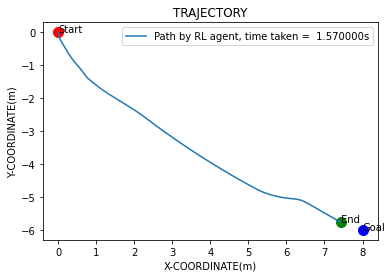

Goal reached! episodic-reward= -101.007286
Steps taken: 159
Time taken:  1.59


In [ ]:
# Found the optimal path
env = Brachistochrone_Env()
env = make_vec_env(lambda: env, n_envs=1)
model = DDPG.load("./saved_models/generalized_5/best_model", env=env)

# Setting GOAL
goal = (8.0, -6.0)

# List of tuples containing subsequent positions
position= []

# X steps
x = []
# Y values associated
y = []
steps = 0
actions = []
observations = []

### Building Solution

In [ ]:
#print("Episode {}".format(ep + 1))
episodic_reward = []

#we have to force target into environment as it must be constant and specified to AI agent
obs = env.reset()
print("Inital obs: "  +str(obs))
while True:
    action= model.predict(obs, deterministic = False)
    #print("azione:",action)
    #print("prima",obs)
    obs, reward, done, info = env.step(action)
    observations.append(obs)
    #print("dopo",obs)
    new_value = obs[0] #the array from which to extract new piece of path information
    """new_value[1]: pos_x new_value[2]: pos_y"""
    position.append((new_value[0],new_value[1]))
    if done==False:
        x.append(new_value[0])
        y.append(new_value[1])
    episodic_reward.append(reward)
    actions.append(action)
    steps+=1
    #print('obs=', obs, 'reward=', reward, 'done=', done)
    if done:
        x.pop()
        y.pop()
        position.pop()
        plot_solution(x,y,goal)
        print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
        print("Steps taken: " + str(steps))
        print("Time taken: " , steps/100)

        break
            

In [ ]:
#defining custom environment for agent training
#TODO parametrizzare i confini (x,y) della mappa

class Brachistochrone_Env(gym.Env):
    g = -9.8 #HYP
    dt = 0.01 #HYP
    renderOnReset = True #set to false to speed up training
    
    """finding the optimal value for this target_ep_duration parameter is hard: ideally we should set a value that allows the model learning how to reach the target while not overfitting focusing to the fixed one""" 
    target_ep_duration = 1 #we define the period across wich we maintein target fixed ?1?
    
    def __init__(self):
        super(Brachistochrone_Env, self).__init__()
        target = Brachistochrone_Env.target_position_from_circular_neibourghood() #2 modals for target selection
        self.states = np.array([0.0, 0.0, float(target[0]), float(target[1]), 0.0 ,-45.0]) #time pos_x pos_y target_x target_y vel theta
        self.target_pos = np.array(target)#HYP: y-coordinates of end-points
        #init rl params
        self.reward = 0.0
        self.time_steps = 0
        self.ep_counter = 0
        self.target_steps = Brachistochrone_Env.target_steps_bounder(self.target_pos)  #? ...HYP
        self.action_seq = []
        #define analytic measures
        self.lossTimeSeries = []
        #for rendering purpose
        self.x_ep = [0]
        self.y_ep = [0]
        self.video = [(0,0)]

        #defining action space
        act_val_high = np.array([0.0])
        act_val_low = np.array([-90.0])
        #the action defines the angle between horizontal axis and line connecting two consecutive points
        self.action_space = spaces.Box(low = act_val_low, high = act_val_high, shape = (1,), dtype=np.float32)

        #given the theoretical approach observable params are equal to state 
        obs_val_high = np.array([100.0, 100.0, 100.0, 100.0, 1000.0, 0.0]) #time pos_x pos_y target_x target_y vel theta
        obs_val_low = np.array([-100.0, -100.0, -100.0, -100.0, -1000.0,-90.0]) 
        self.observation_space = spaces.Box(low= obs_val_low, high = obs_val_high, shape=(6,), dtype=np.float32)

    """the idea is to discretize the fall between two points binding the step function to a specified dt:HYP"""
    def step(self, action):
        # action corresponds to theta angle fixed for an infinitesimal period of time
        final_theta = action
        original_theta = self.states[5]
        #Basic descrete mechanic computations to find new velocity and acceleration and making the environment evolve
        original_vel = self.states[4]
        initial_vel_x = original_vel*math.cos(math.radians(original_theta))
        initial_vel_y = original_vel*math.sin(math.radians(original_theta))

        acceleration = Brachistochrone_Env.g *math.sin(math.radians(final_theta)) # always positive
        acceleration_x = acceleration*math.cos(math.radians(final_theta)) #always positive
        acceleration_y = acceleration*math.sin(math.radians(final_theta)) # always negative
        #print("y accelerazione:"+str(acceleration_y))

        displacement_x = (initial_vel_x*Brachistochrone_Env.dt) + (0.5*acceleration_x*(Brachistochrone_Env.dt**2))
        displacement_y = (initial_vel_y*Brachistochrone_Env.dt) + (0.5*acceleration_y*(Brachistochrone_Env.dt**2))
        #print("scostamento lungo y"+str(displacement_y))
        displacement = math.sqrt(displacement_x**2 + displacement_y**2)

        final_vel_x = initial_vel_x + acceleration_x*Brachistochrone_Env.dt
        final_vel_y = initial_vel_y + acceleration_y*Brachistochrone_Env.dt

        final_x = self.states[0] + displacement_x
        final_y = self.states[1] + displacement_y
        final_vel = math.sqrt(final_vel_x**2 + final_vel_y**2)
        
        #updating states
        #self.states[0] = self.time_steps + 1.0
        self.states[0] = final_x
        self.states[1] = final_y
        self.states[2] = self.target_pos[0]
        self.states[3] = self.target_pos[1]
        self.states[4] = final_vel
        self.states[5] = final_theta
        
        #updating path
        self.x_ep.append(final_x)
        self.y_ep.append(final_y)
        self.video.append((final_x,final_y))
        
        #euclidean distance as a measure of error
        err_position = math.sqrt((self.states[0] - self.target_pos[0])**2 + (self.states[1] - self.target_pos[1])**2)
        print(err_position)
        #apply reward as a function of error
        #we want a reward: << err_position & << number of steps
        
        """policy"""
        k = -math.log(err_position, 1.2)
        self.reward += k*((self.target_steps  - self.time_steps)**2) #penalty for distance
        #self.reward += 0.5*(self.target_steps  - self.time_steps) # reward for being fast
        done=False
        self.time_steps+=1 #update time counter
        if self.time_steps>=self.target_steps or err_position<=0.1:
            done = True
        #if err_position<=0.5:
            #when te agent succeeded to find target needs to improve time efficiency
            #self.reward  = 0.5*(self.target_steps  - self.time_steps)
        if self.states[0]>self.target_pos[0] or self.states[0]<0.0 or self.states[1]>0.0 or self.states[1]<self.target_pos[1]:
            #give an higher penalty to early out-of-map agents
            #self.reward = -2*(self.target_steps - self.time_steps)
            done = True

        info = {'g_component':acceleration}
        #print("time_steps:"+str(self.states[0]))
        return self.states, self.reward, done, info
    
    @staticmethod
    def target_steps_bounder(target_pos: tuple):
        """trying to cut all sub-optimal solutions dinamically selecting max. steps per episode from trivial linear solution"""
        if (target_pos[1]>=0):
            raise Exception("error: unfeasible path given")
        L = target_pos[0] #we suppose paths are built between (0,0) and (x_t,y_t) for normalization reasons
        H = target_pos[1]
        T_rett = math.sqrt(2*(L**2+H**2)/(Brachistochrone_Env.g*H))
        #this method must return number of maximum steps
        N_target_steps = T_rett/Brachistochrone_Env.dt
        return int(math.ceil(N_target_steps))+50
    @staticmethod   
    def target_position_from_uniform_2D_sample():
        """define a target strip on which to sample different goal points in order to train the agent to generalize"""
        """We train our agent in order to be able to reach effectively and efficiently a GOAL map in [5;50]:[-5;-50]"""
        return (int(np.random.uniform(5,50)),int(np.random.uniform(-5,-50)))
    
    @staticmethod
    def target_position_from_circular_neibourghood(c_c = (6,-8)):
        center = c_c
        length = np.sqrt(np.random.uniform(0, 1))
        angle = np.pi * np.random.uniform(0, 2)

        x = center[0] + length * np.cos(angle)
        y = center[1] + length * np.sin(angle)
        return (x,y)
    
    @staticmethod
    def target_position_from_uniform_strip_sample():
        xt = np.random.uniform(5,50)
        if (xt<40):
            yt = np.random.uniform(-50,-30)
        else:
            yt = np.random.uniform(-50,-5)
        return (xt,yt)
    
    
    """we suppose to use this function only for tests and practical use of the agent"""
    def reset_set_target(self,target:tuple):
        #fix a target for trained agent
        self.target_pos = target
        self.target_steps = Brachistochrone_Env.target_steps_bounder(self.target_pos)
        self.states = np.array([0.0, 0.0, float(self.target_pos[0]), float(self.target_pos[1]), 0.0 ,-45.0])
        return self.states

    def reset(self):
        
        #render and reset trace
        if (Brachistochrone_Env.renderOnReset== True):
            print("EP_REWARD:"+str(self.reward))
            self.render(mode="auto")
        self.x_ep.clear()
        self.y_ep.clear()
        
        #self.video.clear()
        self.time_steps = 0
        self.reward = 0.0
        
        #counting whenever an episode ends
        self.ep_counter +=1

        #change goal when target duration is reached- on episode reset
        if (self.ep_counter >= Brachistochrone_Env.target_ep_duration):
            self.target_pos = np.array(Brachistochrone_Env.target_position_from_circular_neibourghood())
            #print("target switch to:",self.target_pos)
            #print("new boundary:",Brachistochrone_Env.target_steps_bounder(self.target_pos))
            self.target_steps = Brachistochrone_Env.target_steps_bounder(self.target_pos)
            self.ep_counter = 0
            
        #updating state as a last thing    
        self.states = np.array([0.0, 0.0, float(self.target_pos[0]), float(self.target_pos[1]), 0.0 ,-45.0])

        return self.states
    
    def animate(self,frame_num):
        """
        x,y = zip(*self.video)
        x = list(x)
        y = list(y)
        """
        x = (x[0] for x in self.video[0])
        y = (x[1] for x in self.video[0])
        line.set_data((x, y))
        return line
    
    def render(self,mode='human'):
        
        """call it at the end of an episode"""
        """
        fig, ax = plt.subplots()
        line, = ax.plot([])     # A tuple unpacking to unpack the only plot
        x_goal = self.target_pos[0]
        y_goal = self.target_pos[1]
        #setting plot boundary
        ax.set_xlim(0, x_goal +1)
        ax.set_ylim(y_goal -1,1)
        anim = FuncAnimation(fig, self.animate, frames=100, interval=20)

        video = anim.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()
        """
        if (len(self.x_ep)!=0):
            time_taken = self.time_steps/100
            x = np.array(self.x_ep)
            y = np.array(self.y_ep)
            plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
            goal = self.target_pos
            plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
            plt.scatter(x[0], y[0], color = 'red', s = 100.0)
            plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
            plt.annotate('Start', (x[0], y[0]))
            plt.annotate('End', (x[-1], y[-1]))
            plt.annotate('Goal', goal)
            plt.legend()
            plt.xlabel('X-COORDINATE(m)')
            plt.ylabel('Y-COORDINATE(m)')
            plt.title('TRAJECTORY')
            plt.show()

    
    


EP_REWARD:0.0
EP_REWARD:-10


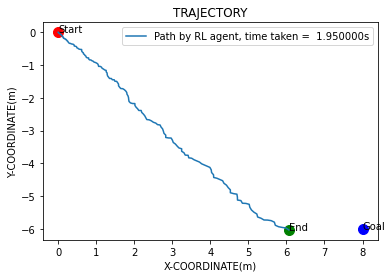

EP_REWARD:-0.13054715662224126


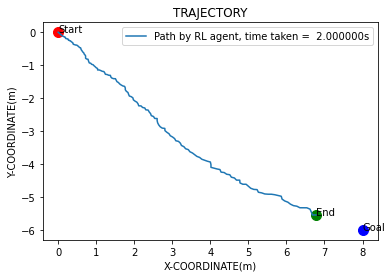

EP_REWARD:-36


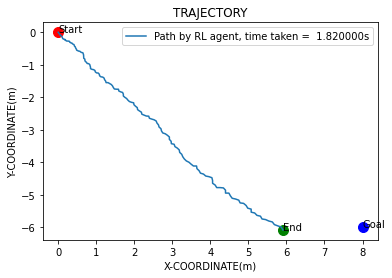

EP_REWARD:-36


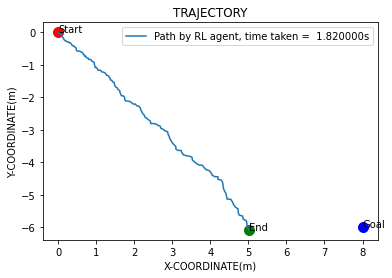

EP_REWARD:-0.9933123984890639


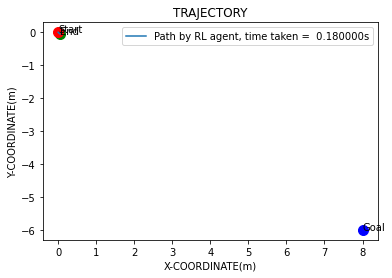

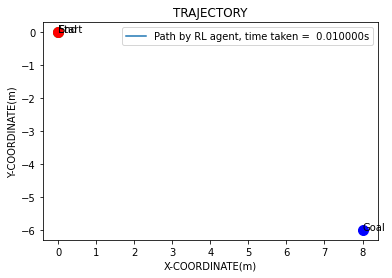

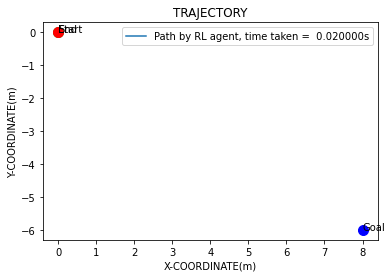

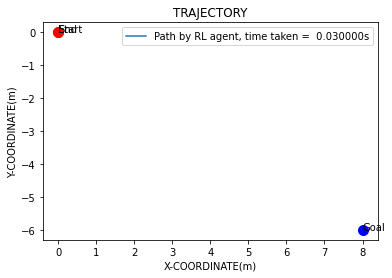

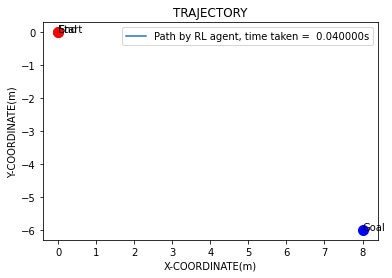

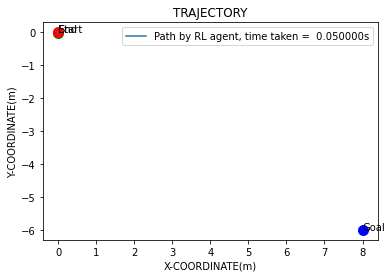

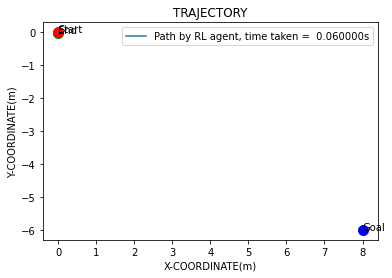

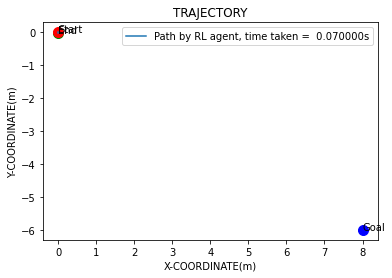

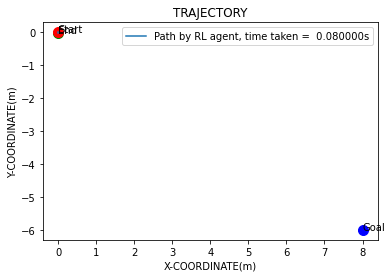

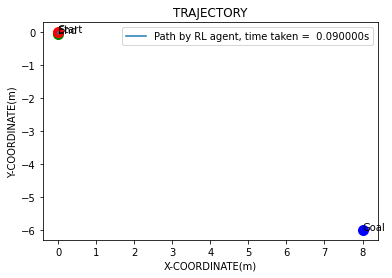

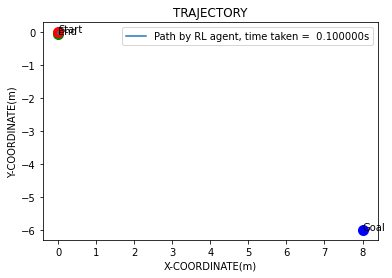

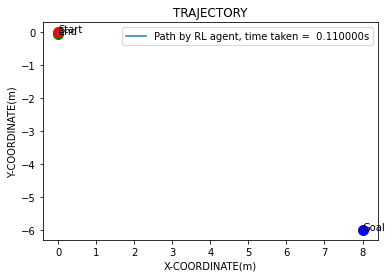

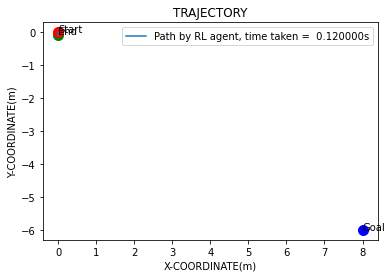

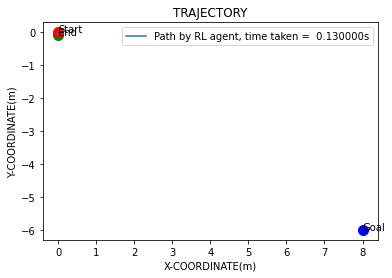

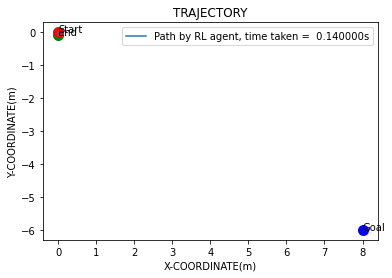

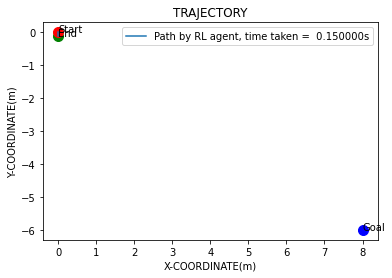

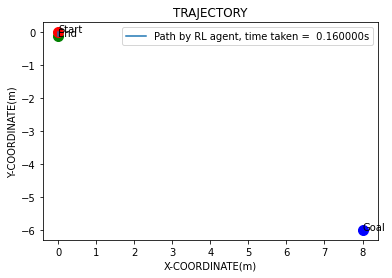

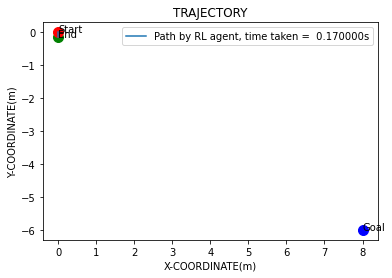

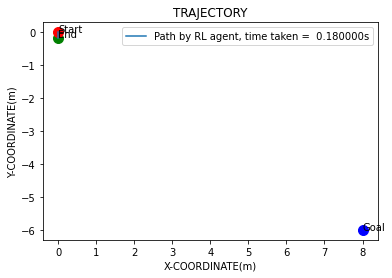

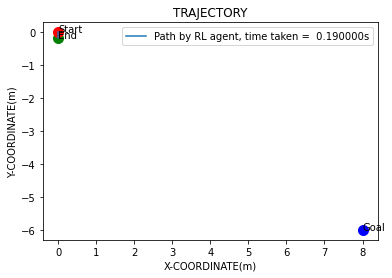

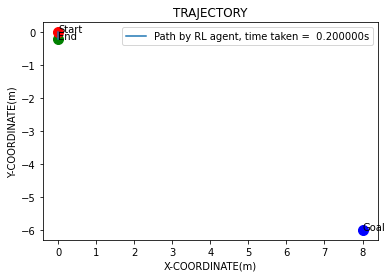

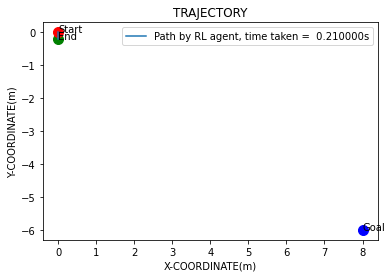

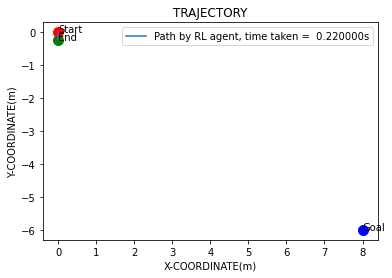

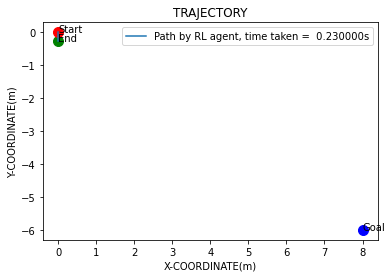

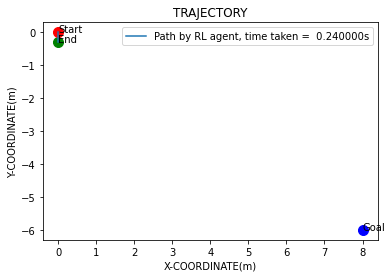

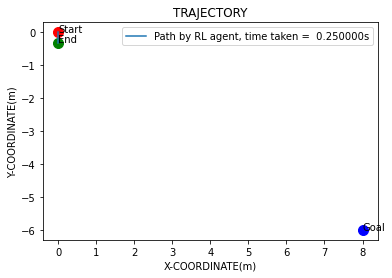

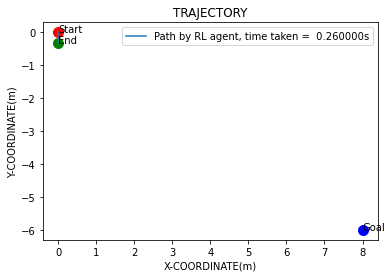

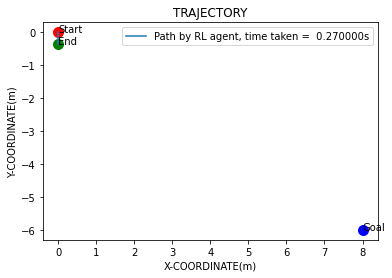

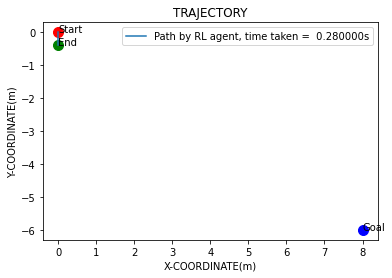

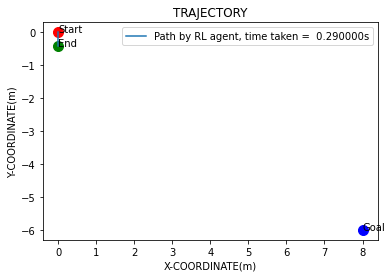

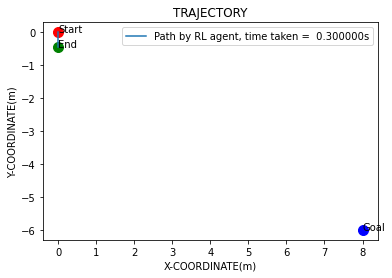

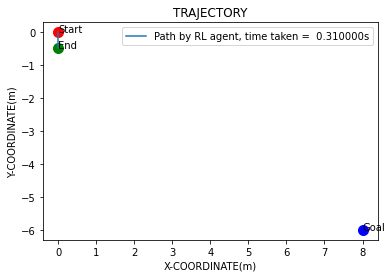

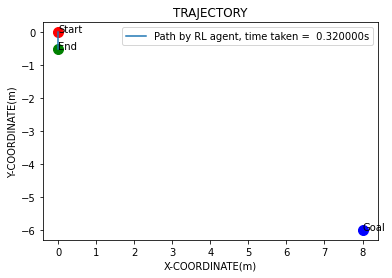

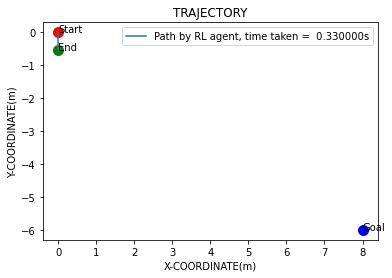

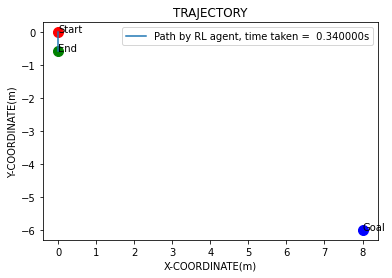

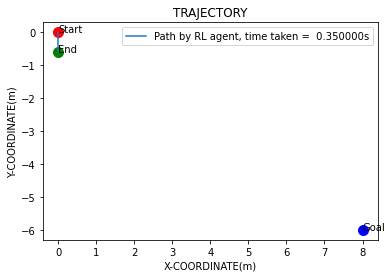

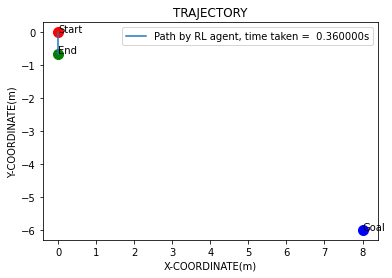

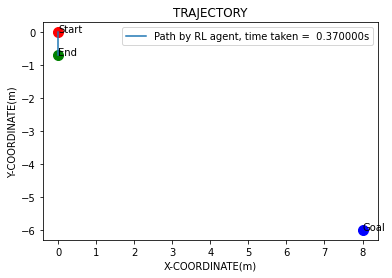

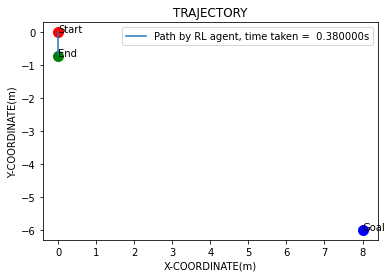

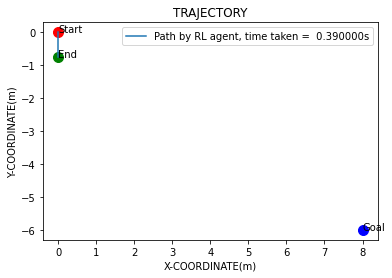

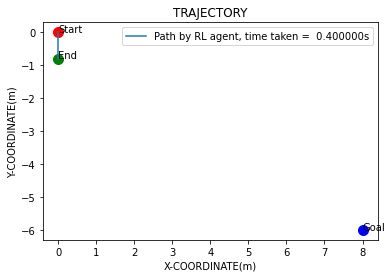

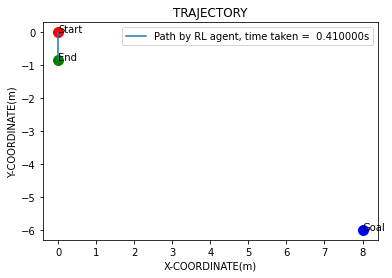

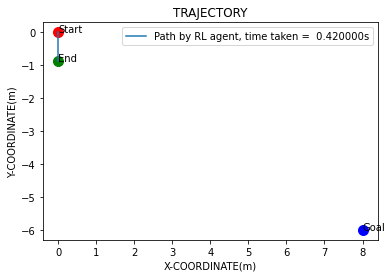

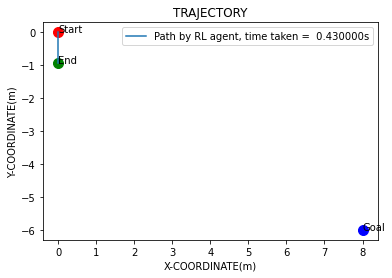

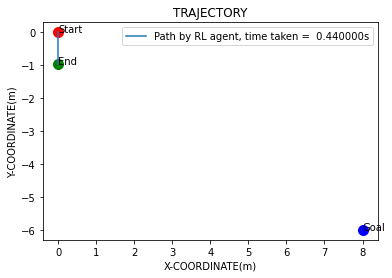

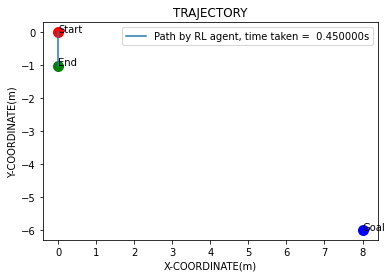

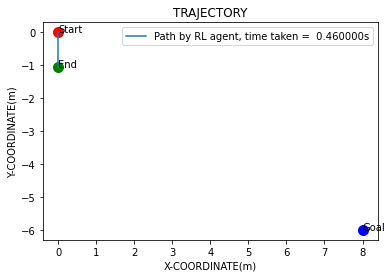

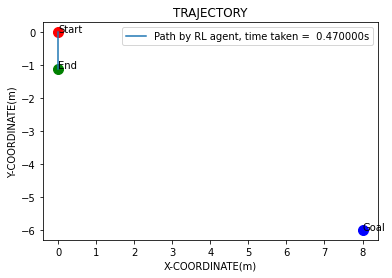

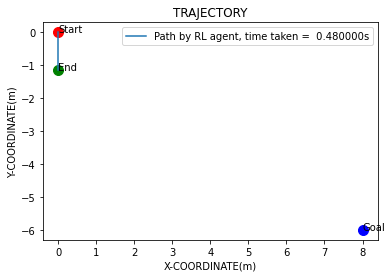

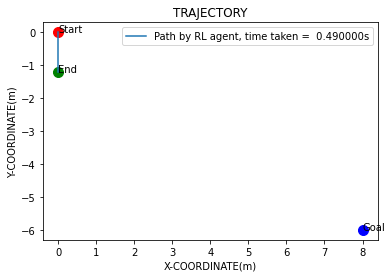

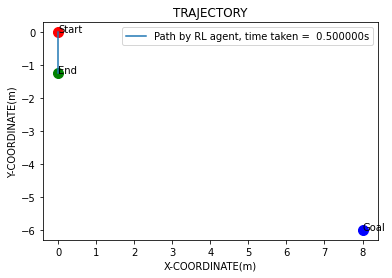

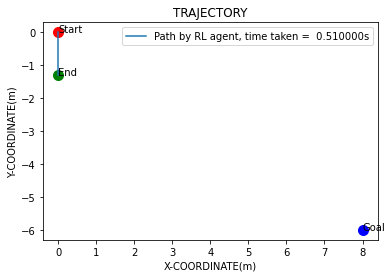

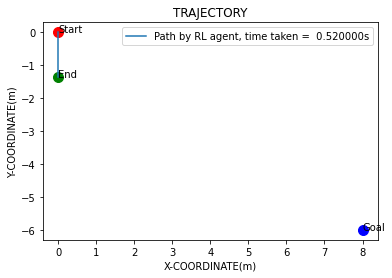

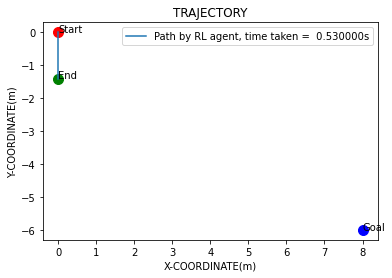

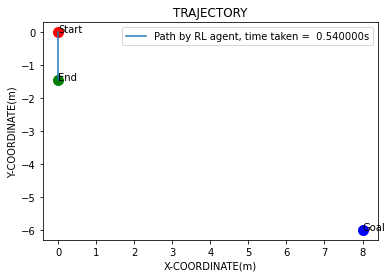

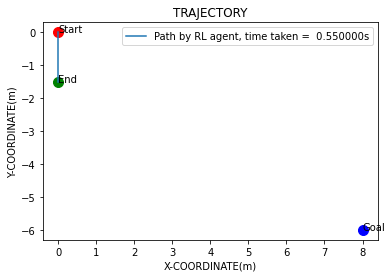

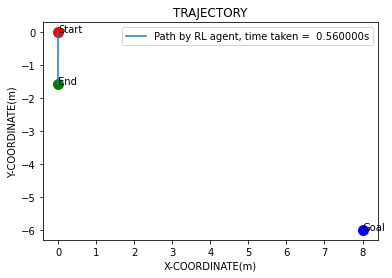

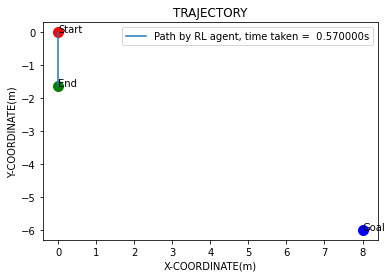

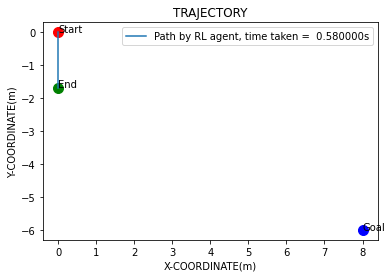

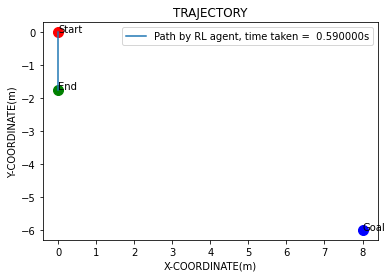

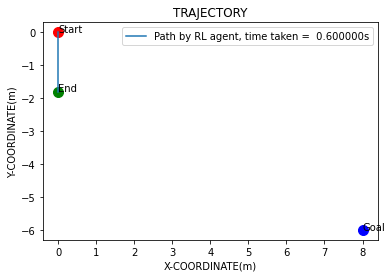

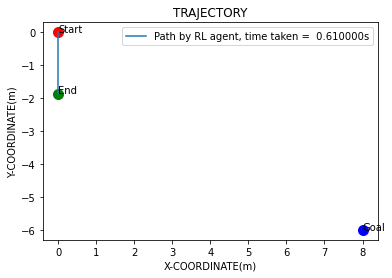

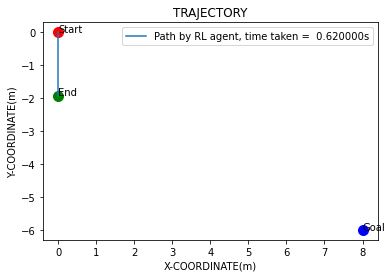

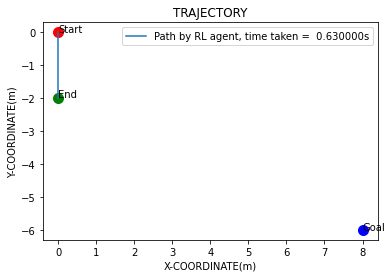

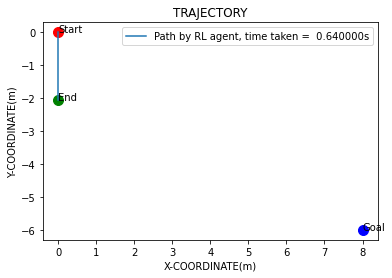

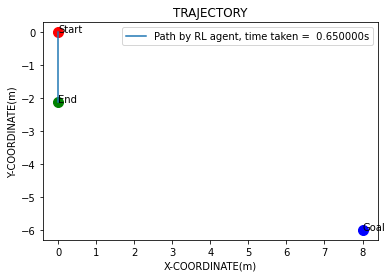

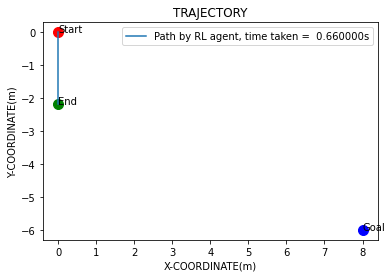

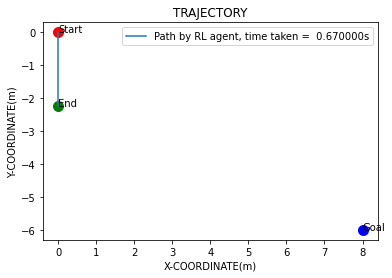

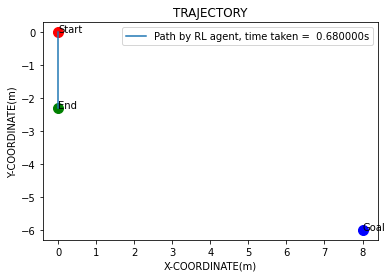

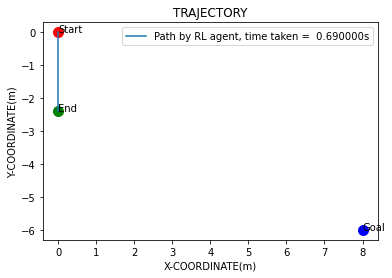

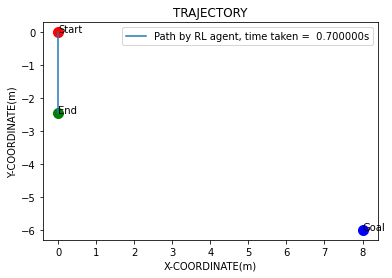

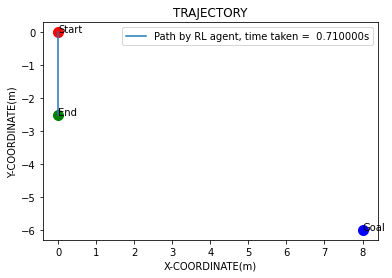

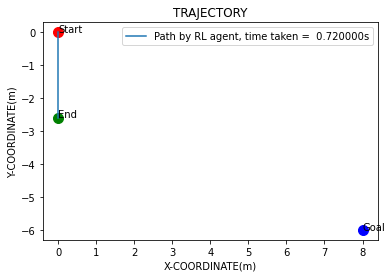

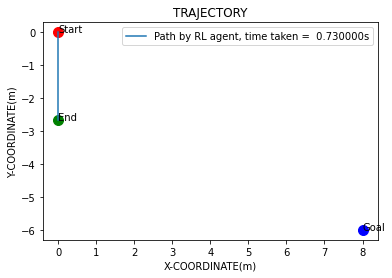

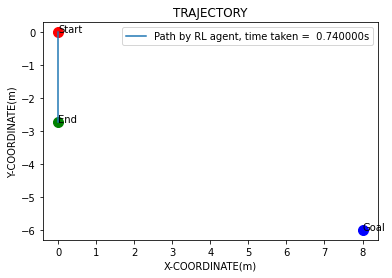

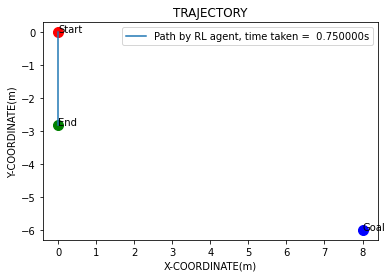

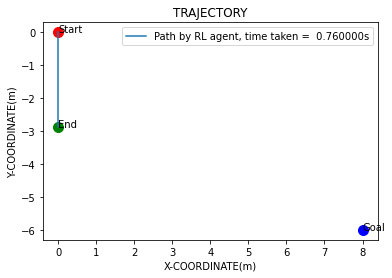

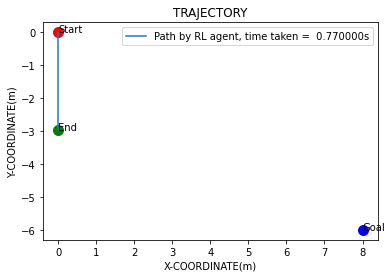

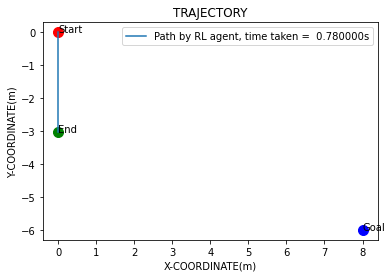

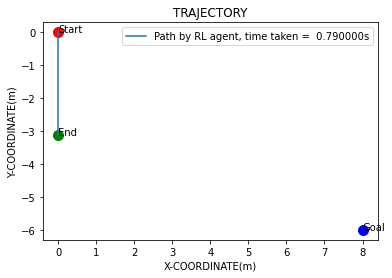

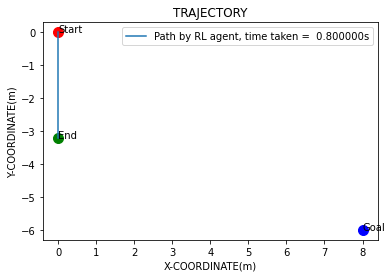

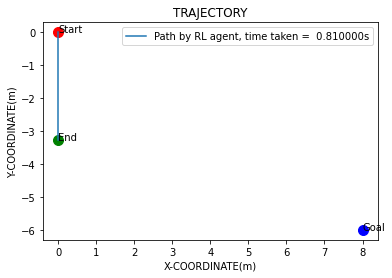

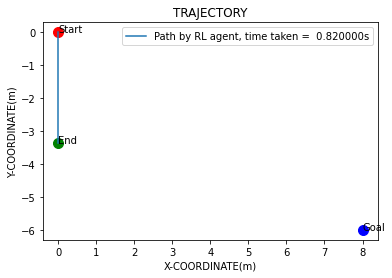

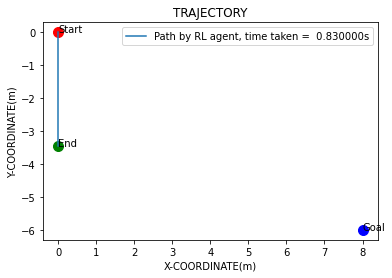

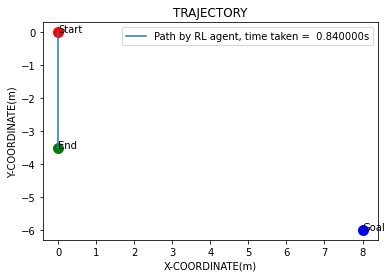

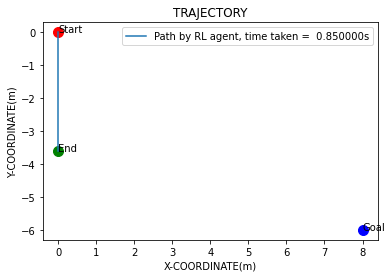

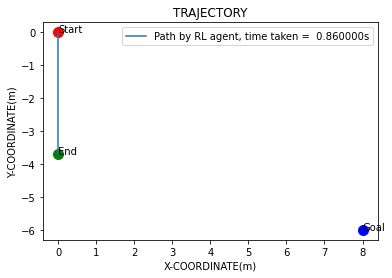

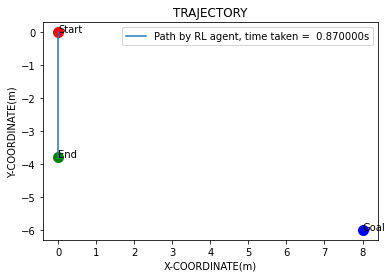

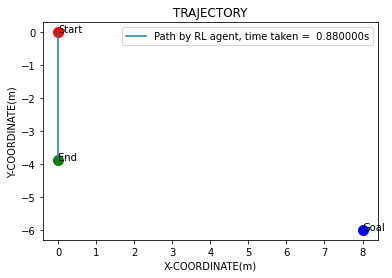

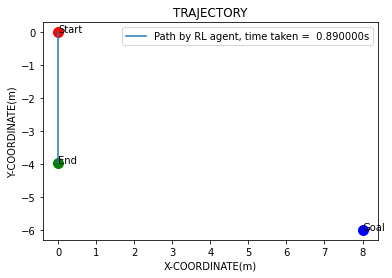

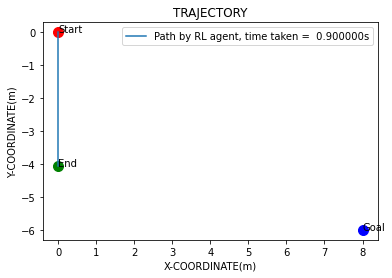

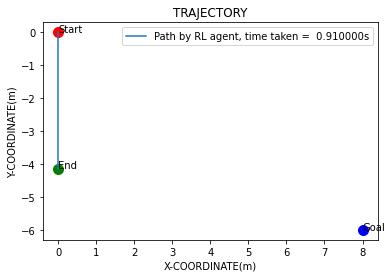

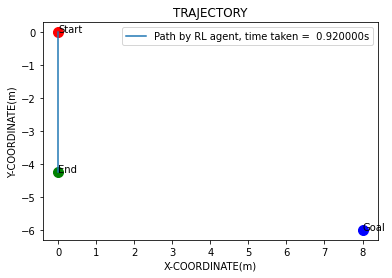

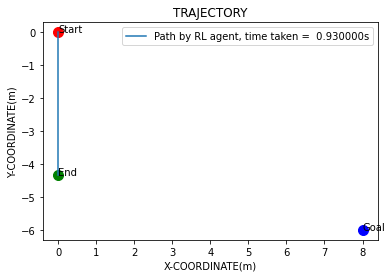

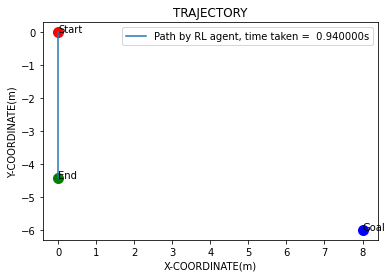

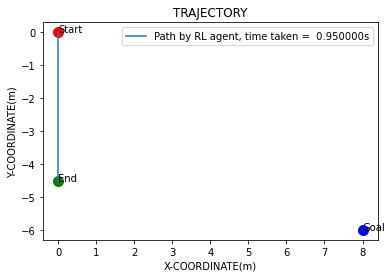

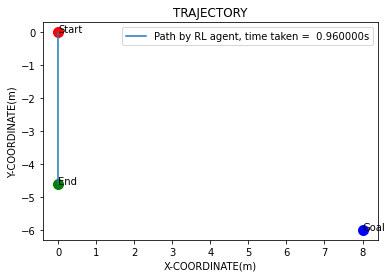

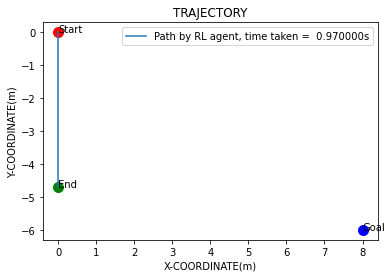

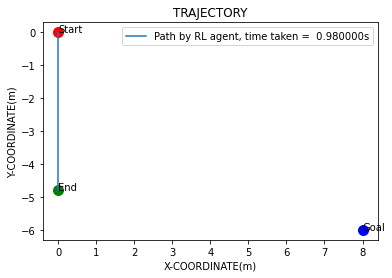

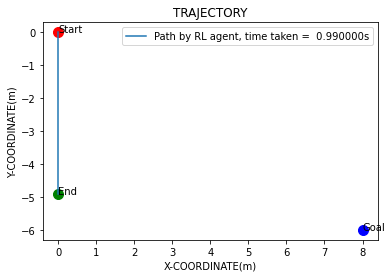

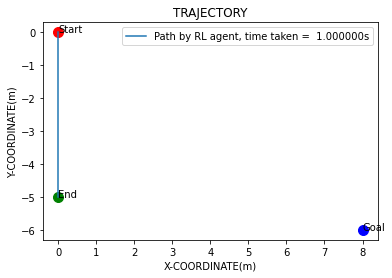

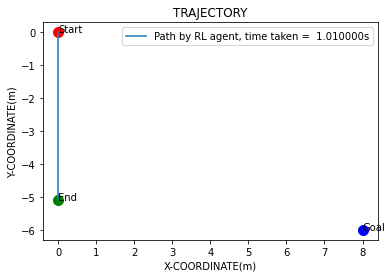

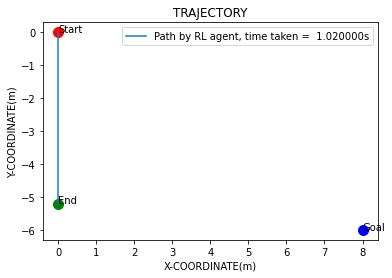

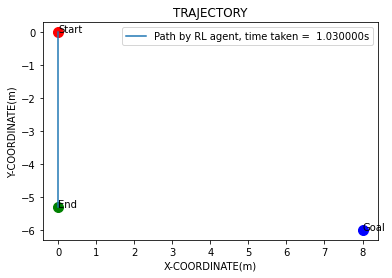

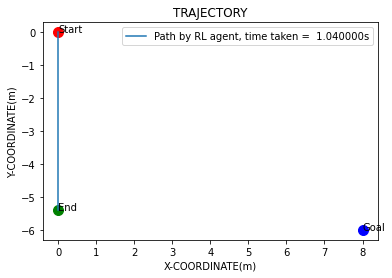

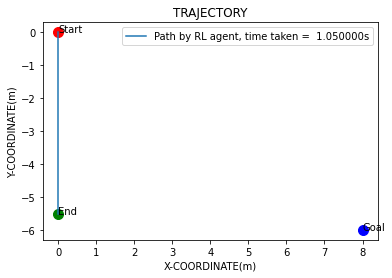

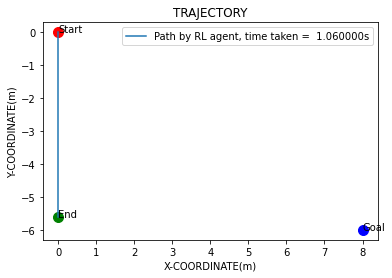

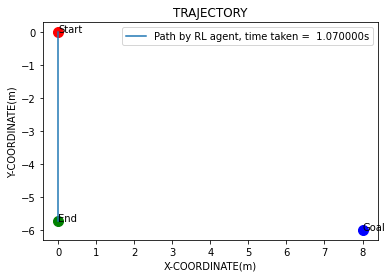

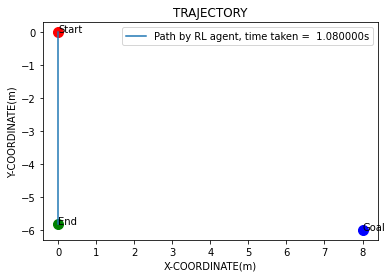

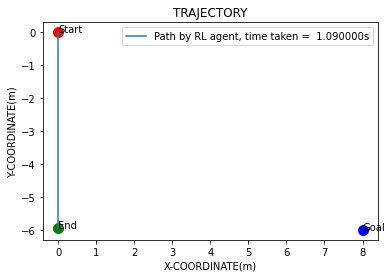

EP_REWARD:-180


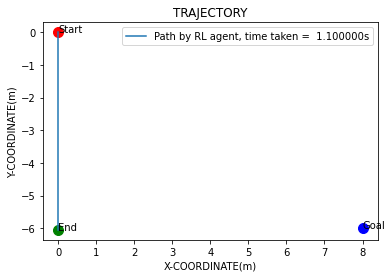

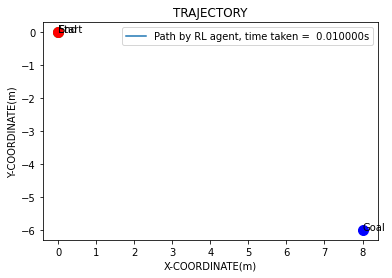

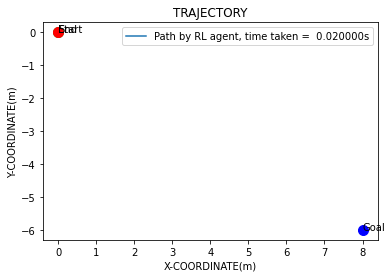

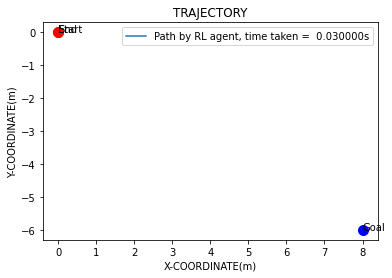

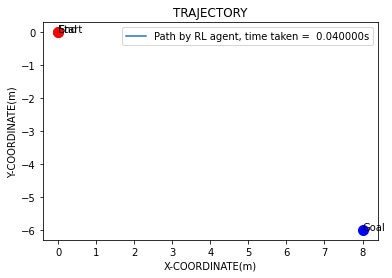

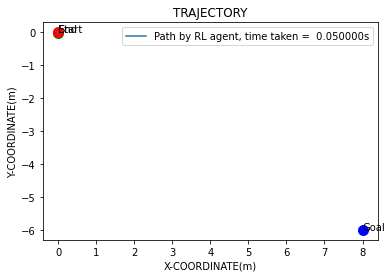

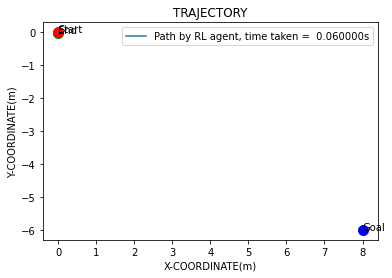

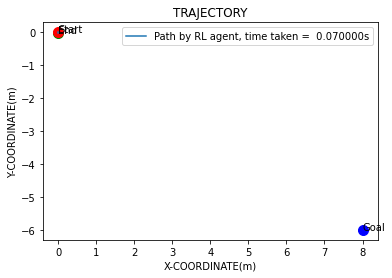

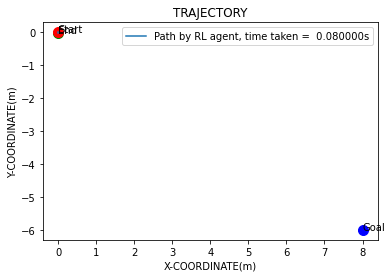

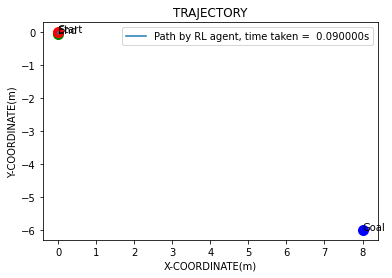

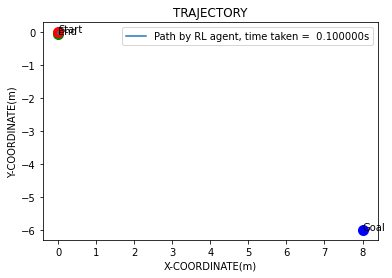

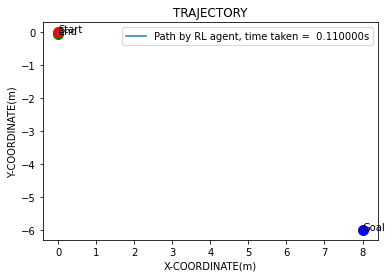

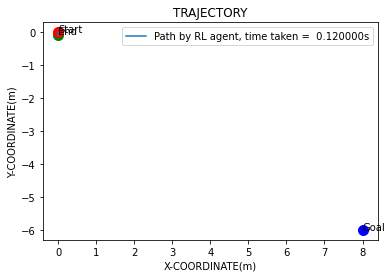

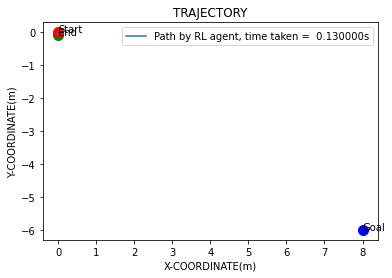

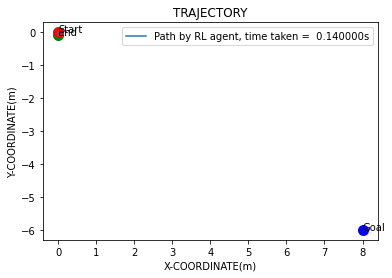

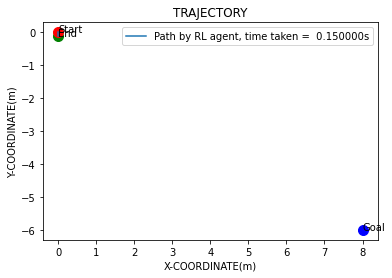

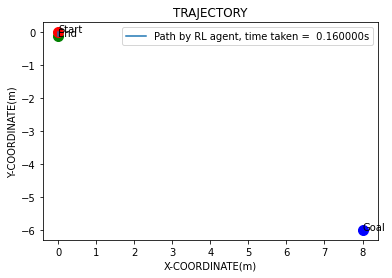

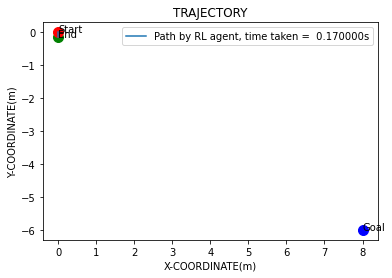

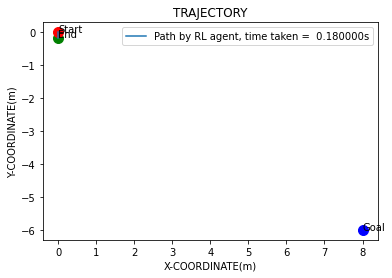

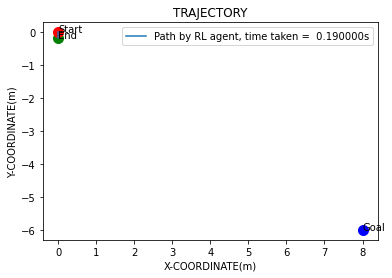

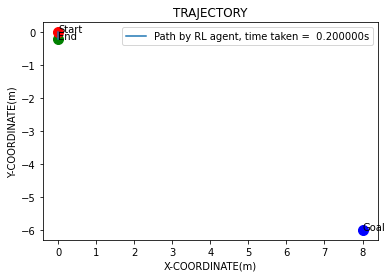

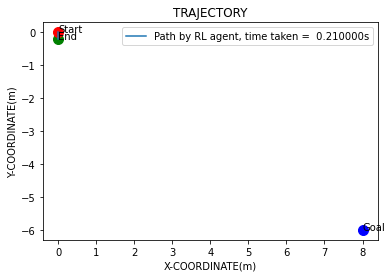

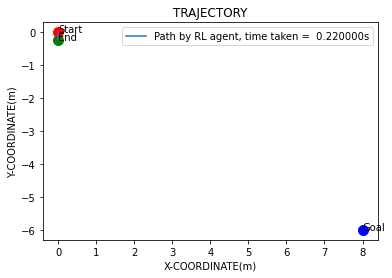

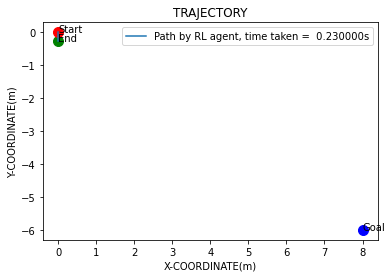

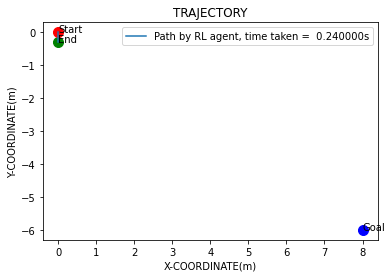

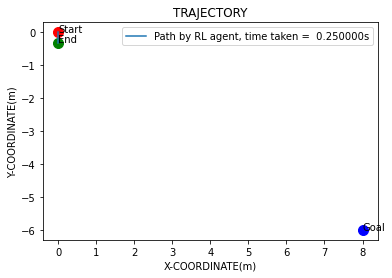

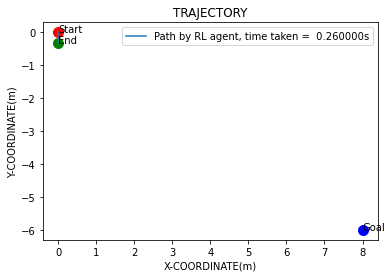

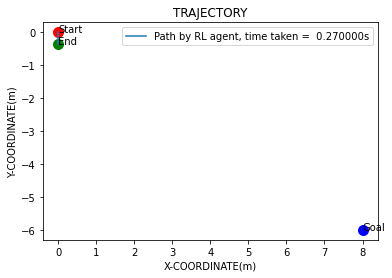

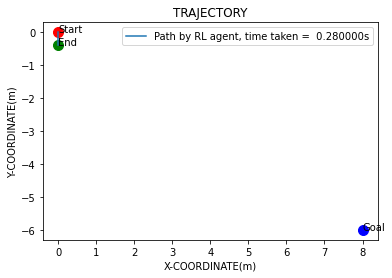

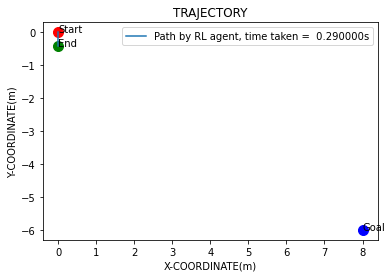

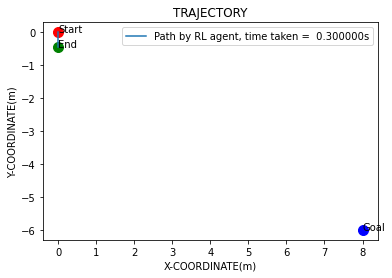

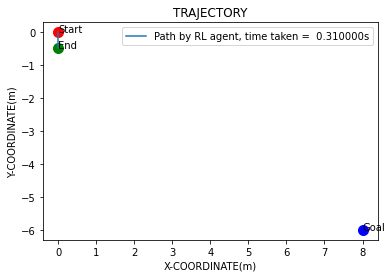

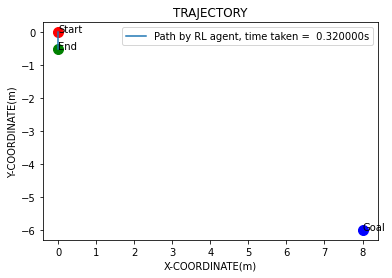

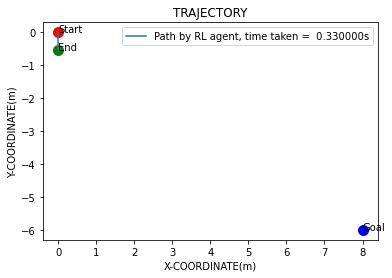

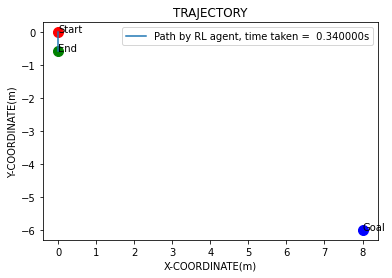

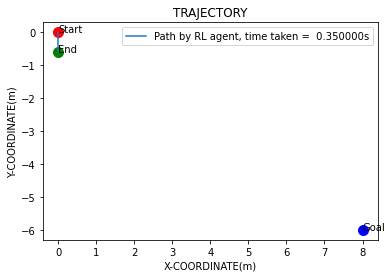

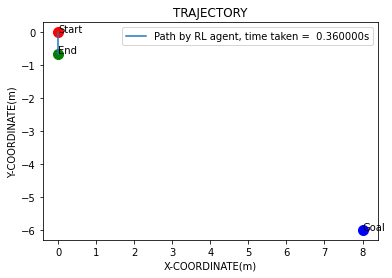

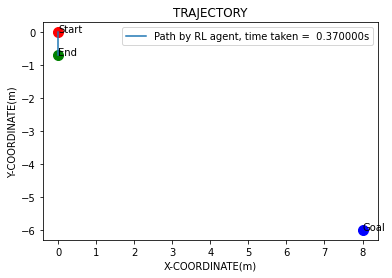

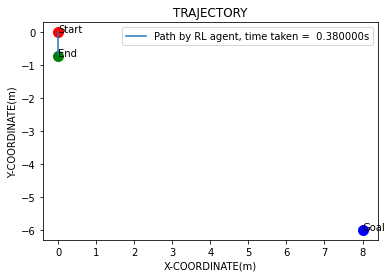

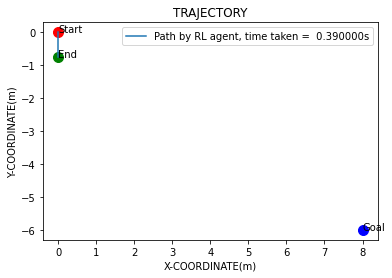

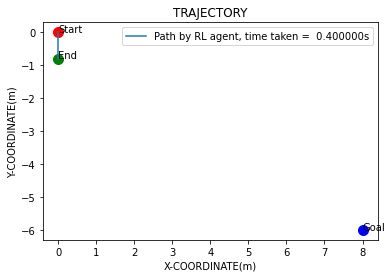

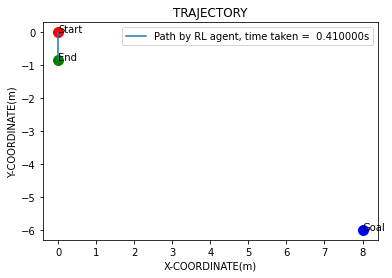

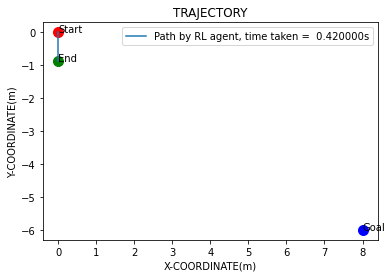

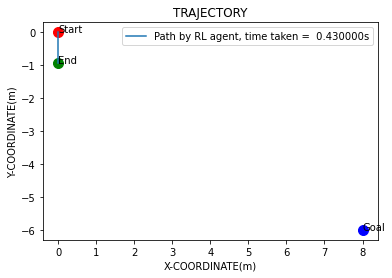

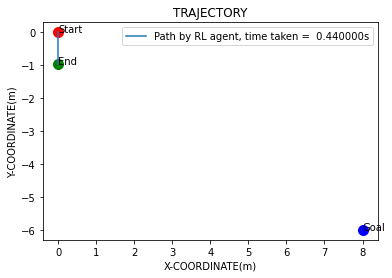

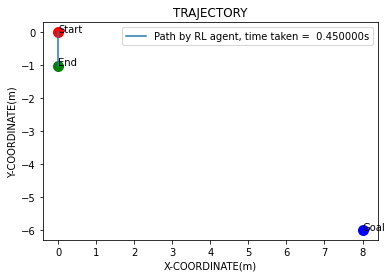

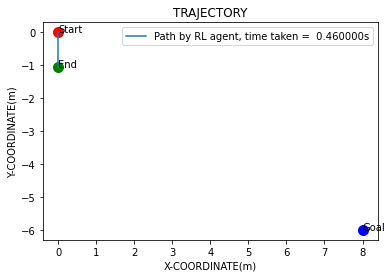

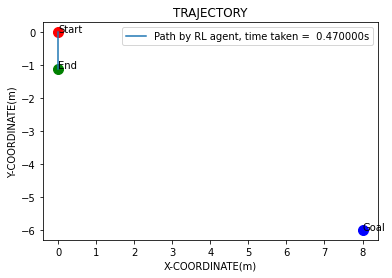

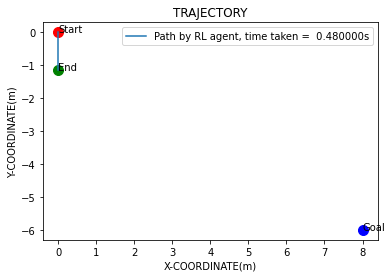

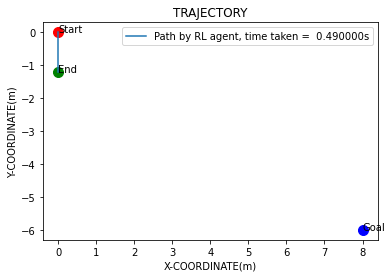

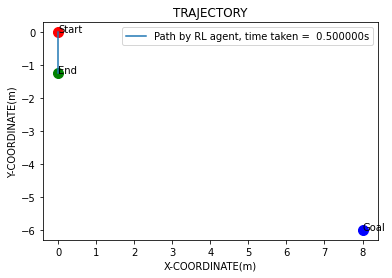

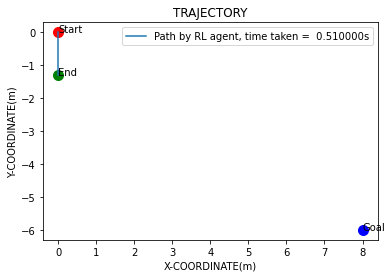

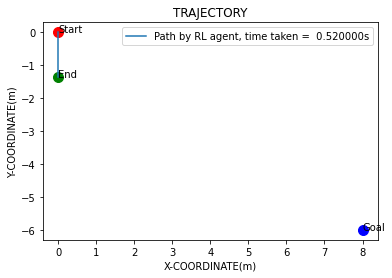

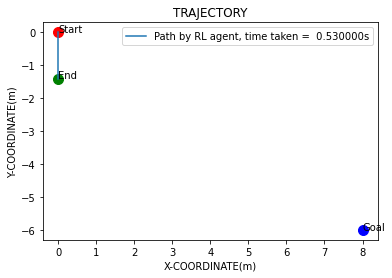

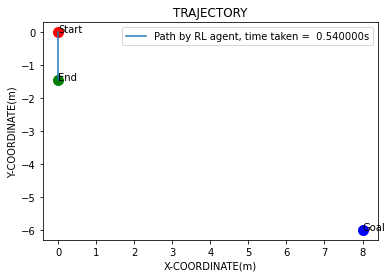

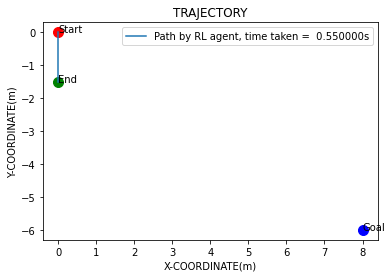

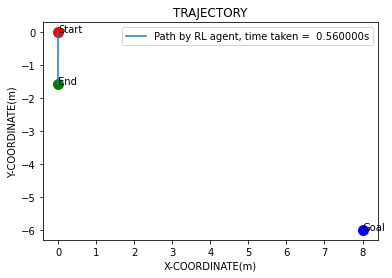

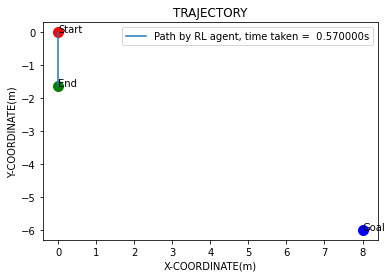

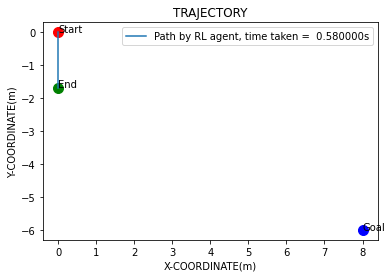

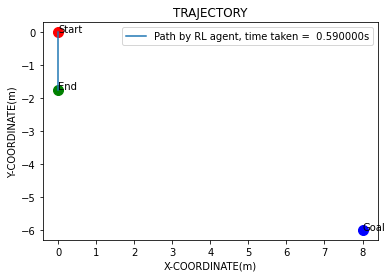

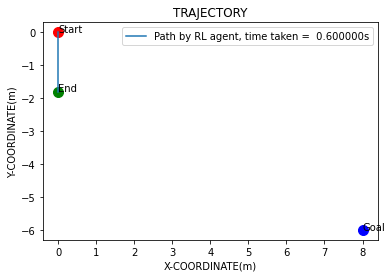

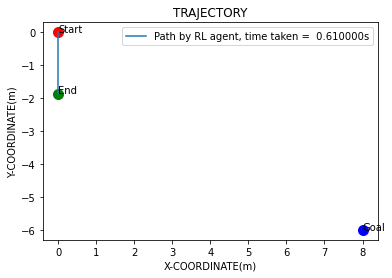

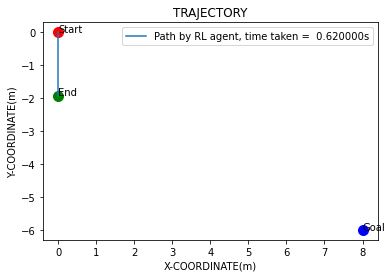

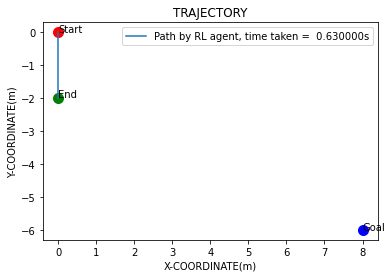

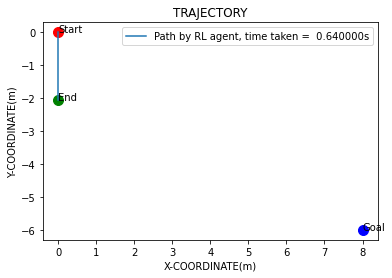

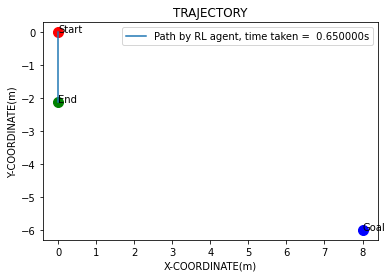

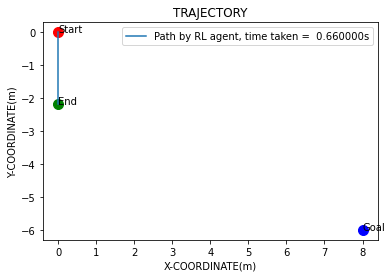

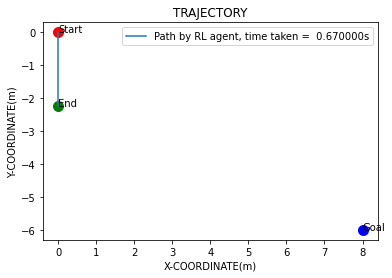

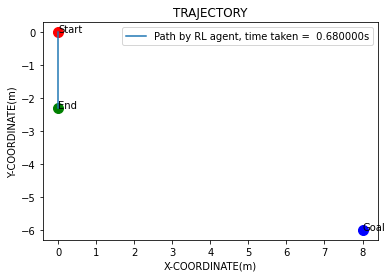

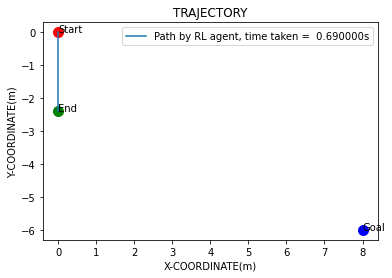

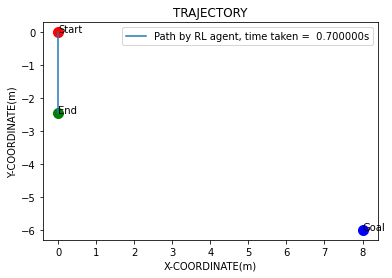

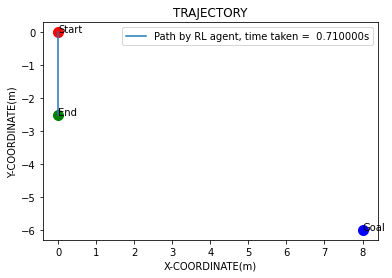

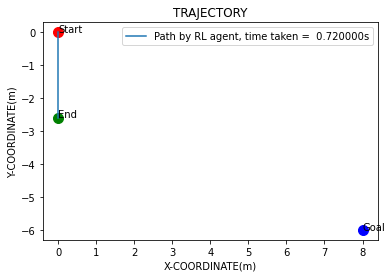

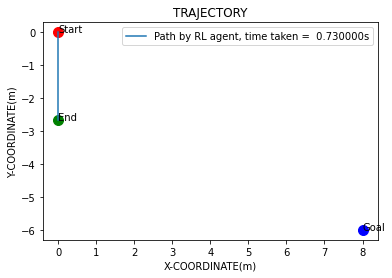

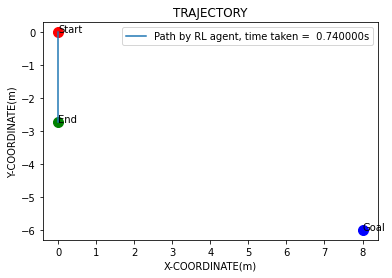

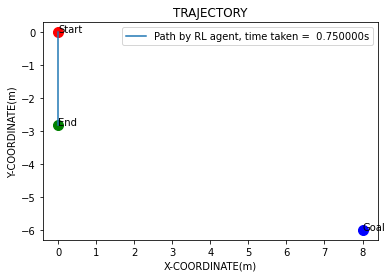

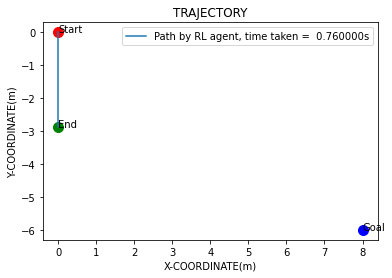

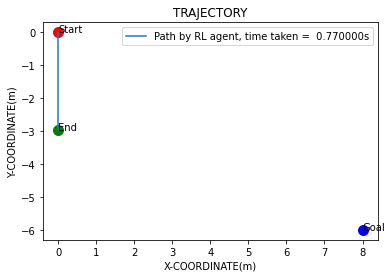

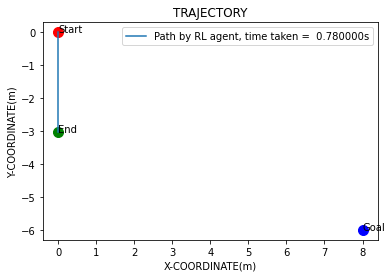

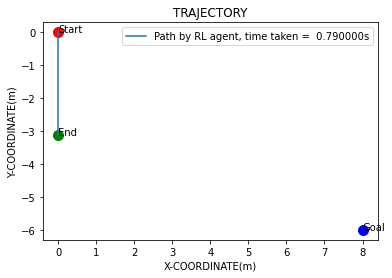

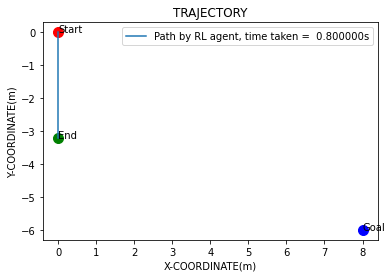

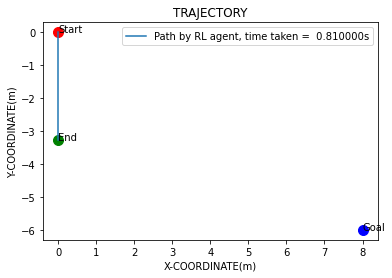

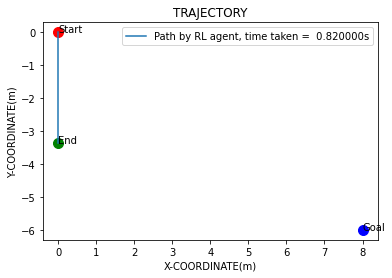

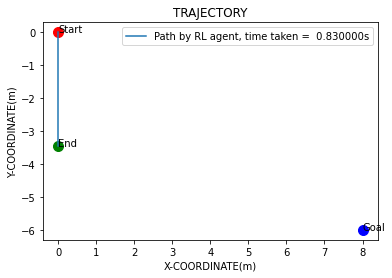

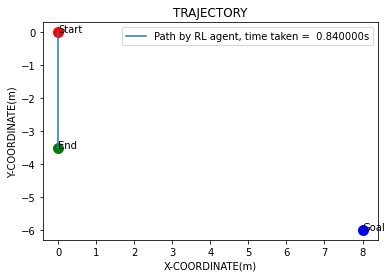

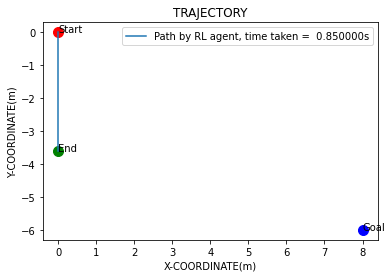

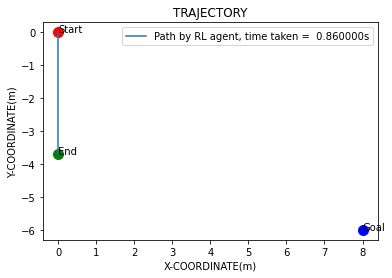

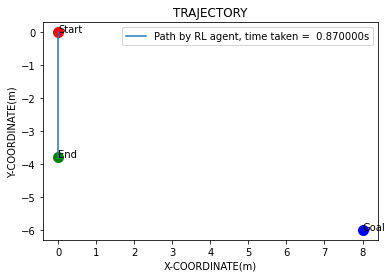

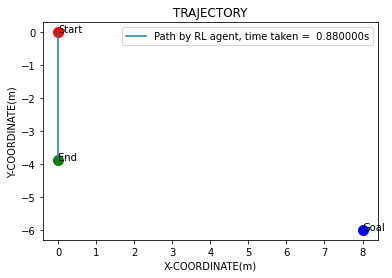

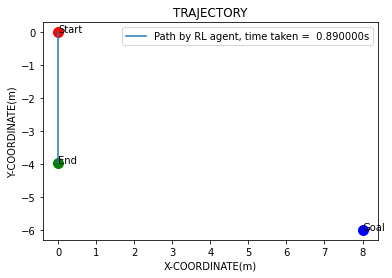

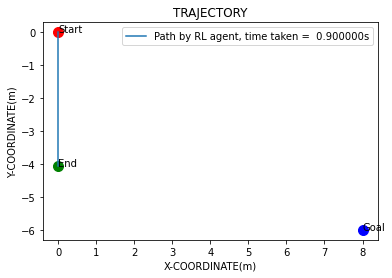

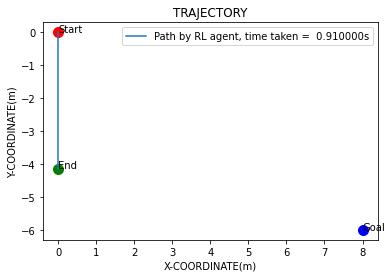

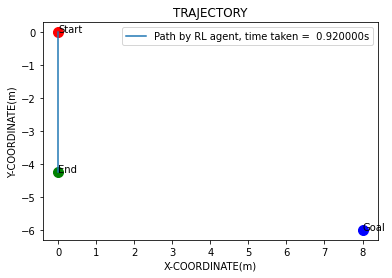

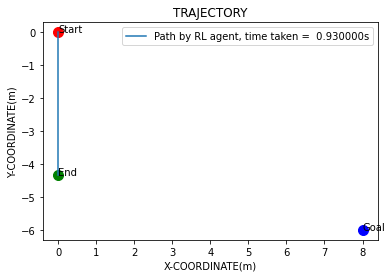

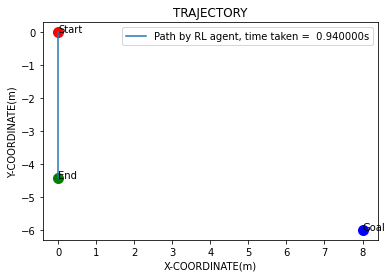

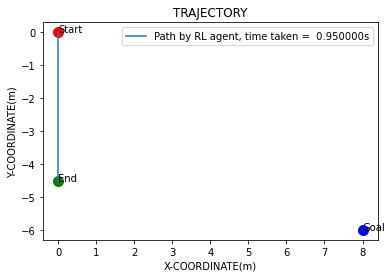

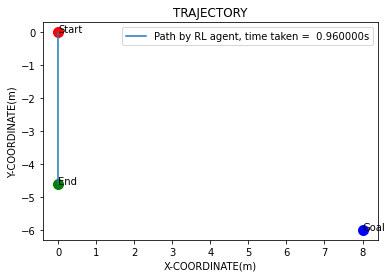

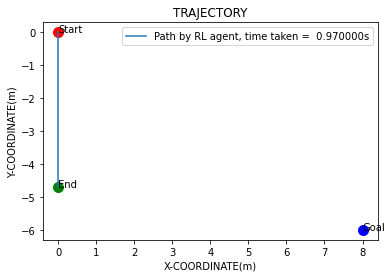

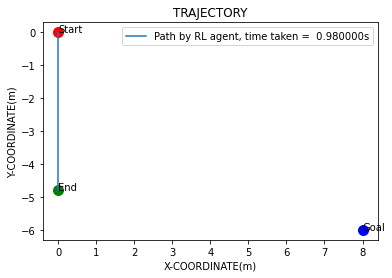

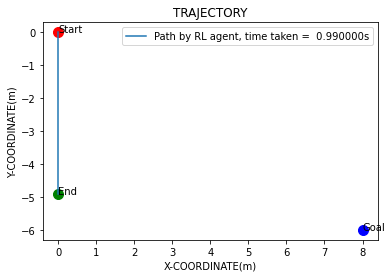

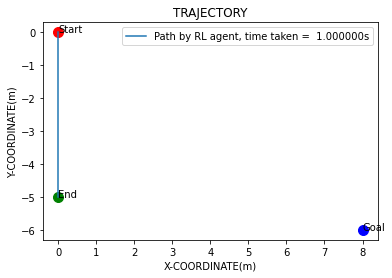

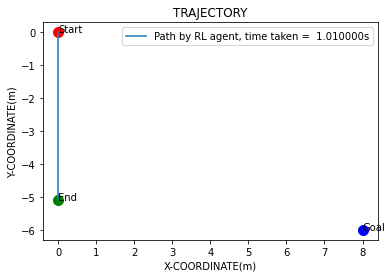

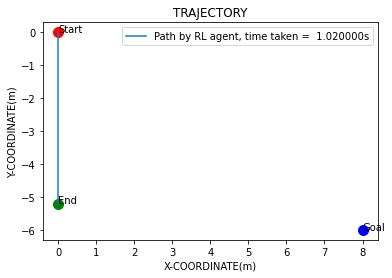

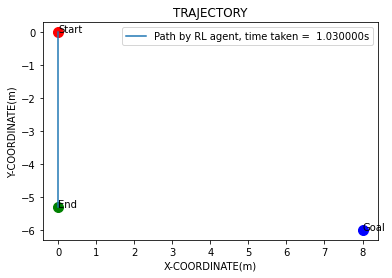

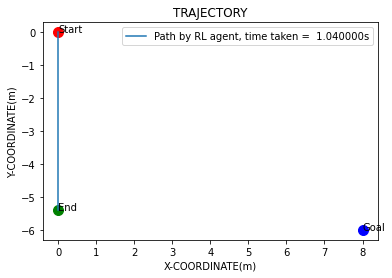

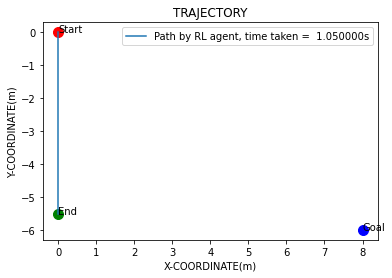

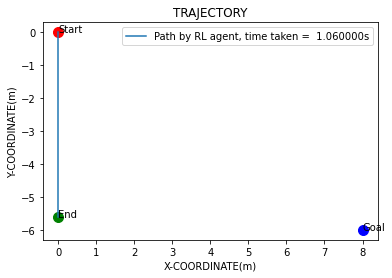

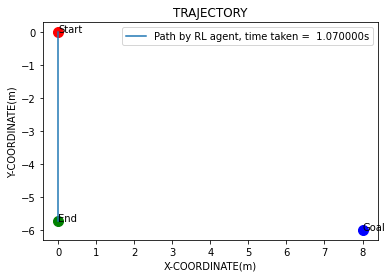

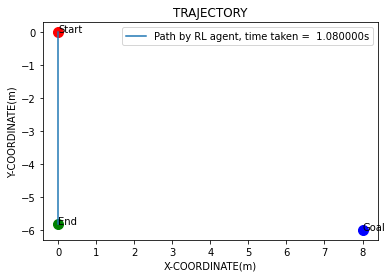

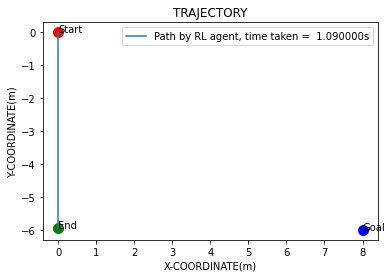

EP_REWARD:-180


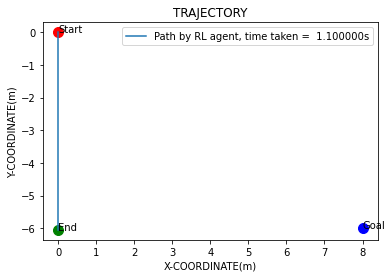

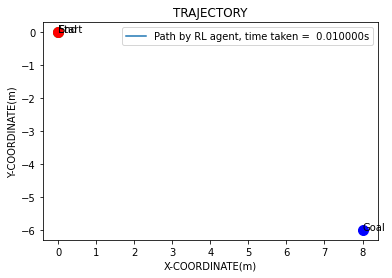

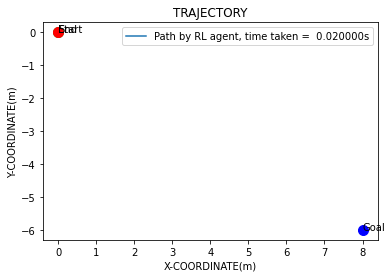

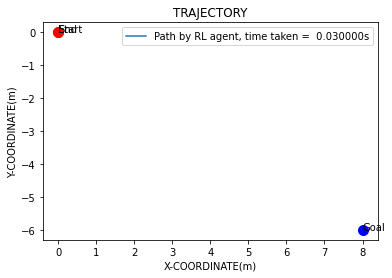

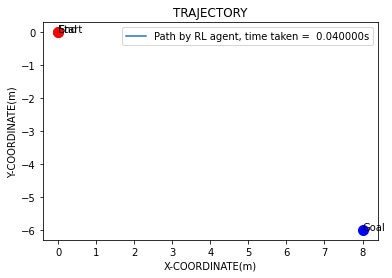

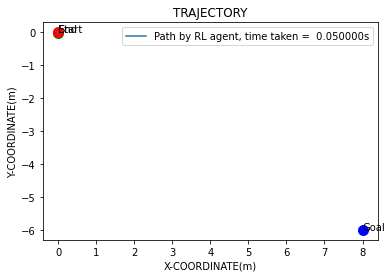

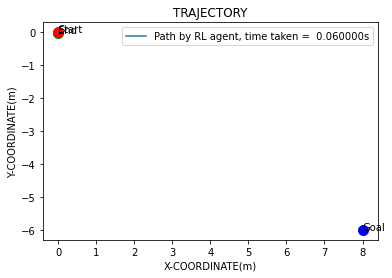

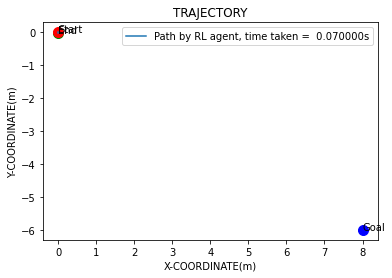

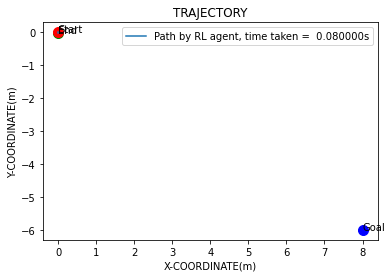

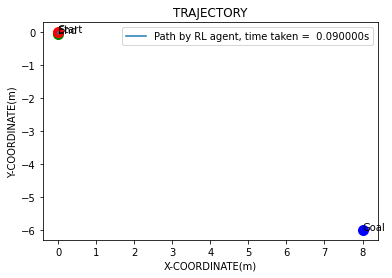

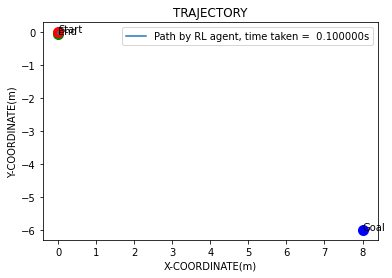

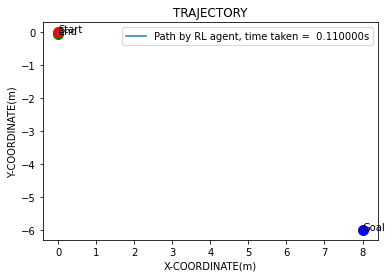

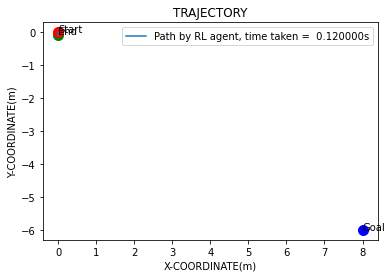

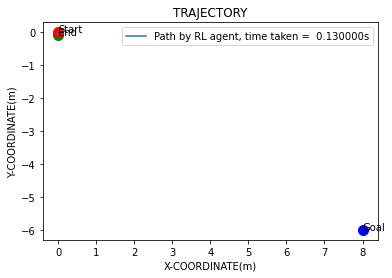

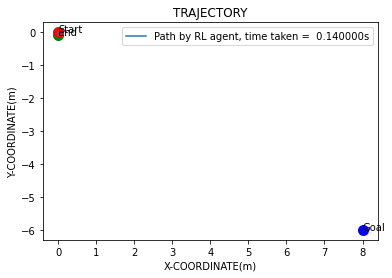

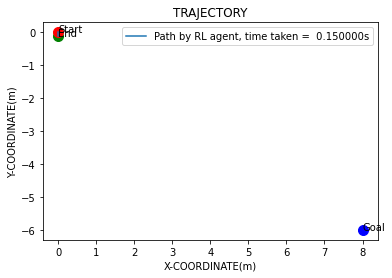

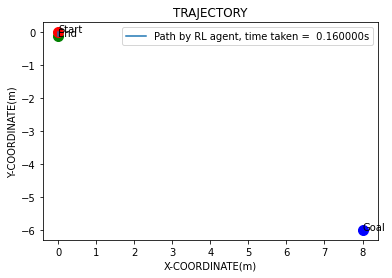

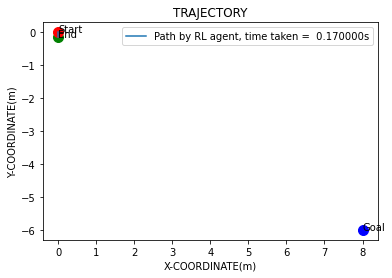

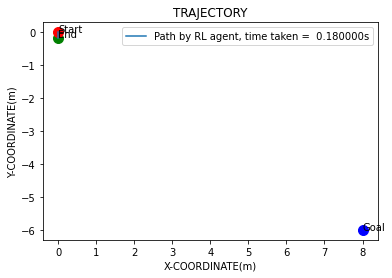

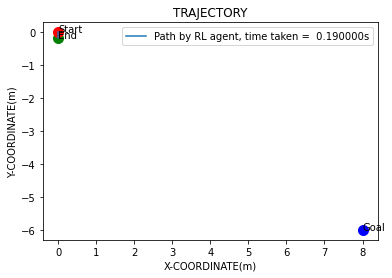

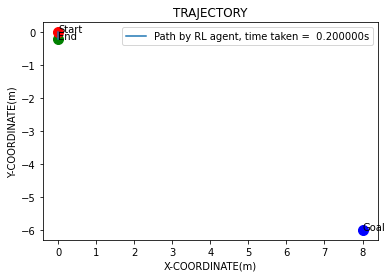

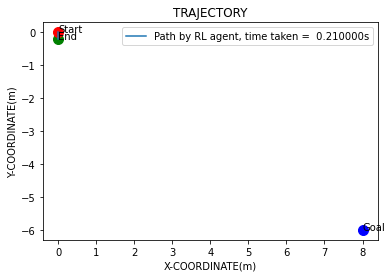

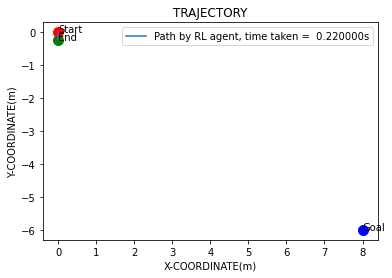

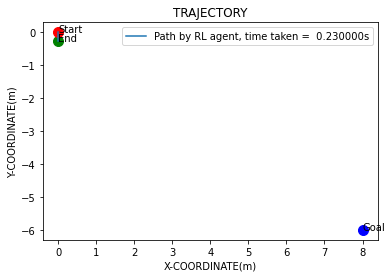

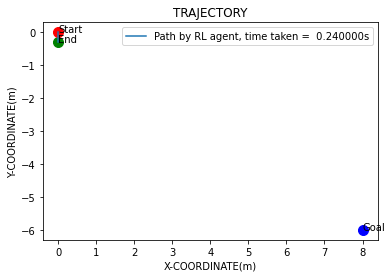

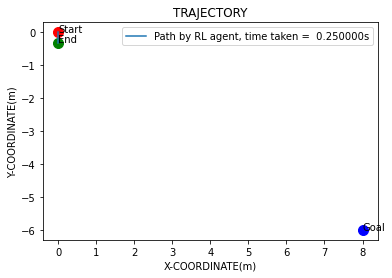

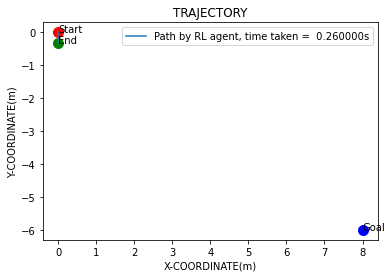

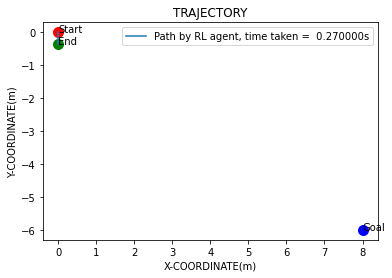

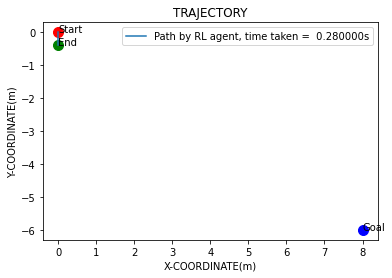

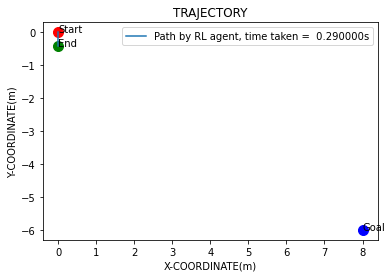

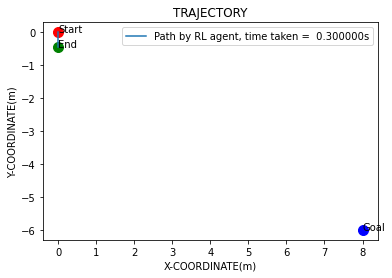

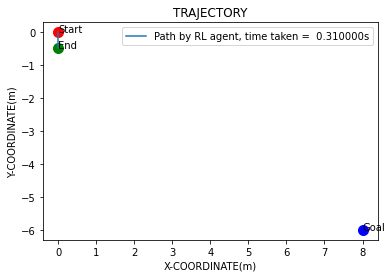

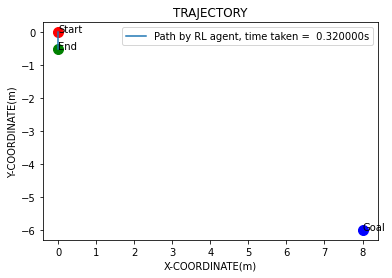

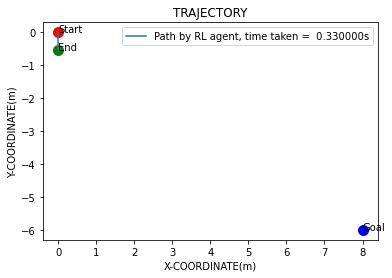

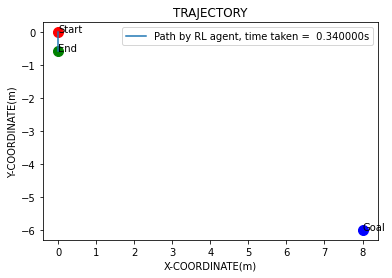

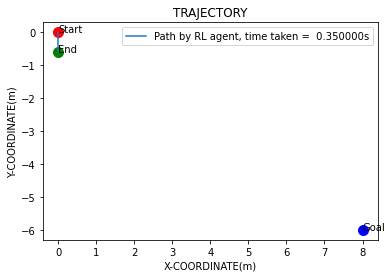

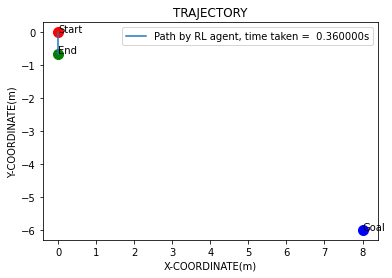

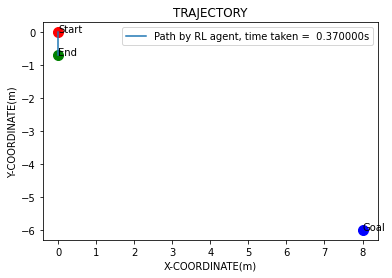

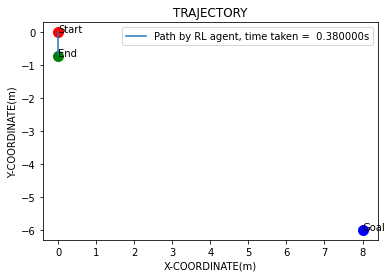

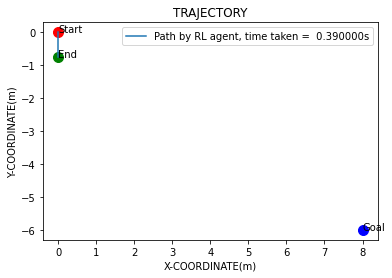

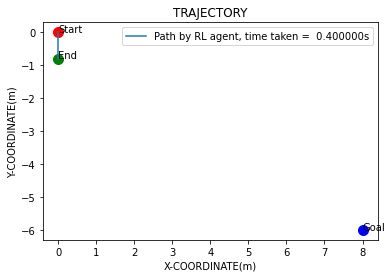

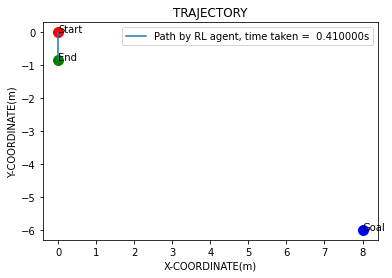

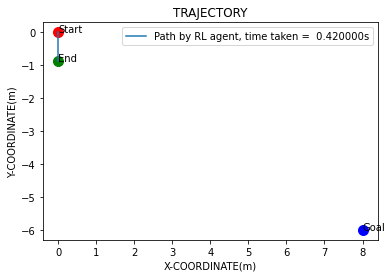

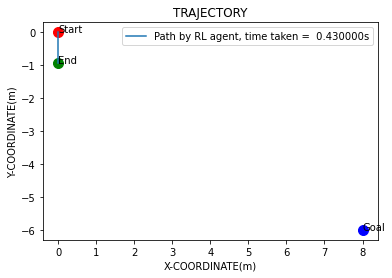

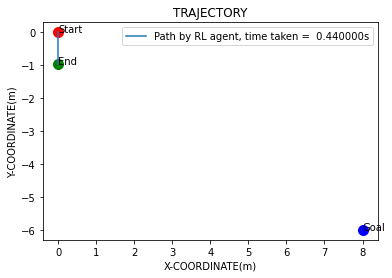

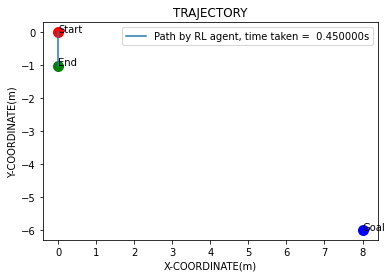

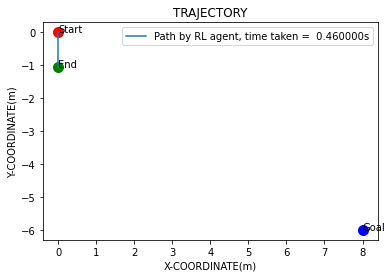

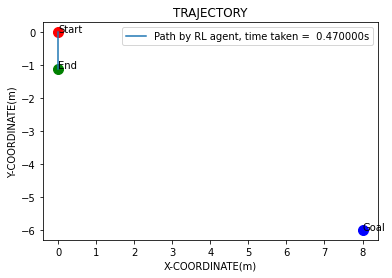

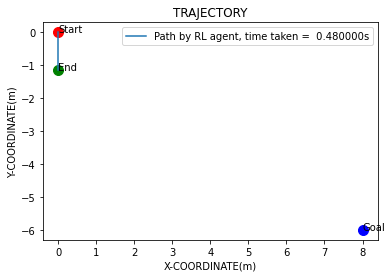

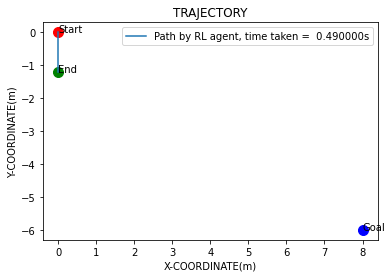

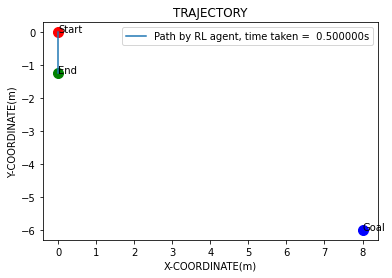

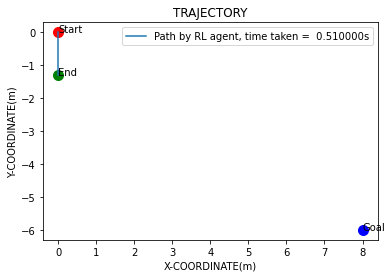

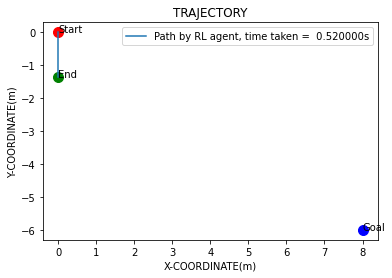

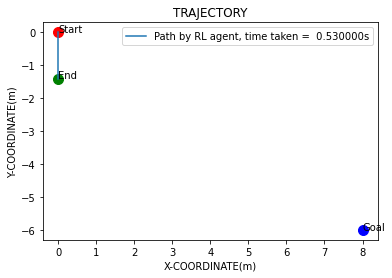

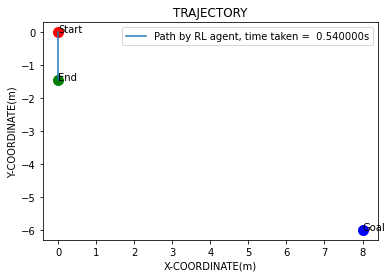

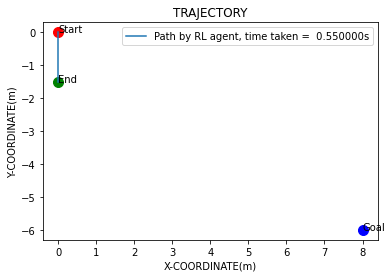

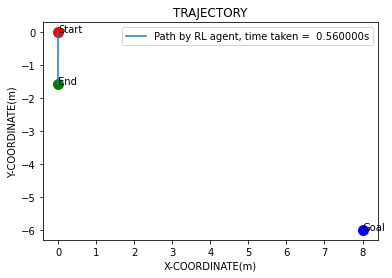

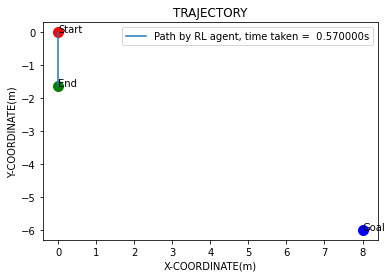

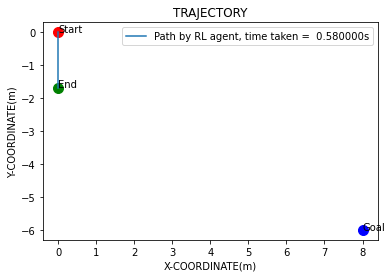

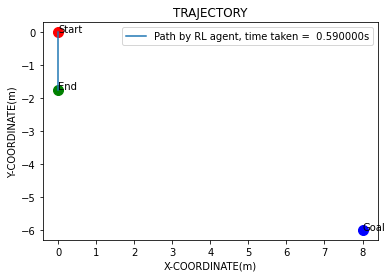

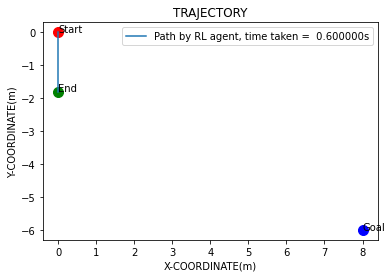

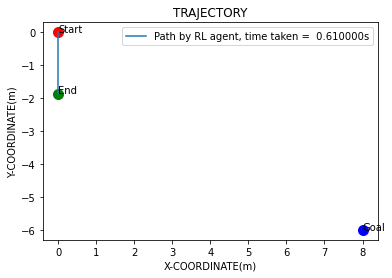

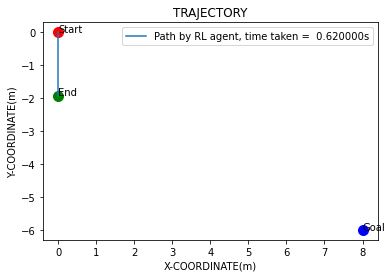

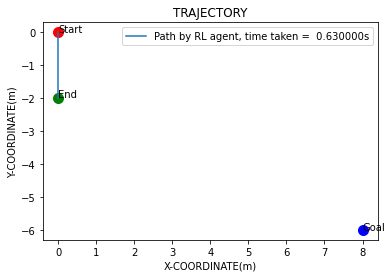

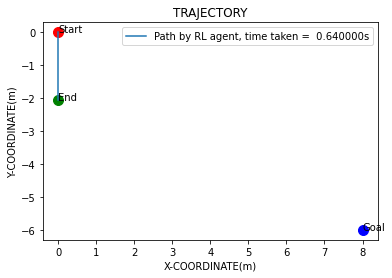

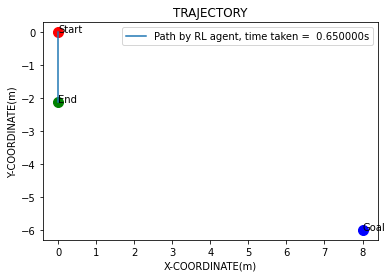

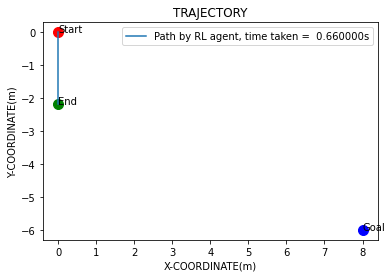

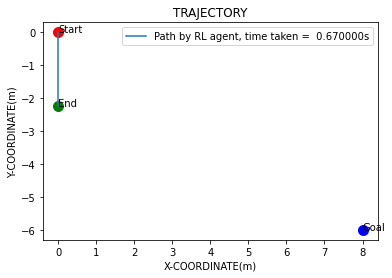

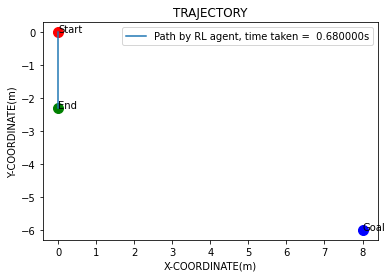

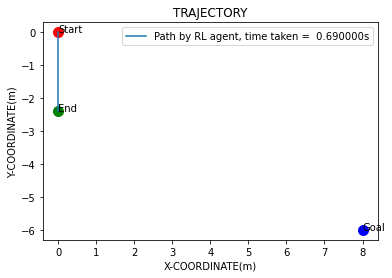

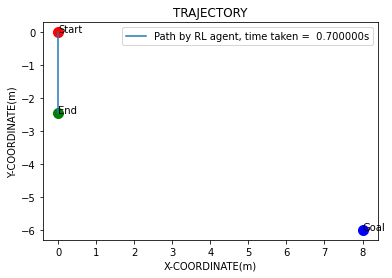

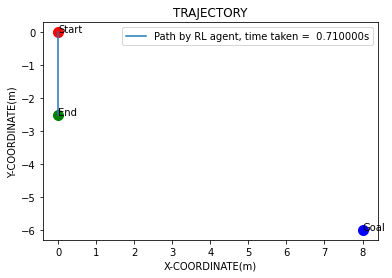

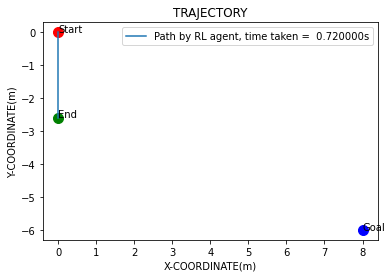

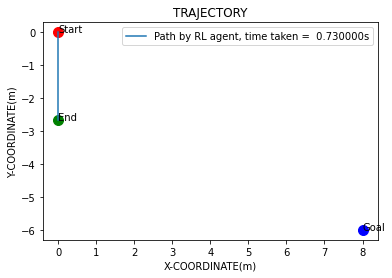

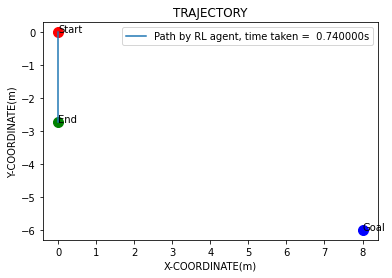

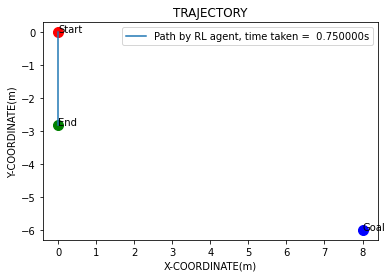

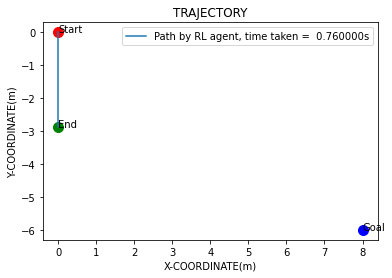

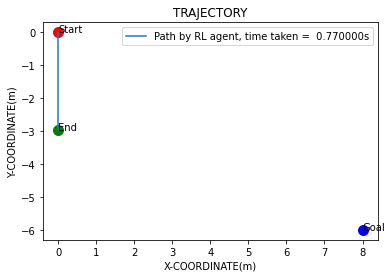

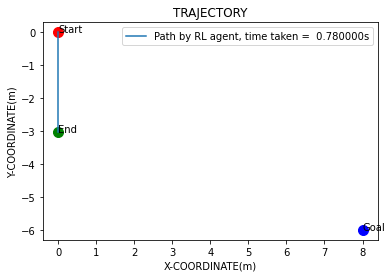

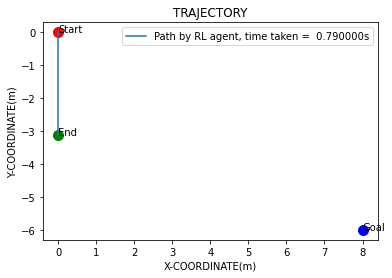

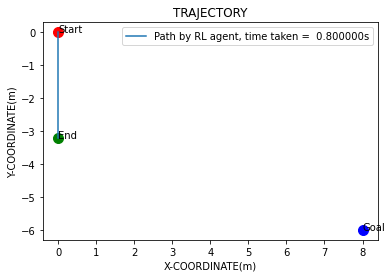

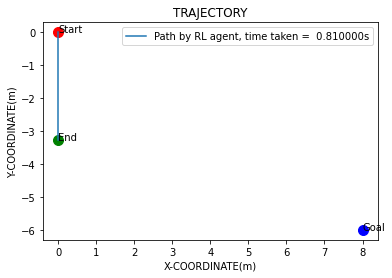

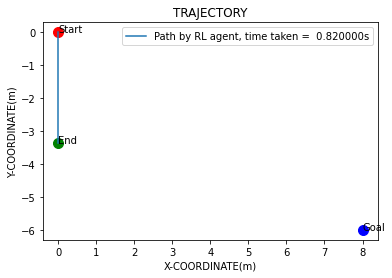

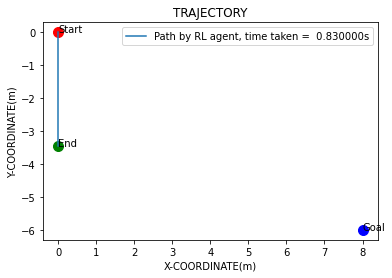

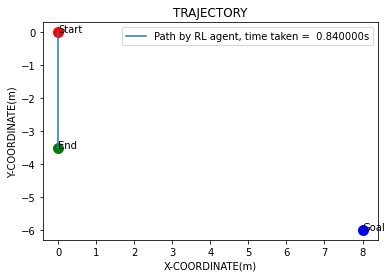

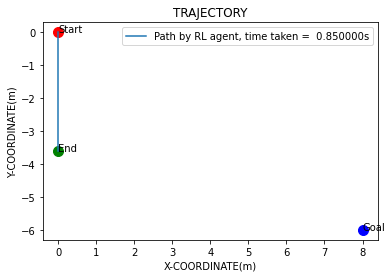

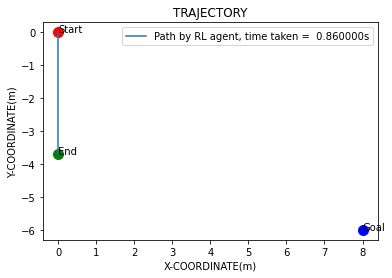

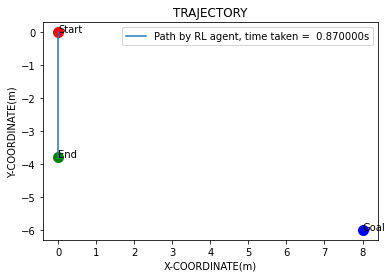

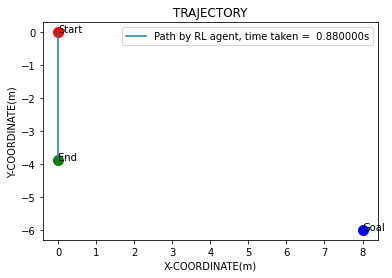

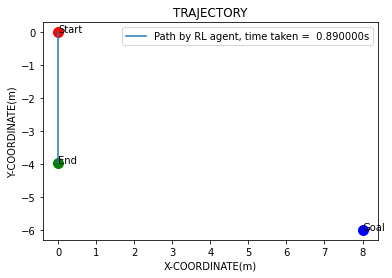

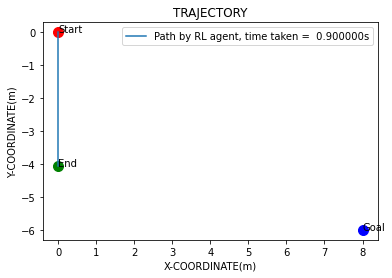

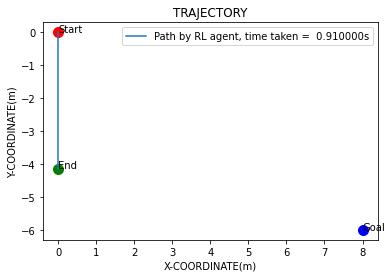

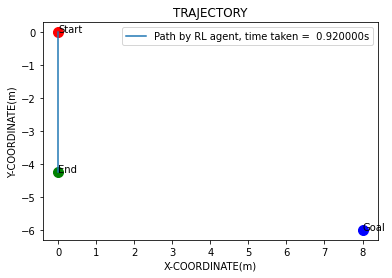

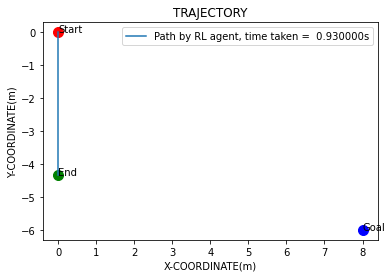

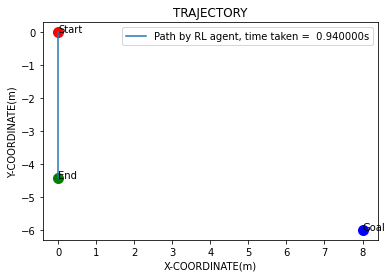

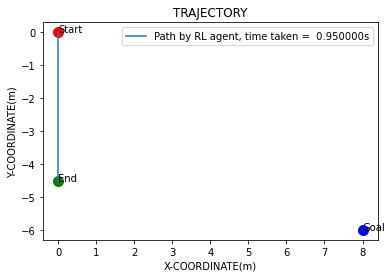

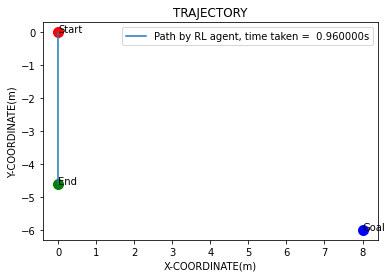

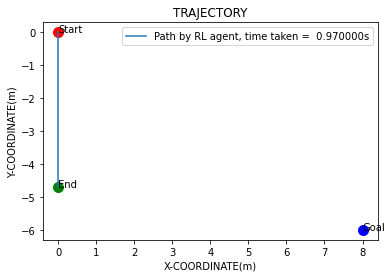

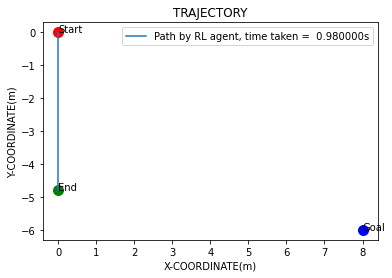

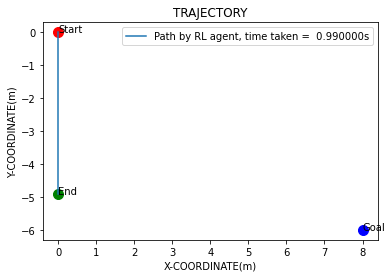

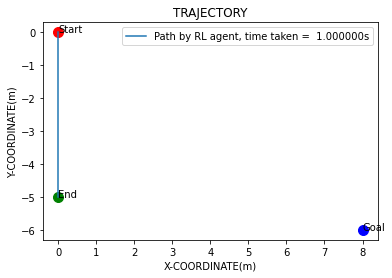

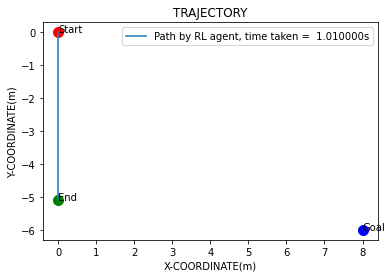

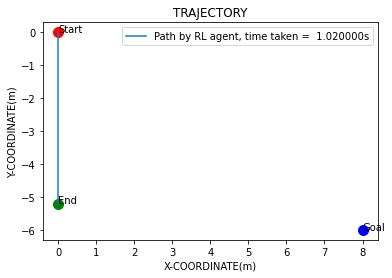

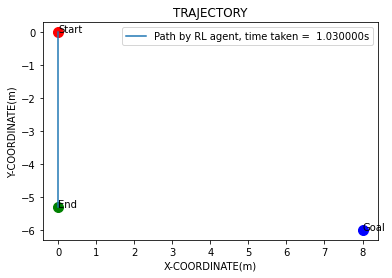

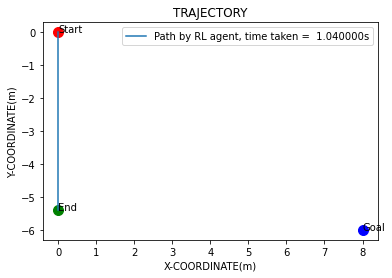

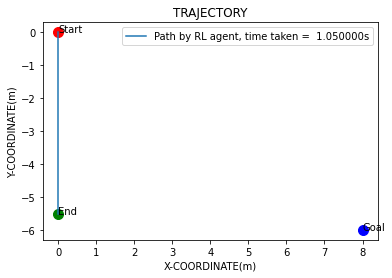

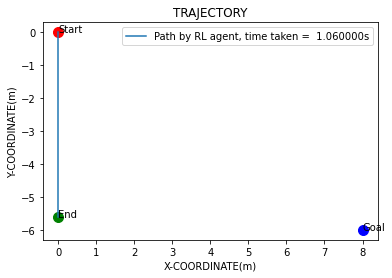

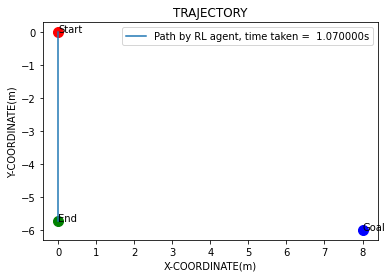

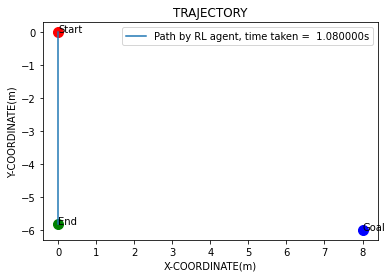

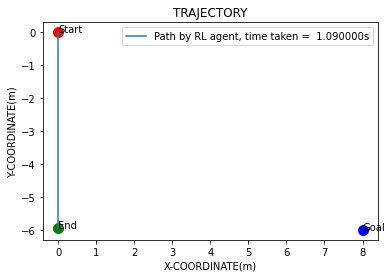

EP_REWARD:-180


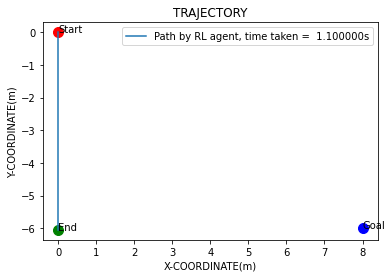

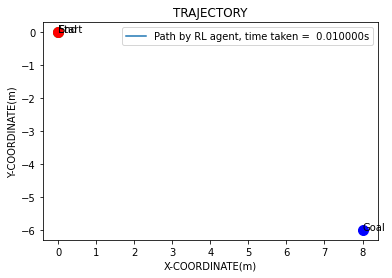

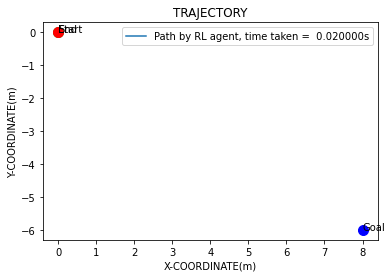

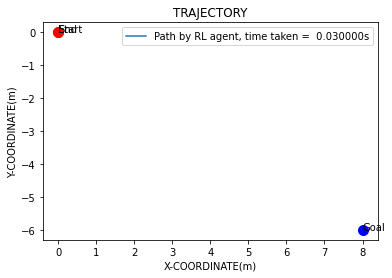

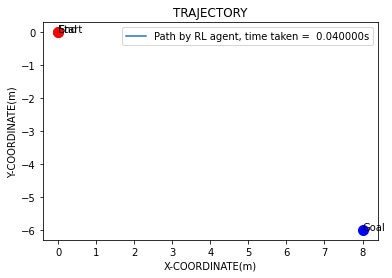

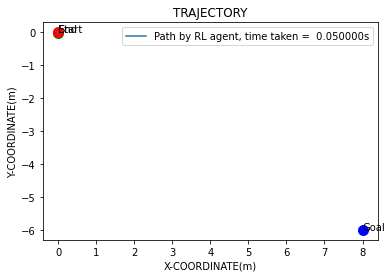

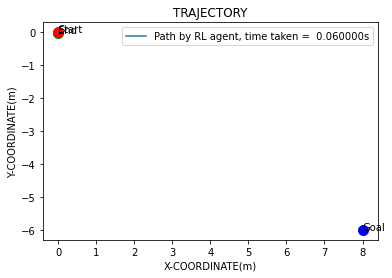

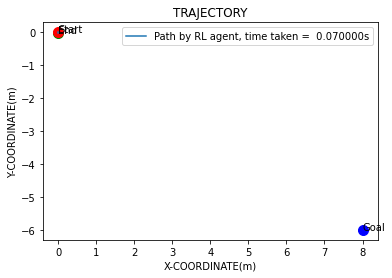

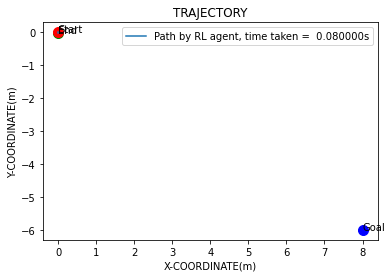

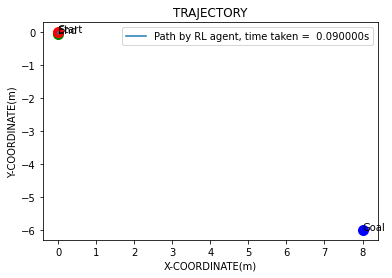

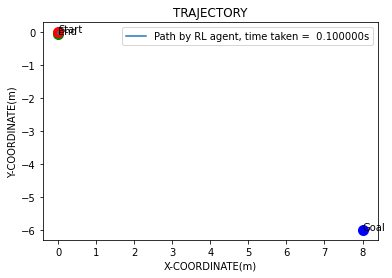

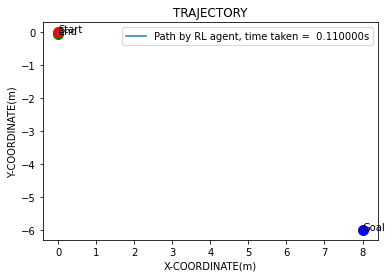

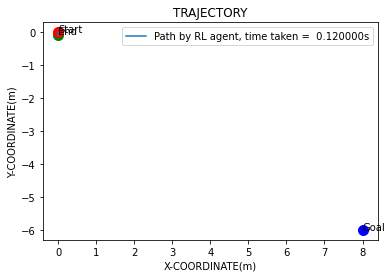

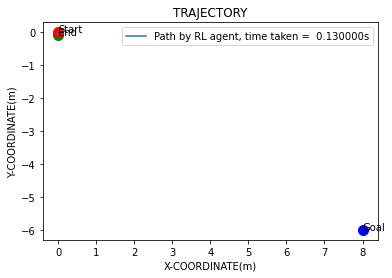

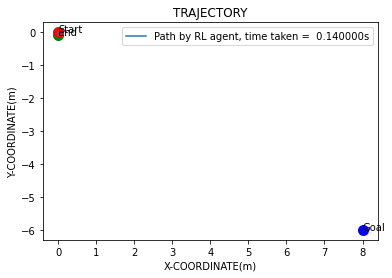

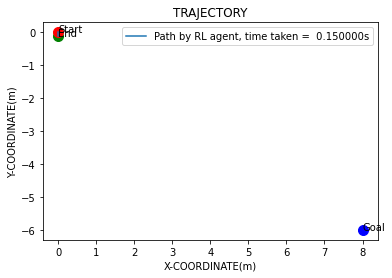

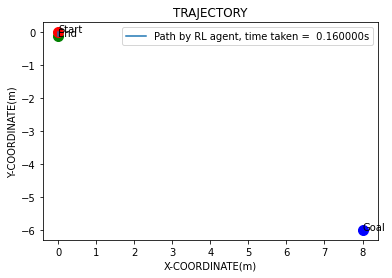

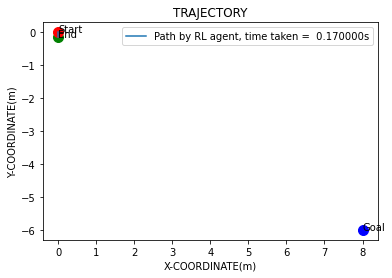

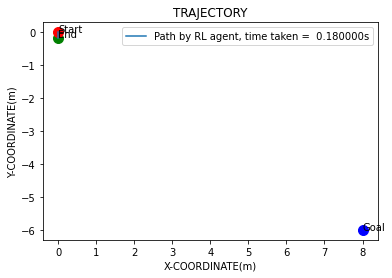

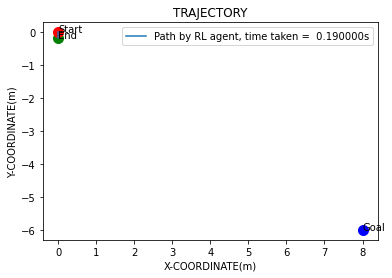

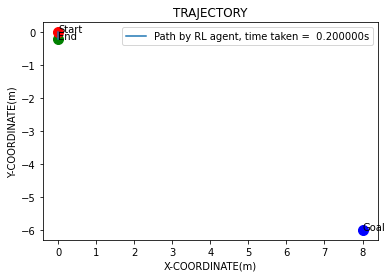

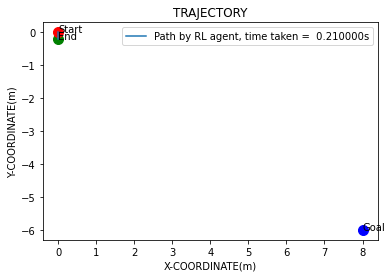

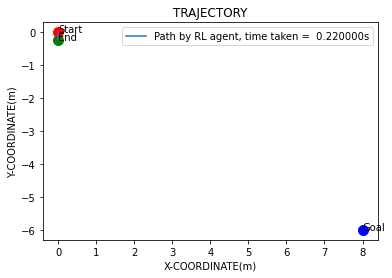

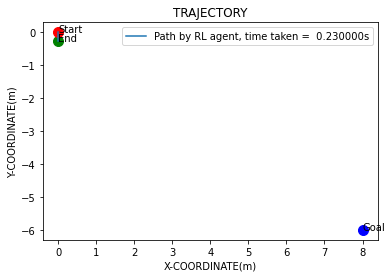

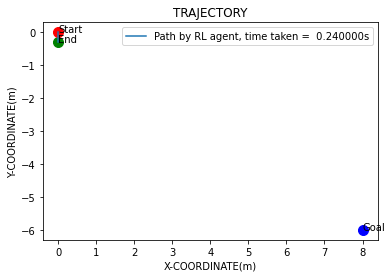

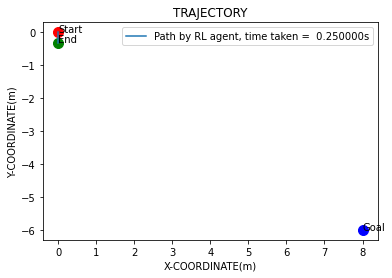

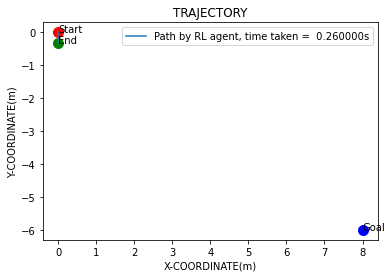

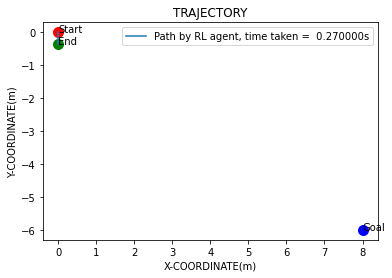

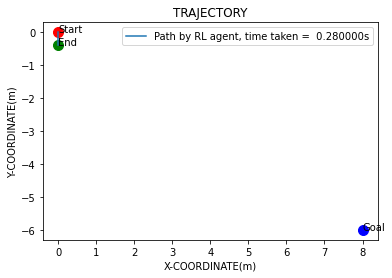

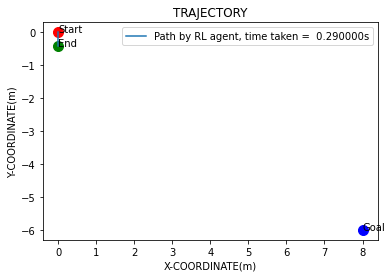

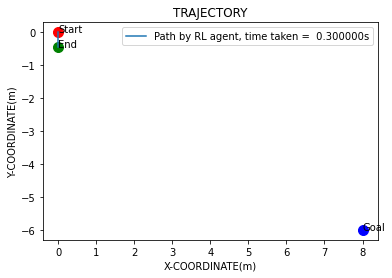

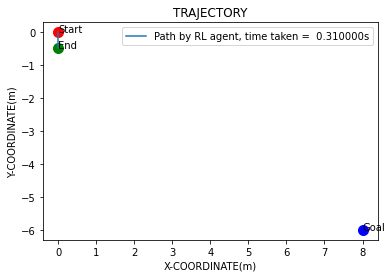

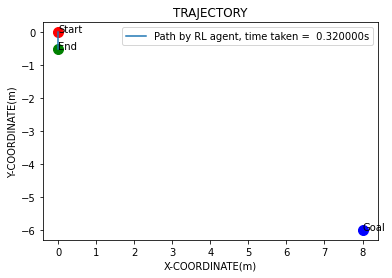

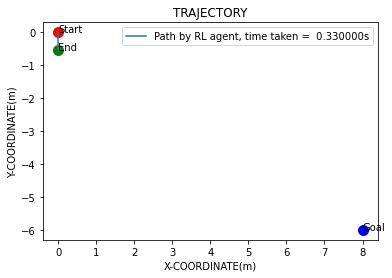

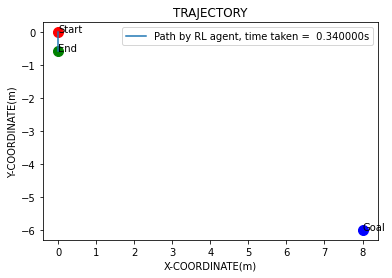

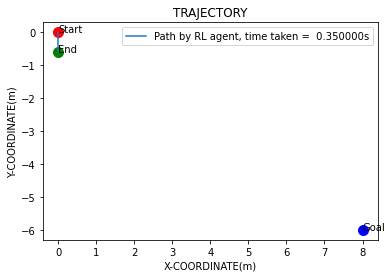

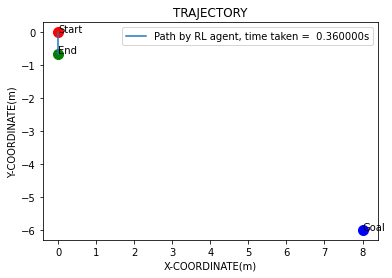

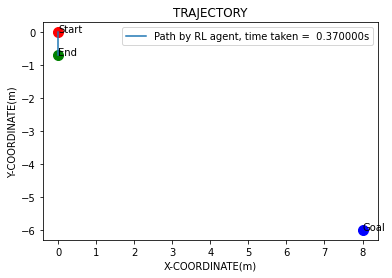

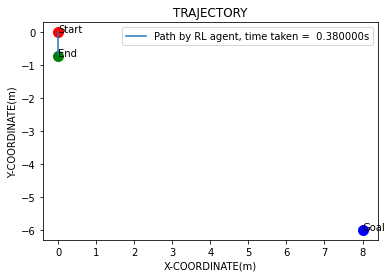

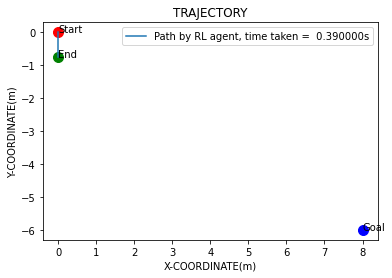

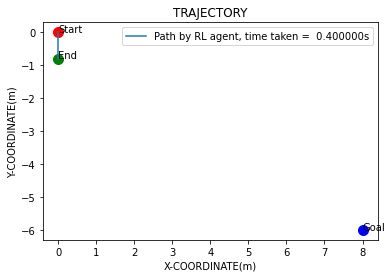

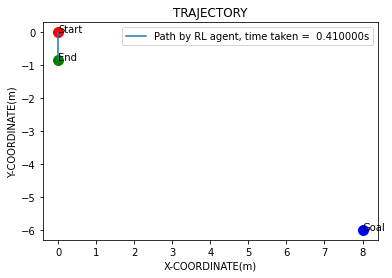

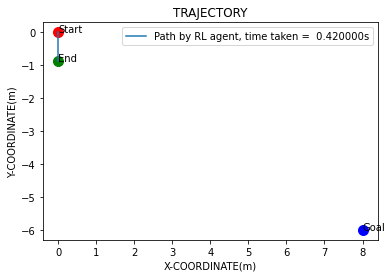

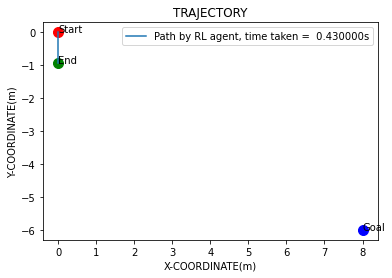

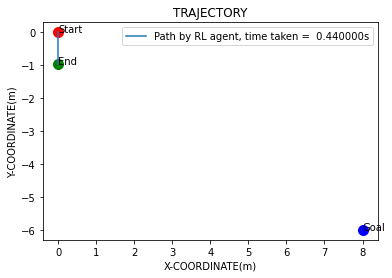

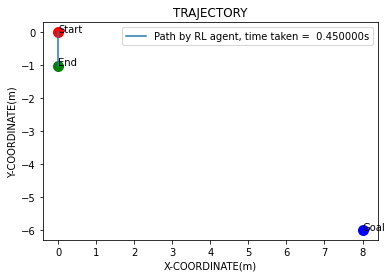

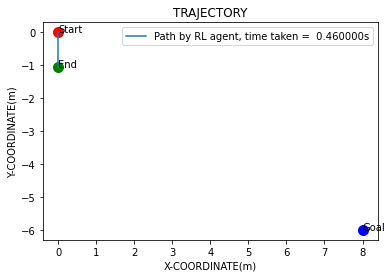

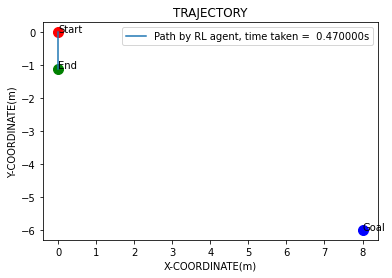

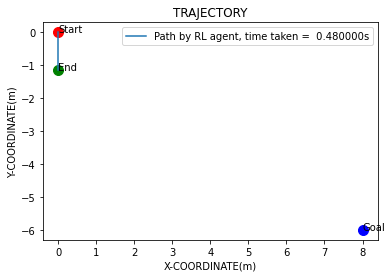

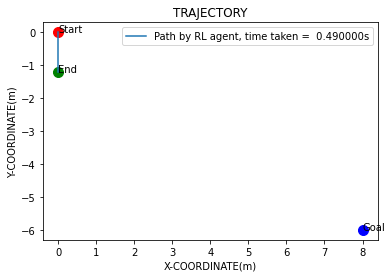

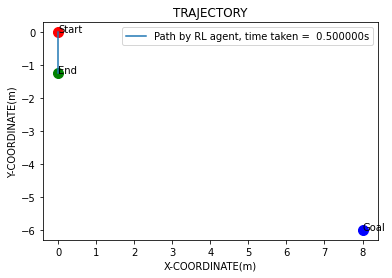

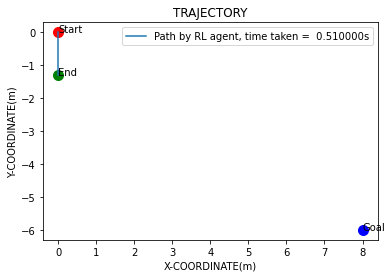

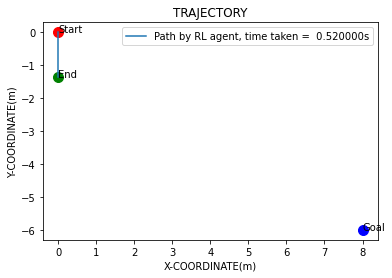

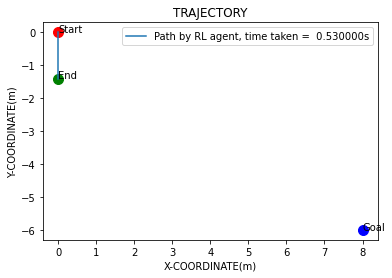

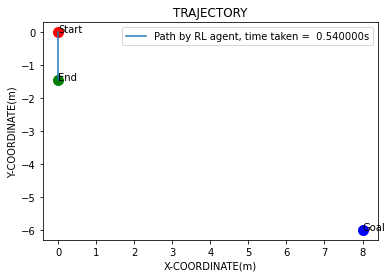

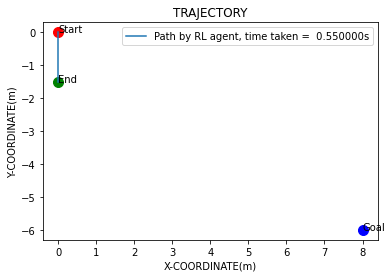

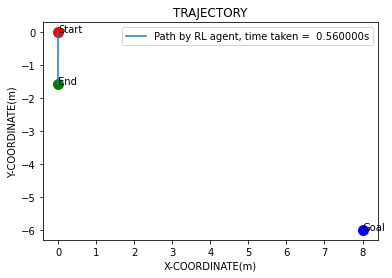

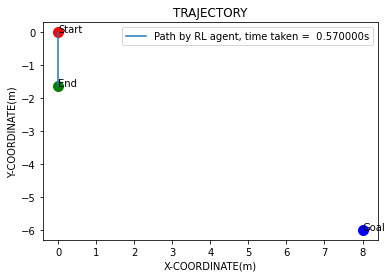

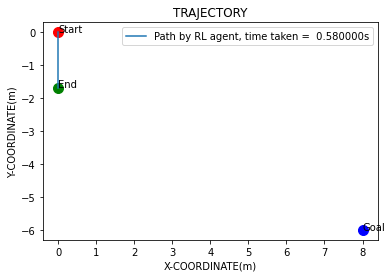

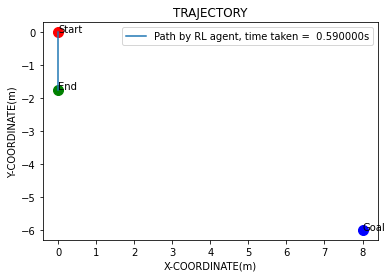

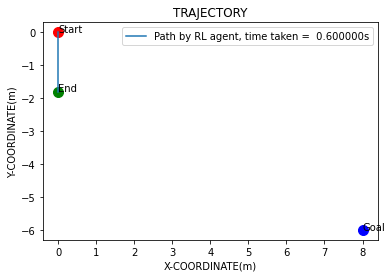

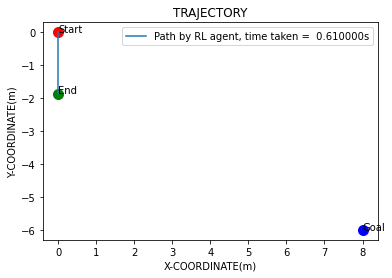

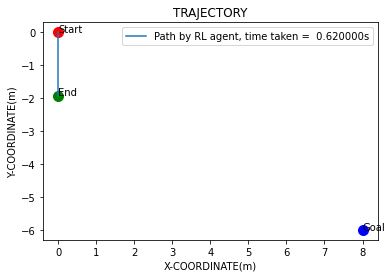

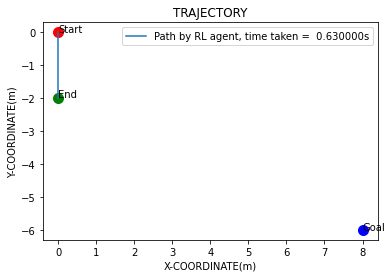

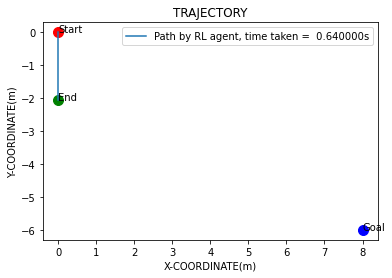

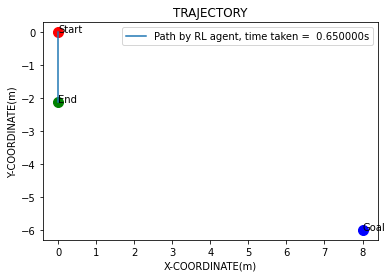

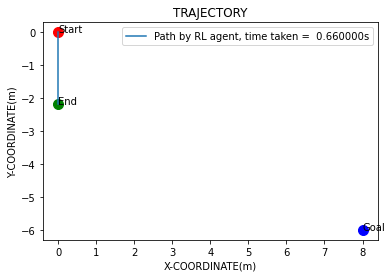

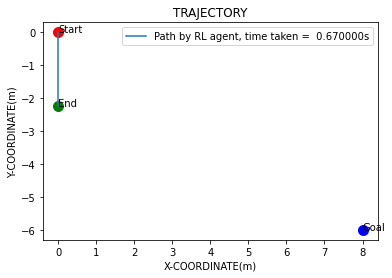

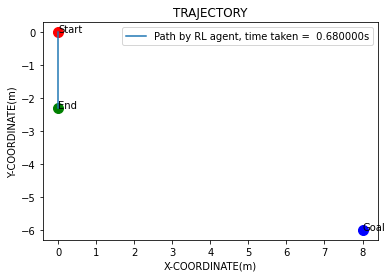

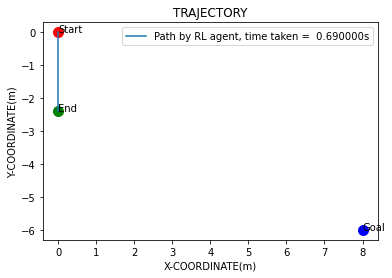

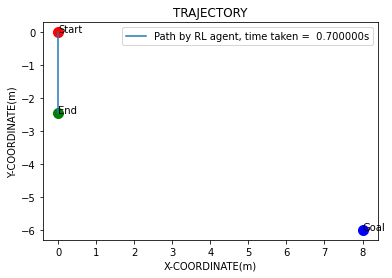

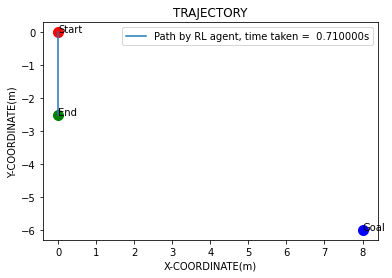

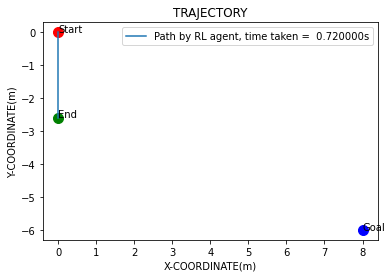

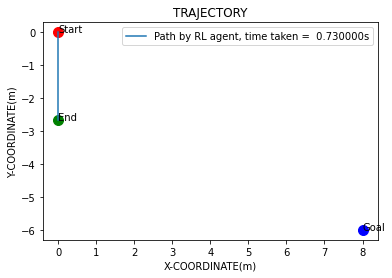

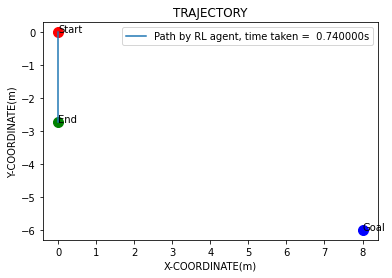

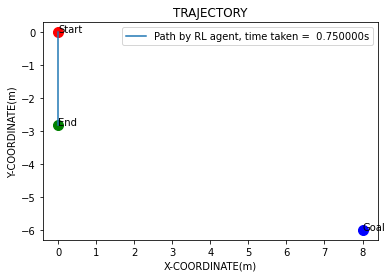

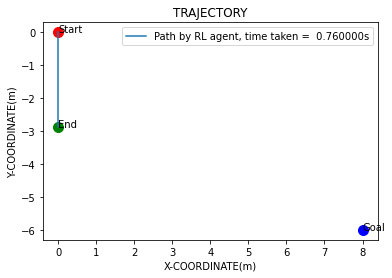

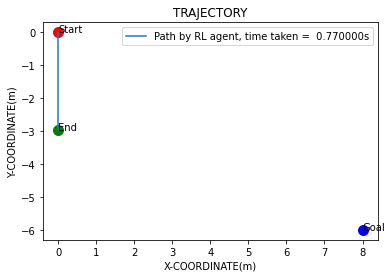

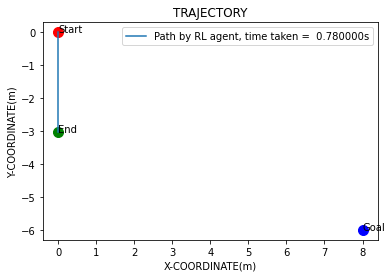

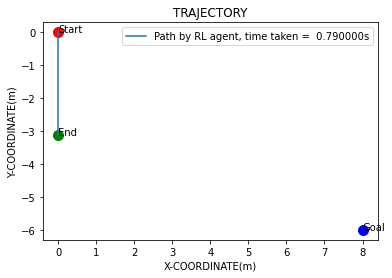

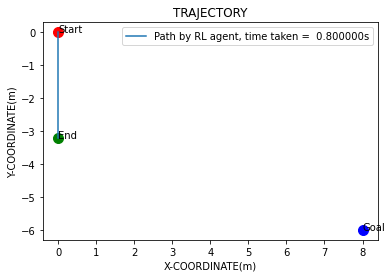

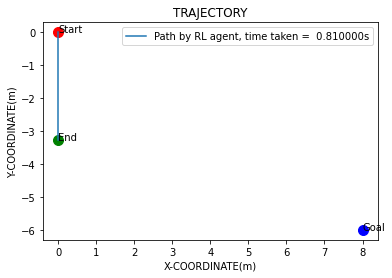

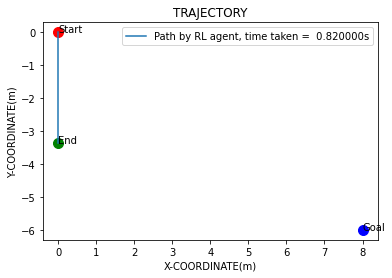

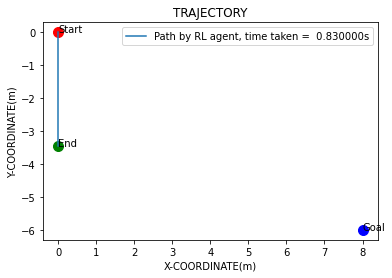

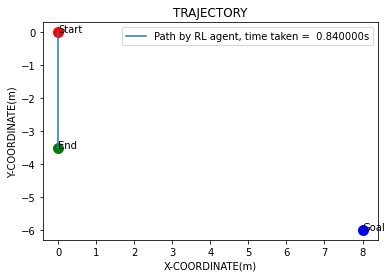

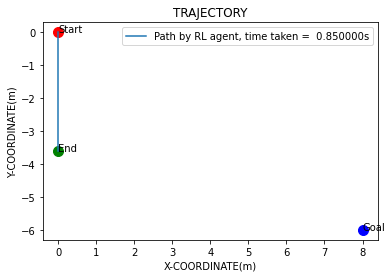

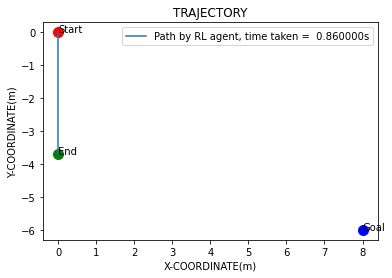

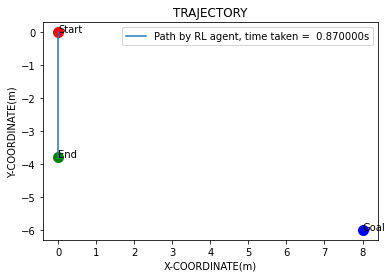

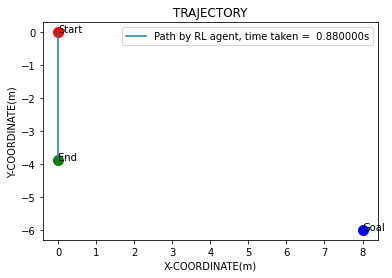

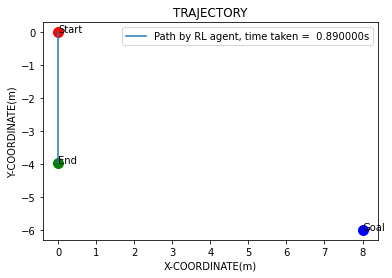

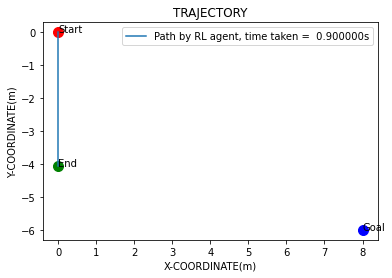

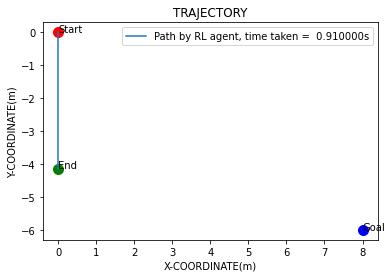

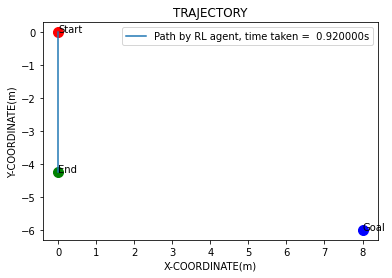

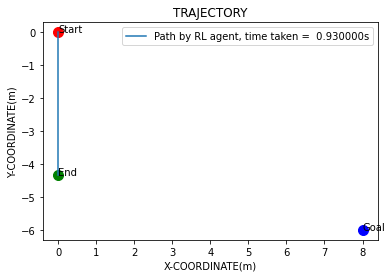

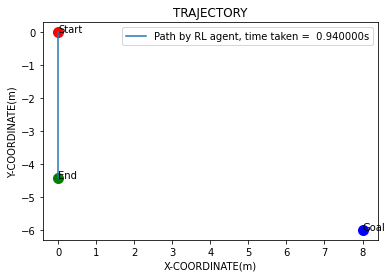

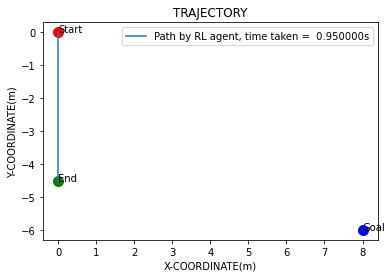

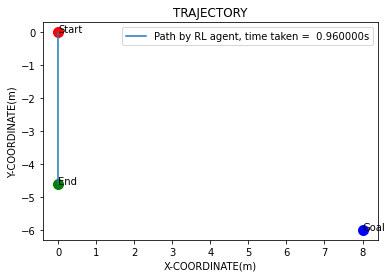

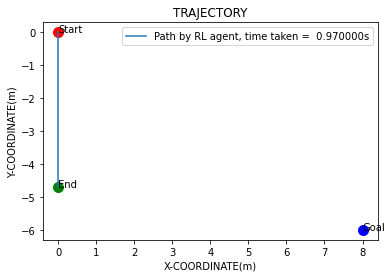

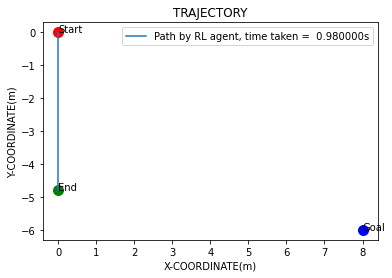

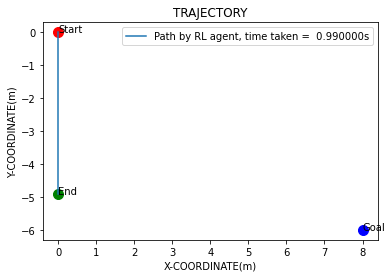

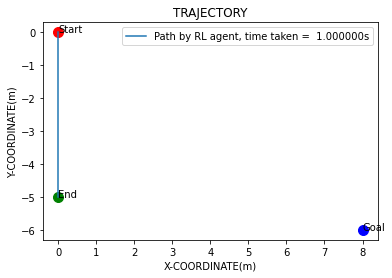

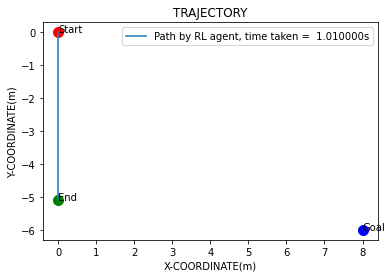

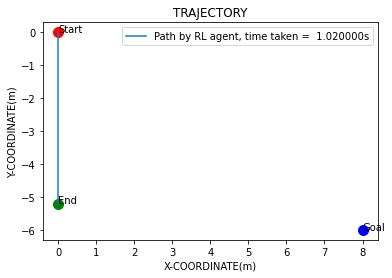

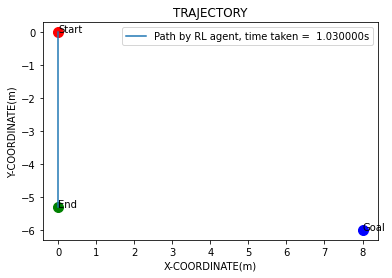

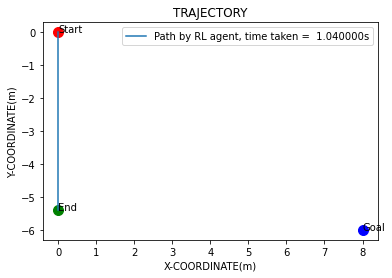

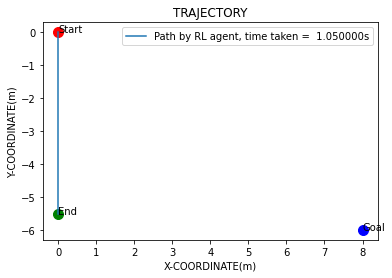

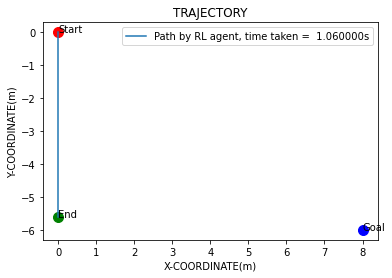

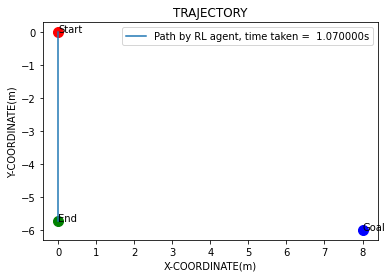

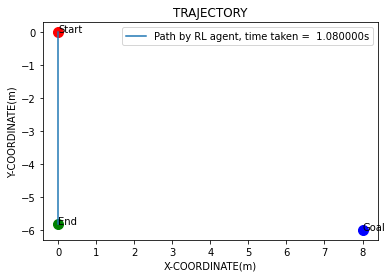

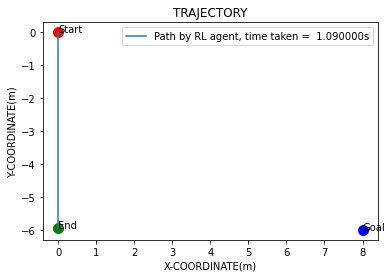

EP_REWARD:-180


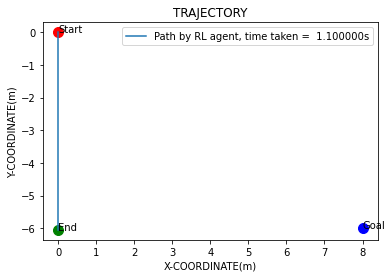

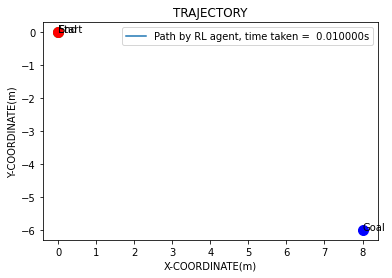

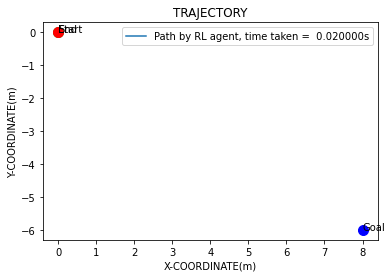

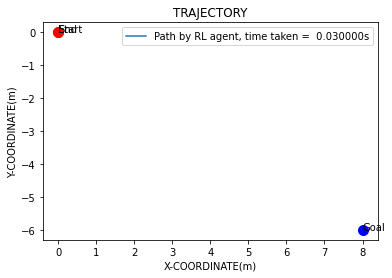

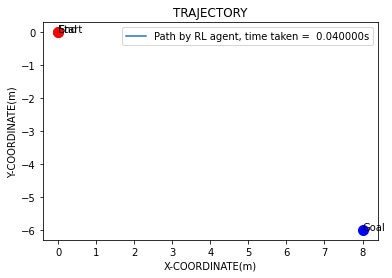

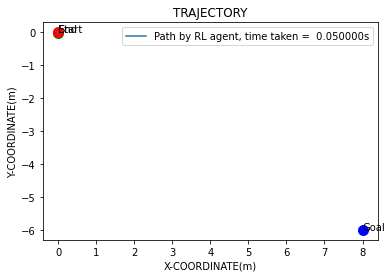

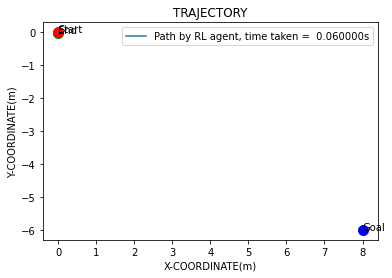

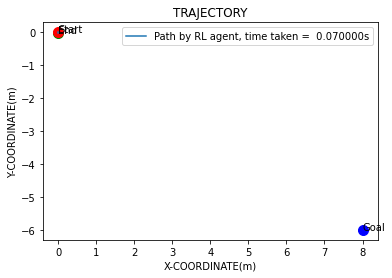

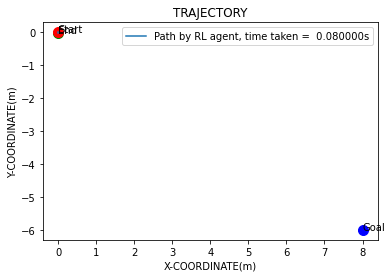

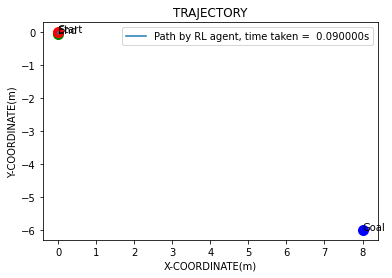

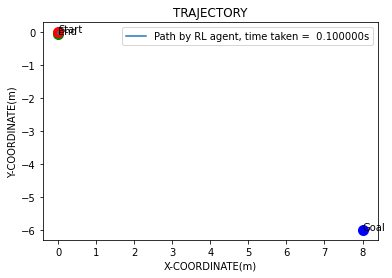

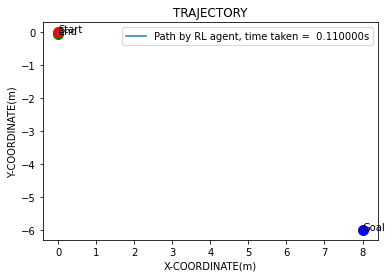

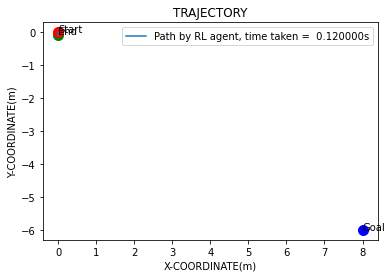

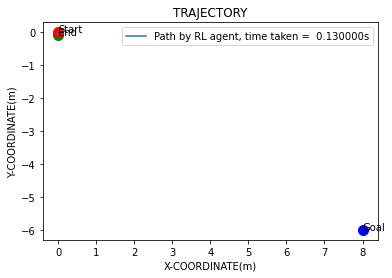

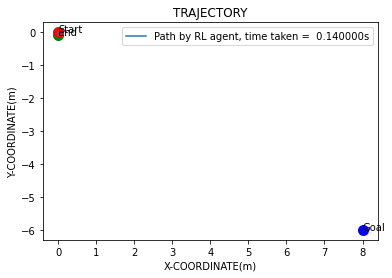

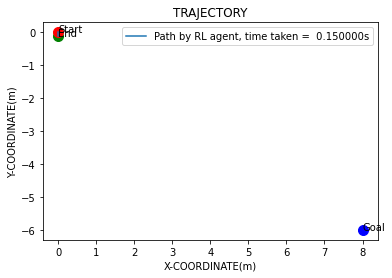

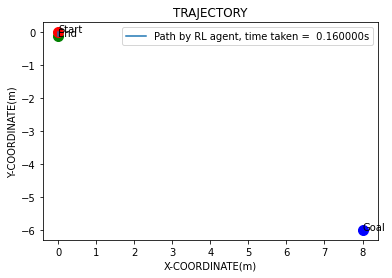

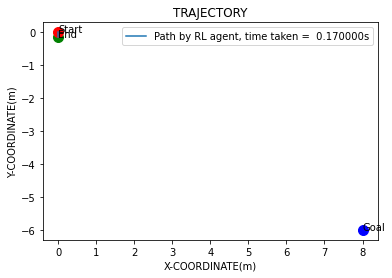

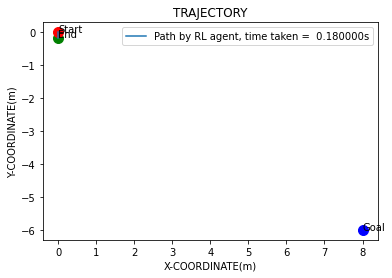

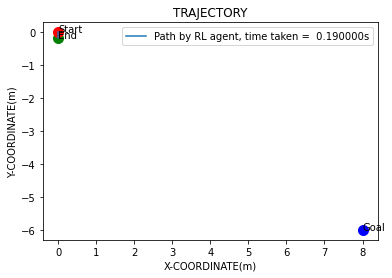

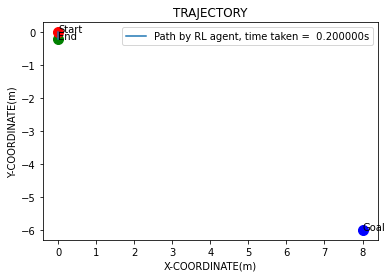

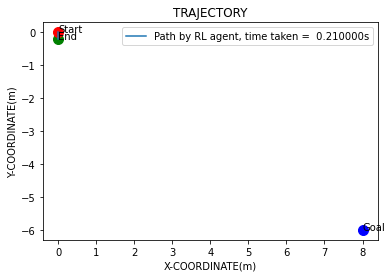

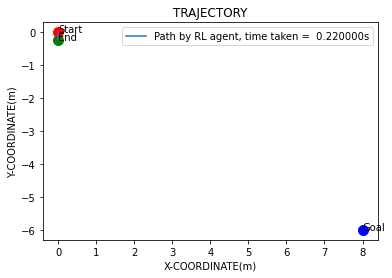

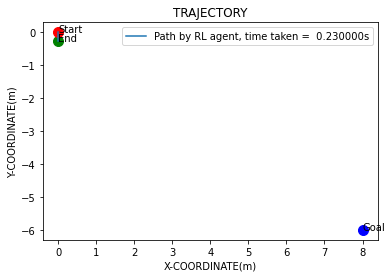

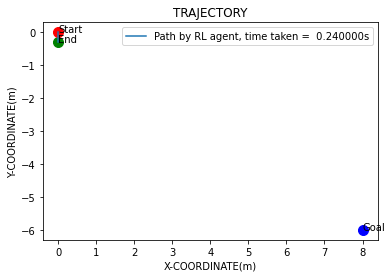

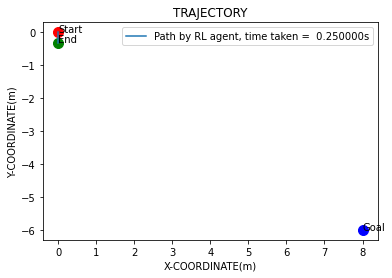

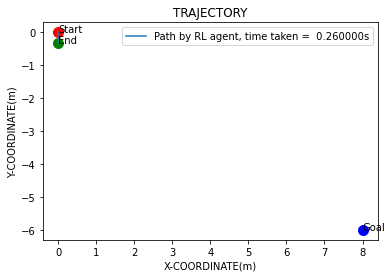

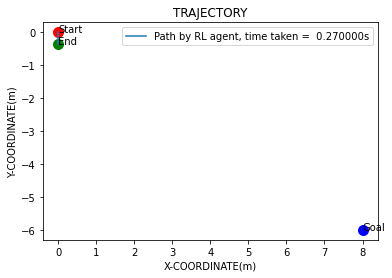

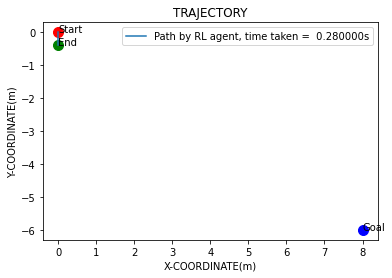

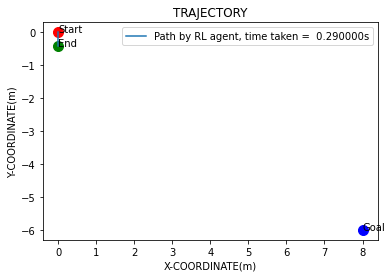

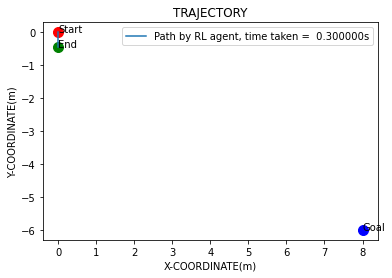

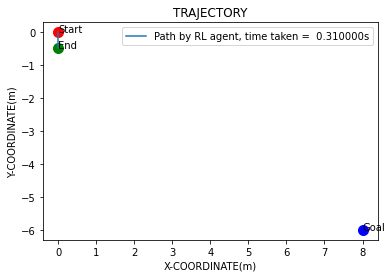

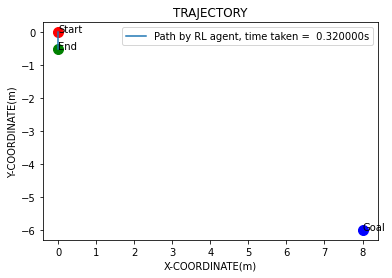

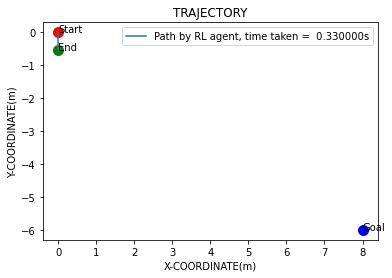

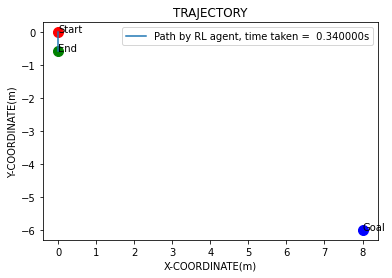

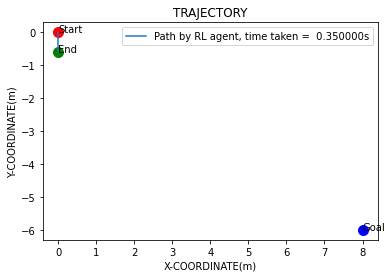

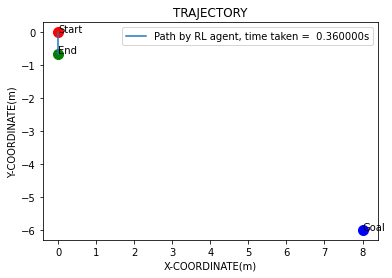

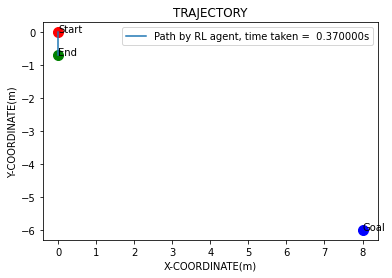

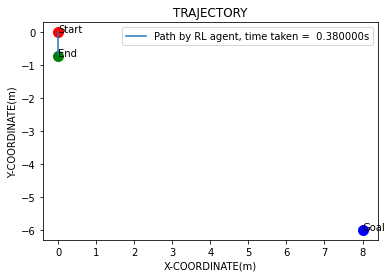

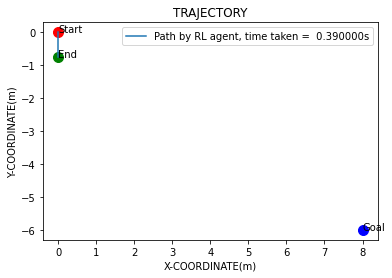

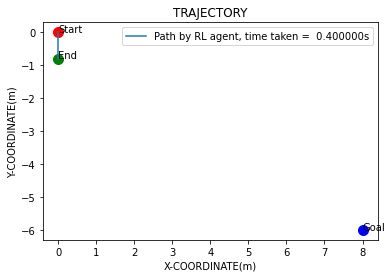

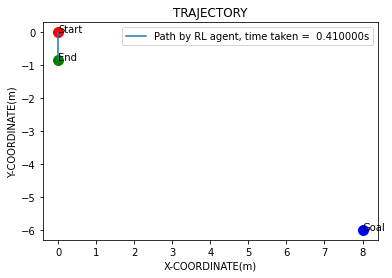

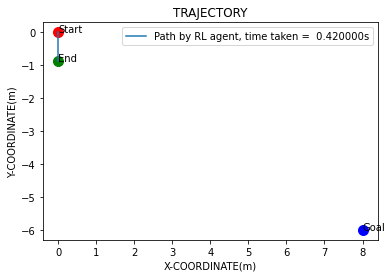

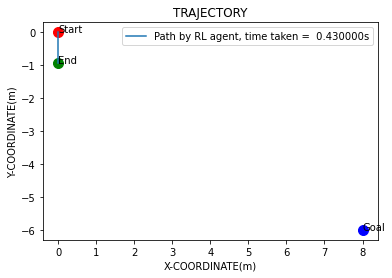

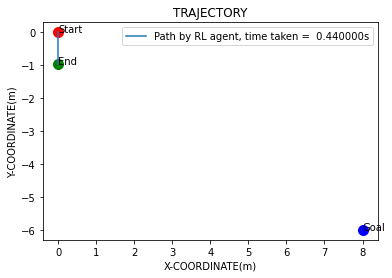

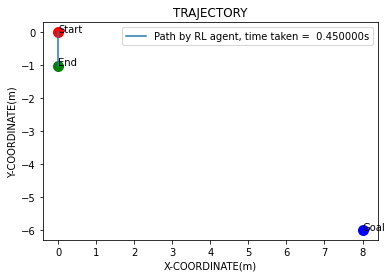

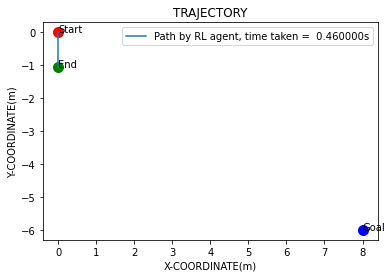

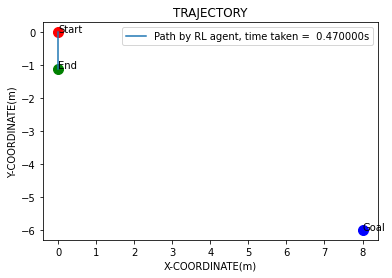

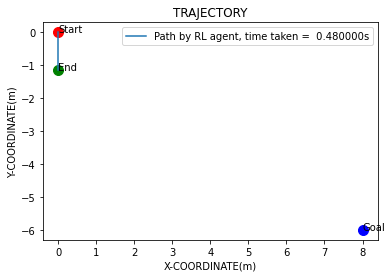

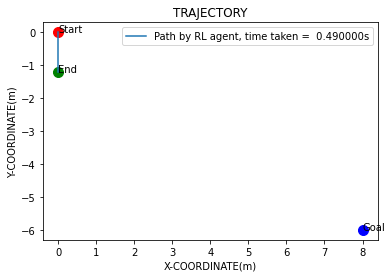

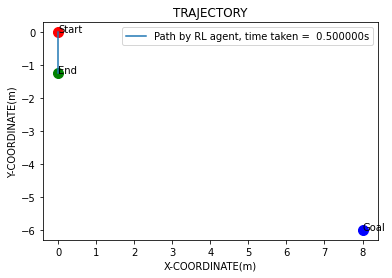

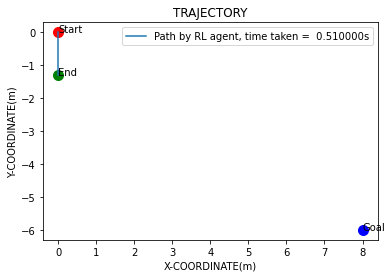

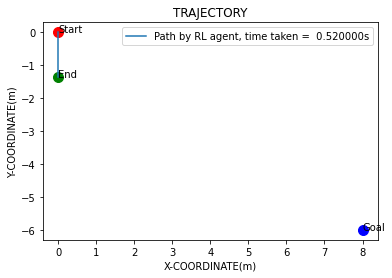

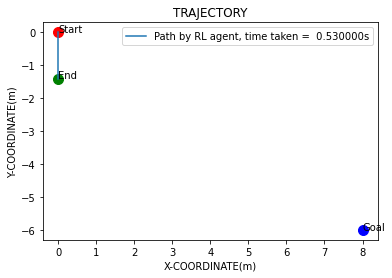

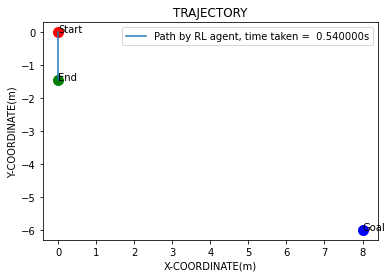

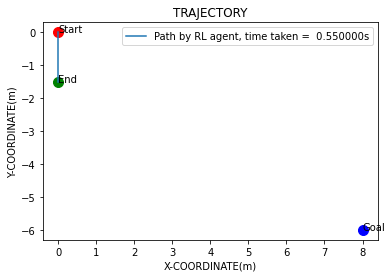

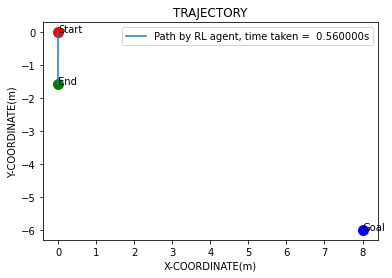

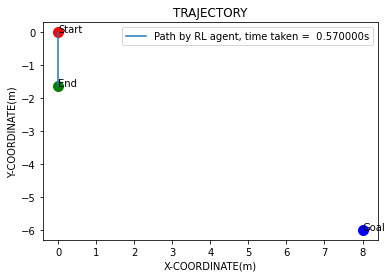

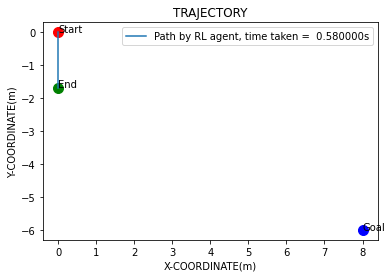

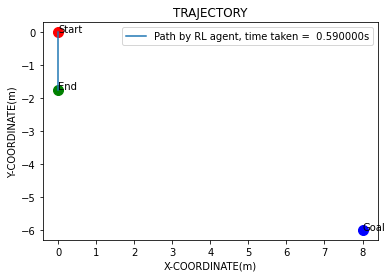

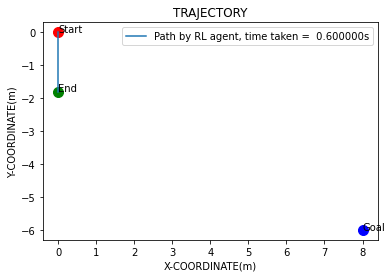

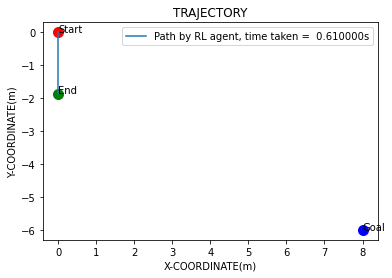

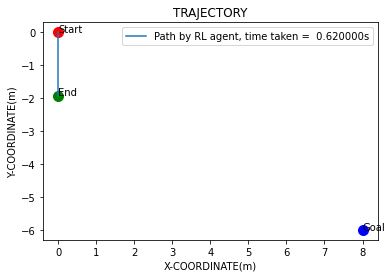

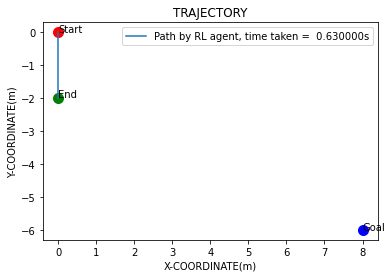

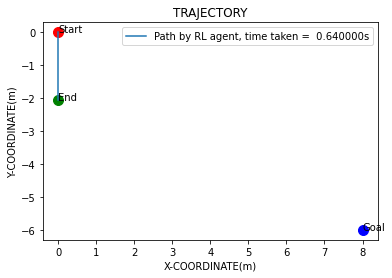

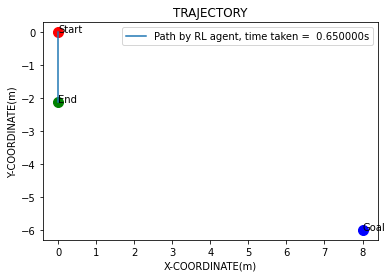

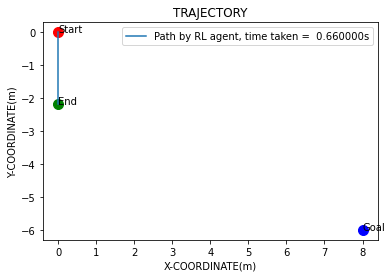

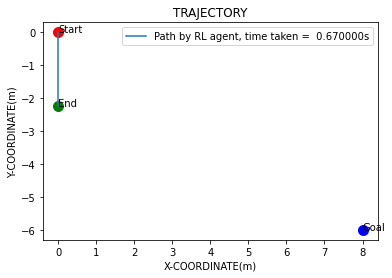

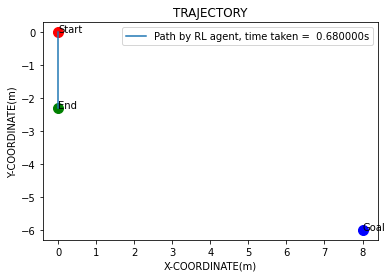

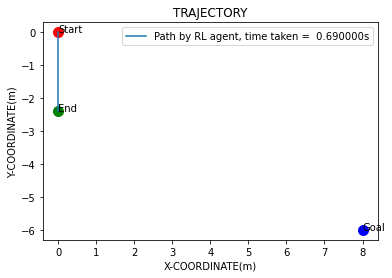

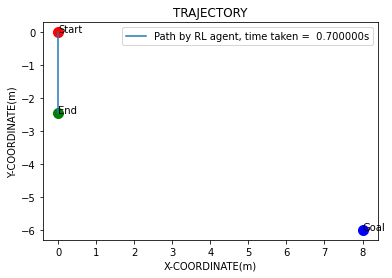

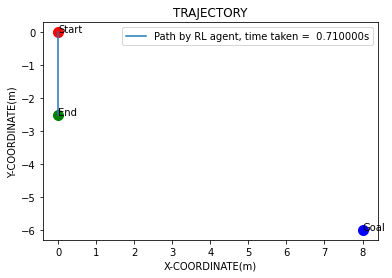

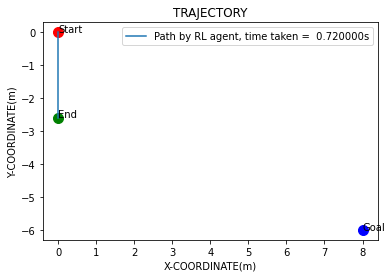

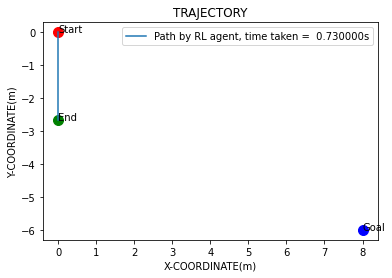

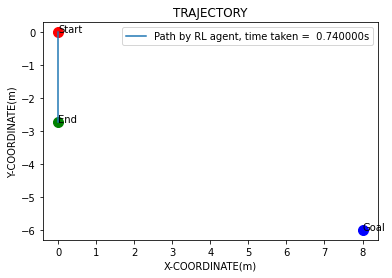

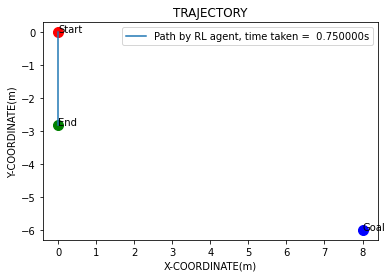

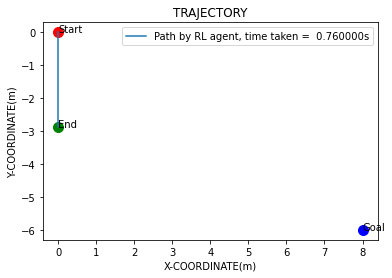

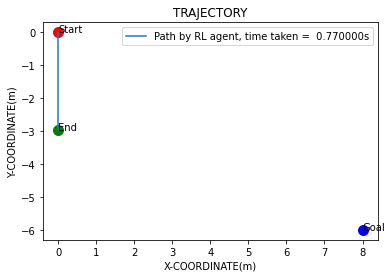

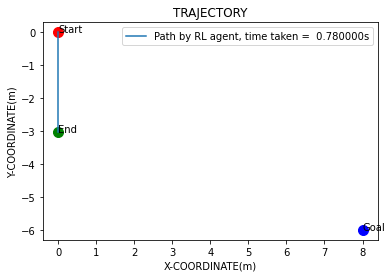

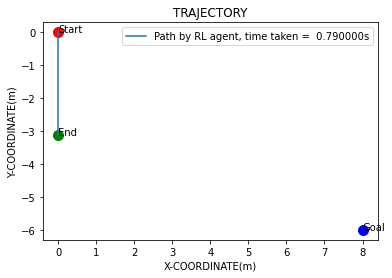

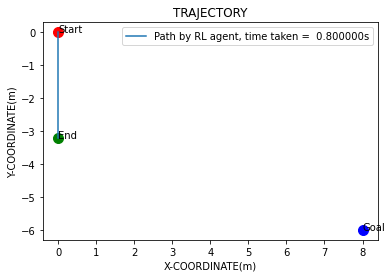

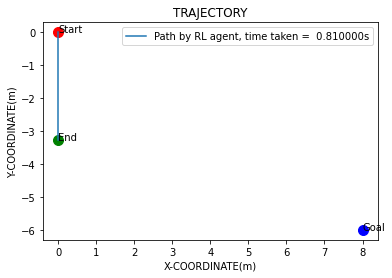

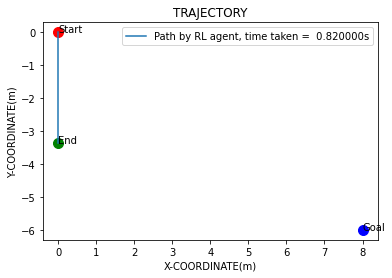

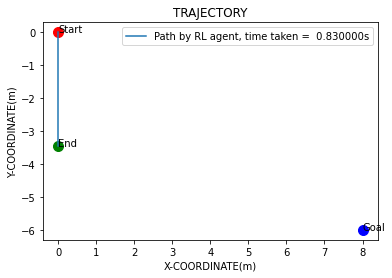

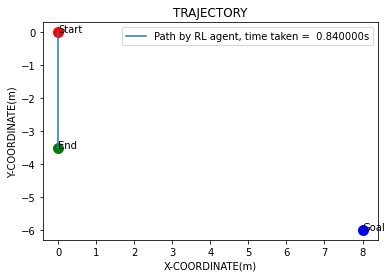

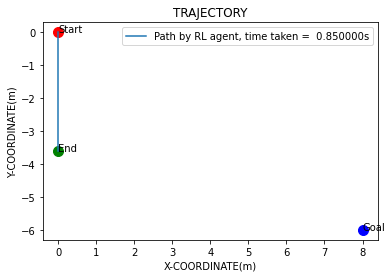

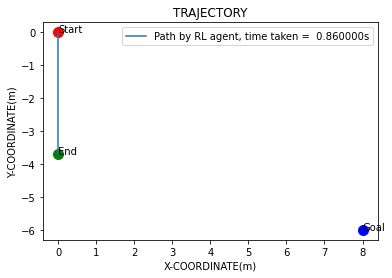

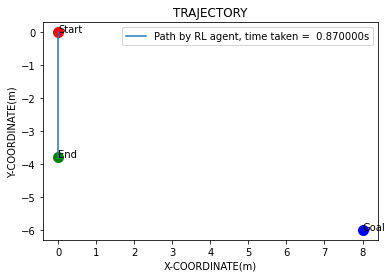

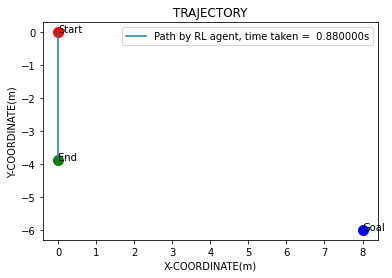

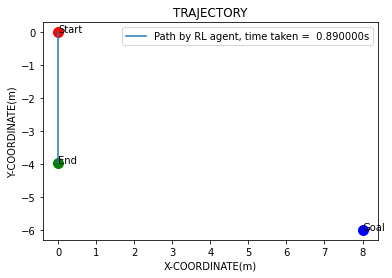

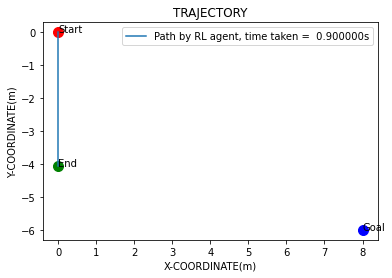

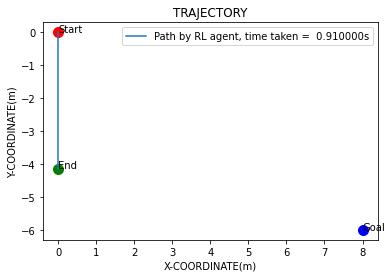

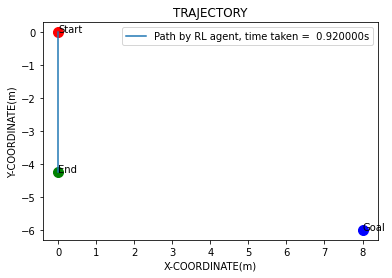

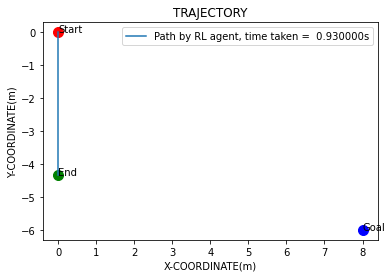

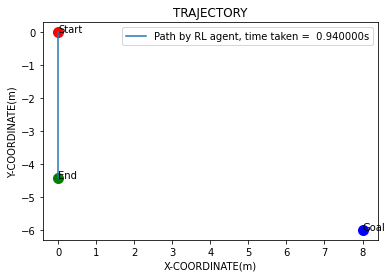

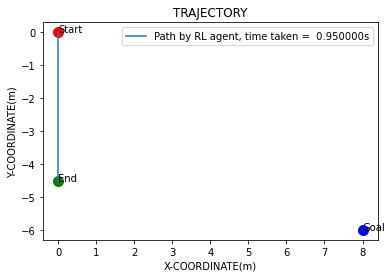

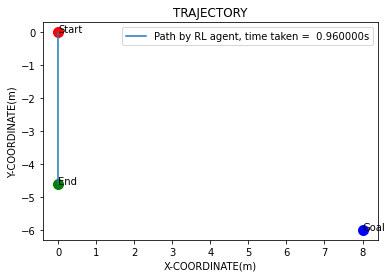

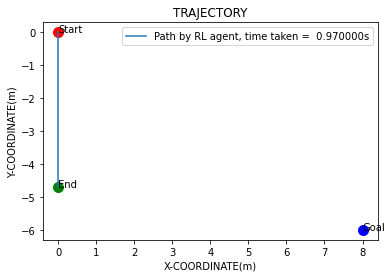

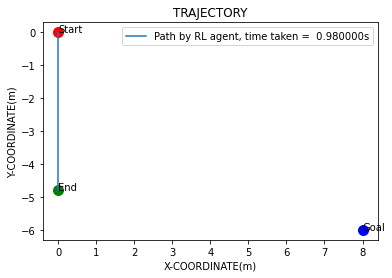

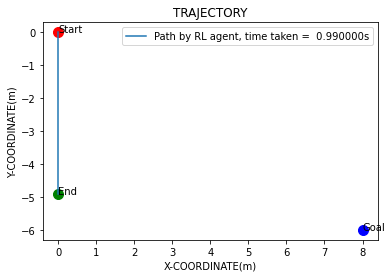

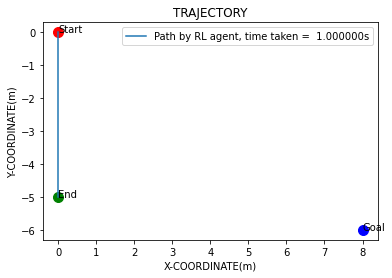

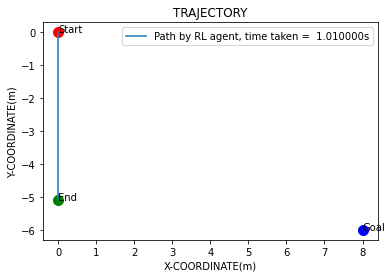

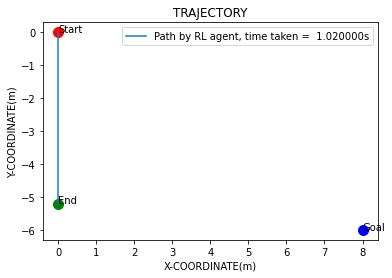

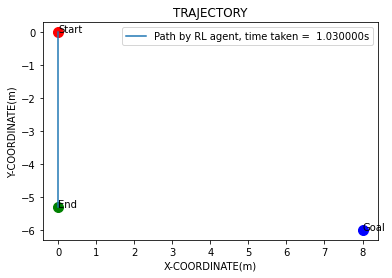

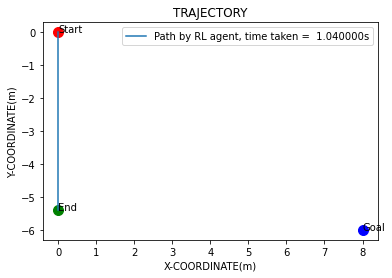

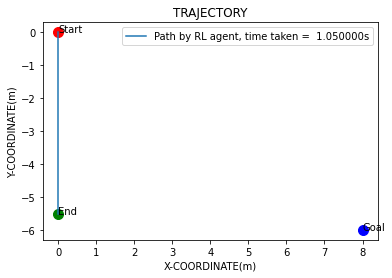

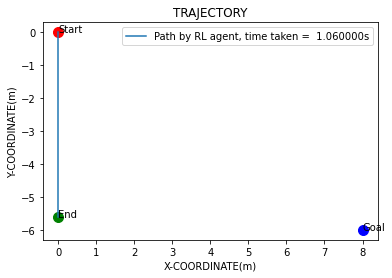

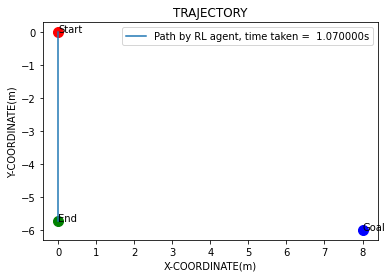

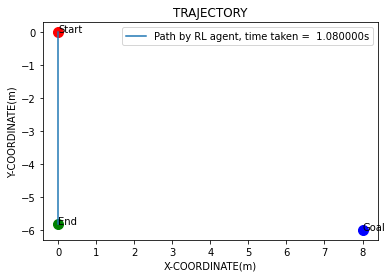

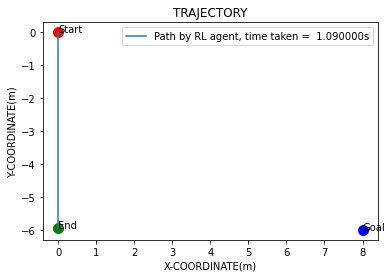

EP_REWARD:-180


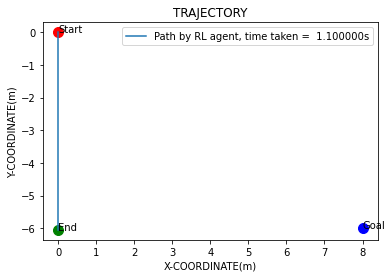

Eval num_timesteps=777, episode_reward=-279.09 +/- 0.00
Episode length: 110.00 +/- 0.00
New best mean reward!
EP_REWARD:-0.13968698829848536


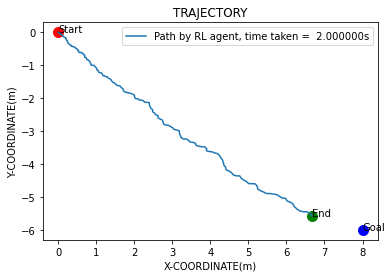

EP_REWARD:-148


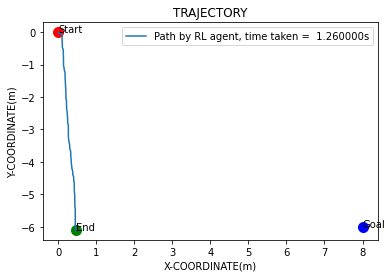

EP_REWARD:-178


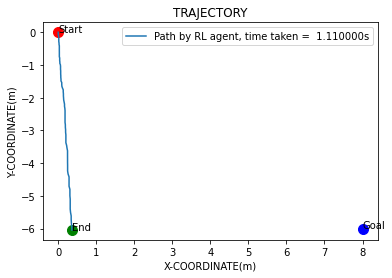

EP_REWARD:-176


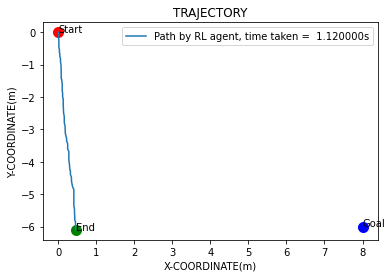

EP_REWARD:-178


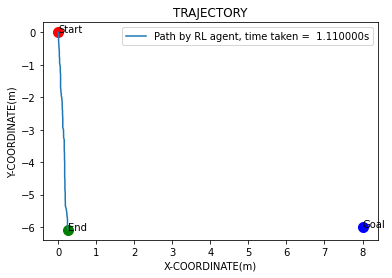

EP_REWARD:-178


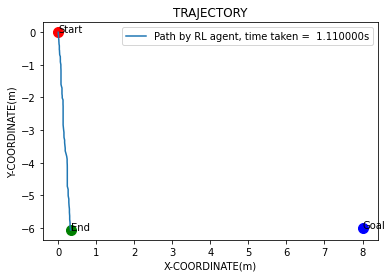

EP_REWARD:-178


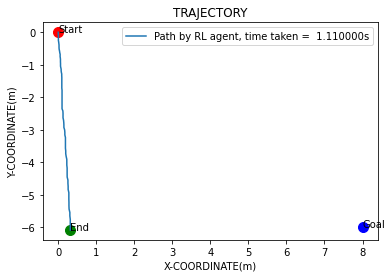

EP_REWARD:-176


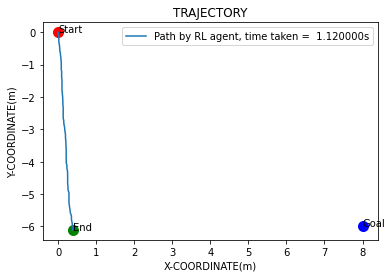

EP_REWARD:-178


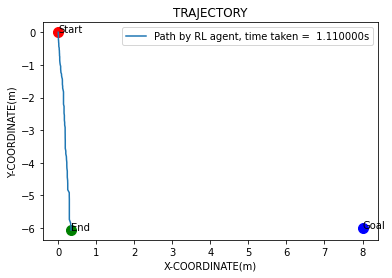

EP_REWARD:-178


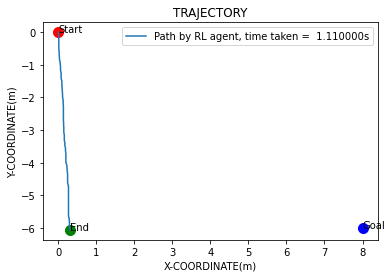

EP_REWARD:-178


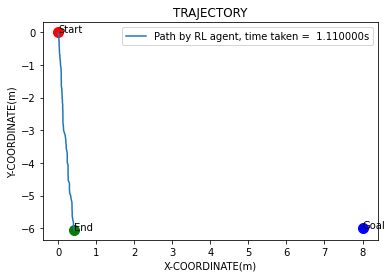

EP_REWARD:-178


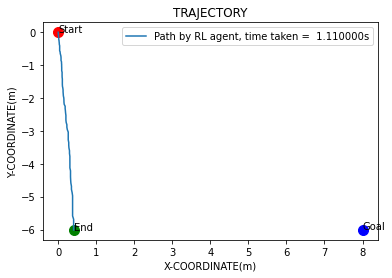

EP_REWARD:-178


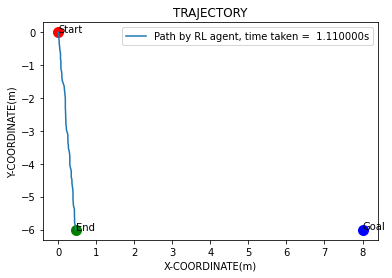

EP_REWARD:-178


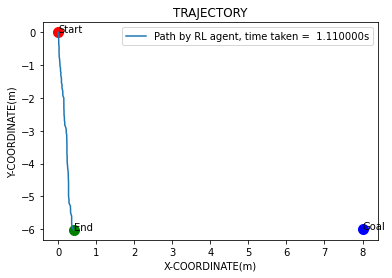

EP_REWARD:-178


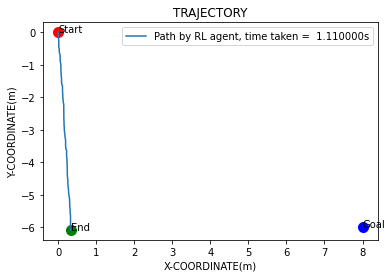

EP_REWARD:-178


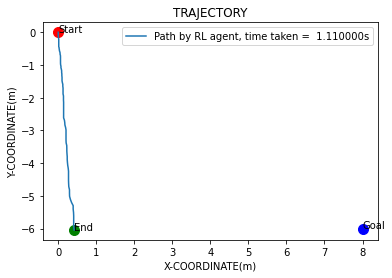

EP_REWARD:-178


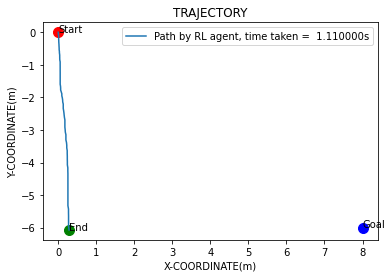

EP_REWARD:-178


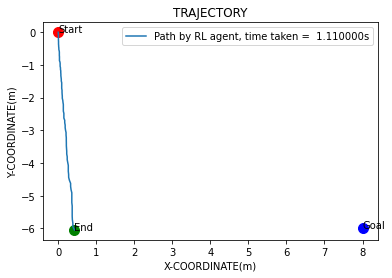

EP_REWARD:-178


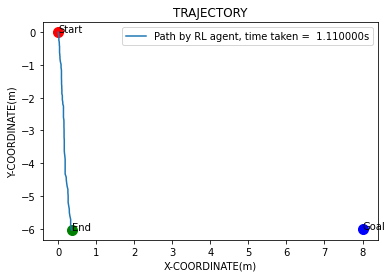

EP_REWARD:-178


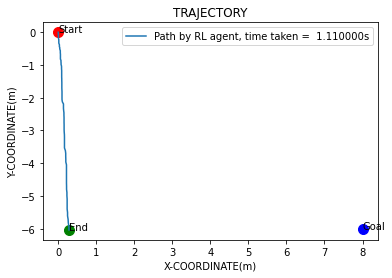

[ 6 -8]
EP_REWARD:0.0


C:\Users\Gianmarco Petrelli\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


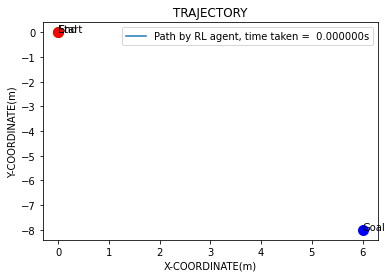

EP_REWARD:-38


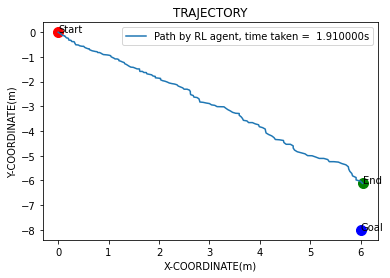

EP_REWARD:-34


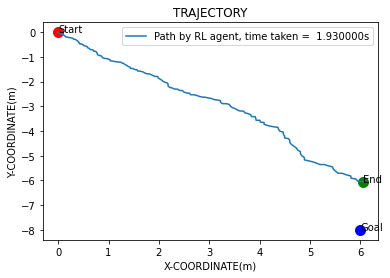

EP_REWARD:-36


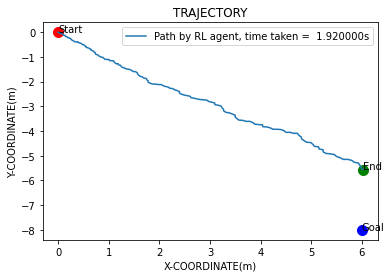

EP_REWARD:-26


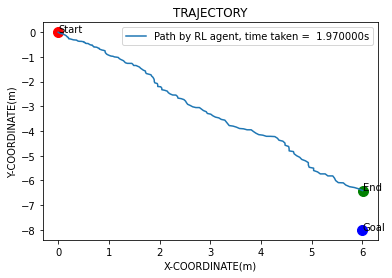

EP_REWARD:-44


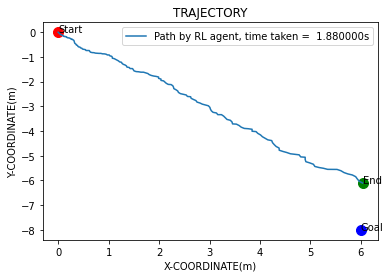

EP_REWARD:-124


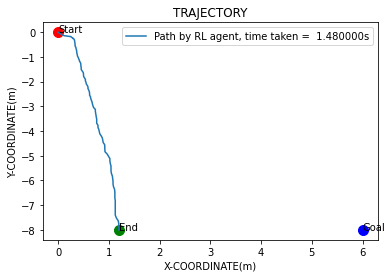

In [ ]:
"""MODEL TRAINING"""
TIMESTEPS=1000
""""""
env = Brachistochrone_Env()
print(env.target_pos)
#wrapping the environment to speed up training
env = make_vec_env(lambda: env, n_envs=1)

n_actions = env.action_space.shape[-1]
# this can help for hard exploration problem
action_noise = NormalActionNoise(mean = np.zeros(n_actions), 
                                sigma=0.2*np.ones(n_actions))

#using callback to actuate performance check improving periodically the model in a  "verify and save model" approach
eval_callback = EvalCallback(env, best_model_save_path='./saved_models/generalized2_3',
                             log_path='./logs/generalized2_3', eval_freq=5000,
                             deterministic=True, render=True)

#config. a dynamic learning rate
#sched_LR = LinearSchedule(TIMESTEPS, 0.001, 0.0000125)

#we keep "gamma" discount factor high to strengthen exploration 
model = DDPG('MlpPolicy', env =env, action_noise=action_noise, verbose=0,
            gamma= 0.9999, learning_starts = 1000,
             gradient_steps = -1, learning_rate=0.1,
            policy_kwargs= dict(net_arch=[400, 600, 400]), train_freq = (1, "episode"), tensorboard_log="./barchistostrone_ddpg_tensorboard/generalized2")

os.system('spd-say "your program has started"')


model.learn(total_timesteps=TIMESTEPS, log_interval=1, callback=eval_callback)


In [ ]:
def cycloid(P1,P2,N):
    """Return the path of Brachistochrone curve from (0,0) to (x2, y2).
    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).
    """

    # First find theta2 from (x2, y2) numerically (by Newton-Rapheson).
    f = lambda theta: -P2[1]/P2[0] - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/2)

    # The radius of the circle generating the cycloid.
    R = -P2[1] / (1 - np.cos(theta2))

    theta = np.linspace(0, theta2, N)
    x = R * (theta - np.sin(theta))
    y = R * (1 - np.cos(theta))

    # The time of travel
    T = theta2 * np.sqrt(R / 9.8)
    return x, y, T

def rect(P1,P2,N):
    """Return the rectilinear straight path from (0,0) to (x2, y2)."""
    x_interval = np.linspace(P1[0],P2[0],N)
    m = float(P2[1] - P1[1])/(P2[0]-P1[0])
    q = P1[1] - (m*P1[0])
    f_y = lambda x: m*x+q
    y = [f_y(x) for x in x_interval]
    T_rett = math.sqrt(2*(P2[0]**2+P2[1]**2)/(-9.8*P2[1]))
    return x_interval,y,T_rett

In [ ]:
#building found optimal path
env = Brachistochrone_Env()
env = make_vec_env(lambda: env, n_envs=1)
model = DDPG.load("saved_models/generalized2_2/best_model", env=env)

"""SET GOAL"""
goal = (8.0, -6.0)
""""""""""""""""""

position= [] #list of tuples containing subsequent positions
x = [] # x steps
y = [] #y values associated
steps = 0
actions = []
observations = []
#BUILD SOLUTION
#print("Episode {}".format(ep + 1))
episodic_reward = []


#we have to force target into environment as it must be constant and specified to AI agent
obs = env.reset()
obs = env.env_method("reset_set_target",goal)
print("Inital obs: "  +str(obs))
while True:
    action= model.predict(obs, deterministic = False)
    #print("azione:",action)
    #print("prima",obs)
    obs, reward, done, info = env.step(action)
    observations.append(obs)
    #print("dopo",obs)
    new_value = obs[0] #the array from which to extract new piece of path information
    """new_value[1]: pos_x new_value[2]: pos_y"""
    position.append((new_value[1],new_value[2]))
    if done==False:
        x.append(new_value[1])
        y.append(new_value[2])
    episodic_reward.append(reward)
    actions.append(action)
    steps+=1
    #print('obs=', obs, 'reward=', reward, 'done=', done)
    if done:
        #print(env.get_attr("video"))
        #env.render()
        x.pop()
        y.pop()
        position.pop()
        print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
        print("Steps taken: " + str(steps))
        print("Time taken: " , steps/100)

        break
            


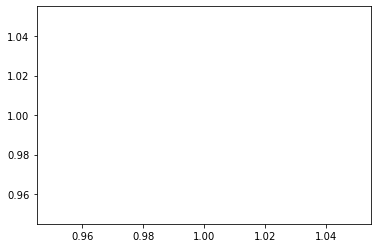

In [ ]:
"""execute this before plotting to avoid kernel dead"""
import matplotlib
import matplotlib.pyplot as plt
plt.plot(1,1)

Time taken by cycloid =  1.6071631124415775
Time taken by linear solution =  1.8442777839082938


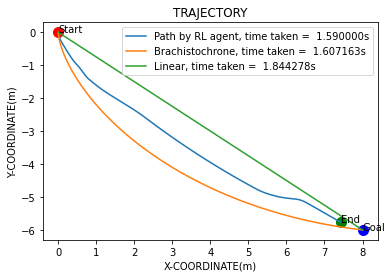

In [ ]:
#plot results
cycloid_x, cycloid_y, cycloid_T = cycloid((0,0), goal, steps)
rect_x, rect_y, rect_T = rect((0,0), goal, steps)
print('Time taken by cycloid = ', cycloid_T)
print('Time taken by linear solution = ', rect_T)

time_taken = steps/100
plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
plt.plot(cycloid_x, -cycloid_y, label='Brachistochrone, time taken =  %fs' %cycloid_T)
plt.plot(rect_x, rect_y, label='Linear, time taken =  %fs' %rect_T)
plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
plt.scatter(x[0], y[0], color = 'red', s = 100.0)
plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
plt.annotate('Start', (x[0], y[0]))
plt.annotate('End', (x[-1], y[-1]))
plt.annotate('Goal', goal)
plt.legend()
plt.xlabel('X-COORDINATE(m)')
plt.ylabel('Y-COORDINATE(m)')
plt.title('TRAJECTORY')
plt.show()

In [ ]:
#further training

eval_callback = EvalCallback(env, best_model_save_path='./saved_models/final2/',
                             log_path='./logs/', eval_freq=5000,
                             deterministic=True, render=False)

model.learn(total_timesteps=400000, log_interval=1, callback=eval_callback)

In [ ]:
mu, sigma = 0, 10 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
s

array([  7.59732866,  -1.46496075,  -8.07597509, ..., -24.01218154,
         4.53892451,  -5.67899005])

In [ ]:
t= (x for x in s if x >10)
next(t)

15.447989481354178

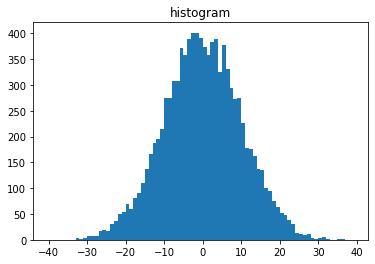

In [ ]:
bins = np.asarray([i / 10 for i in range(0, 11, 1)])
bins_idx = np.digitize(s, bins, right=False)
bin_count = np.bincount(bins_idx)
idx = np.cumsum(bin_count)
prob_bins = [s[idx[i]:idx[i + 1]] for i in range(len(idx) - 1)]
#prob_bins is an array of bins

plt.hist(s, bins = range(-40,40,1)) 
plt.title("histogram") 
plt.show()